In [1]:
import time
import numpy as np
from numpy import mean, std, dstack
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, matthews_corrcoef
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Dropout, InputLayer
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Layer
import xlsxwriter
from tensorflow.keras.regularizers import l2
from keras import layers
import keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

In [2]:
class Time2Vec(Layer):
    def __init__(self, kernel_size=1):
        super(Time2Vec, self).__init__()
        self.k = kernel_size

    def build(self, input_shape):
        self.w0 = self.add_weight(name="w0", shape=(1,), initializer="uniform", trainable=True)
        self.b0 = self.add_weight(name="b0", shape=(1,), initializer="uniform", trainable=True)
        self.w = self.add_weight(name="w", shape=(input_shape[-1], self.k), initializer="uniform", trainable=True)
        self.b = self.add_weight(name="b", shape=(self.k,), initializer="uniform", trainable=True)

    def call(self, inputs):
        v1 = self.w0 * inputs + self.b0
        v2 = tf.math.sin(tf.matmul(inputs, self.w) + self.b)
        return tf.concat([v1, v2], axis=-1)

In [3]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [4]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_classes,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv1D(filters=64, kernel_size=8, activation='relu', bias_regularizer='l2')(inputs)
    x = layers.MaxPooling1D(pool_size=17,strides=9)(x)
    x = Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    x = Time2Vec()(x)

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


In [5]:
def evaluate_model(trainX, trainy, testX, testy, sujet):
    verbose, epochs, batch_size = 1, 200, 64
    # Extract dimensions from training data:
    n_timesteps = trainX.shape[1]
    d_model= trainX.shape[2]  # This is 12 in your case
    n_outputs = trainy.shape[1]

    print("Train Data Shape:", trainX.shape)  # (num_samples, sequence_length, 12)
    print("Test Data Shape:", testX.shape)

    # Build the classifier model using the raw input dimension and then projecting internally.
    model = build_model(
       input_shape=(n_timesteps, d_model),
       head_size=128,
       num_heads=12,
       num_classes=n_outputs,
       ff_dim=24,
       num_transformer_blocks=1,
       mlp_units=[128],
       mlp_dropout=0.4,
       dropout=0.25,
    )
    model.summary()

    # Compile the model with categorical crossentropy and Adam optimizer.
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])


    # Train the model
    start = time.time()
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[history])
    train_time = time.time() - start  # seconds

    # Save the model
    model.save(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB2\models\transformer2' + str(sujet) + '_Transformer_model.h5')

    # Evaluate on training data
    loss_train, accuracy_train = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=1)
    start = time.time()
    loss_test, accuracy_test = model.evaluate(testX, testy, batch_size=batch_size, verbose=1)
    test_time = time.time() - start  # seconds

    # Predict on test data and convert predictions to class indices
    y_pred = np.argmax(model.predict(testX), axis=-1)
    testy_indices = [np.argmax(y) for y in testy]

    return loss_train, accuracy_train, loss_test, accuracy_test, y_pred, testy_indices, train_time, test_time


def summarize_results(scores, losses):
    m, s = mean(scores), std(scores)
    mL, sL = mean(losses), std(losses)
    print('\nAccuracy: %.5f (+/-%.5f)' % (m, s))
    print('Loss: %.5f (+/-%.5f)' % (mL, sL))

def run_my_experiment(sujet):
    # Load data from MATLAB file; update the path as needed.
    data = loadmat(fr"D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB2\data\normalized_data\S" + str(sujet) + "_E1_A1_150_100_N.mat")

    train_data = data['train_data']      # shape: (num_train_samples, sequence_length, d_model)
    train_labels = data['train_labels']    # shape: (num_train_samples, num_classes)
    test_data = data['test_data']          # shape: (num_test_samples, sequence_length, d_model)
    test_labels = data['test_labels']      # shape: (num_test_samples, num_classes)

    scores = list()
    losses = list()

    loss_train, score_train, loss_test, score_test, y_pred, testy, train_time, test_time = evaluate_model(
        train_data, train_labels, test_data, test_labels, sujet
    )

    print('>#%d: ' % (sujet))
    print('  train accuracy: %.5f' % (score_train))
    print('  train loss    : %.5f' % (loss_train))
    print('  test accuracy: %.5f' % (score_test))
    print('  test loss    : %.5f' % (loss_test))
    scores.append(score_test)
    losses.append(loss_test)
    summarize_results(scores, losses)

    return loss_train, score_train, loss_test, score_test, y_pred, testy, train_time, test_time


Train Data Shape: (1993, 300, 12)
Test Data Shape: (969, 300, 12)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 293, 64)   │      6,208 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 31, 64)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 31, 64)    │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 31, 64)    │        256 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec           │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec[0][0],  │
│ (MultiHeadAttentio… │                   │            │ time2_vec[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 31, 65)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 31, 65)    │        130 │ dropout_2[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 31, 24)    │      1,584 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 31, 24)    │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 31, 65)    │      1,625 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_2[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │      2,064 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 302ms/step - accuracy: 0.1200 - loss: 2.7813
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 319ms/step - accuracy: 0.2383 - loss: 2.3401
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.2933 - loss: 2.0961
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.3332 - loss: 1.9949
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - accuracy: 0.3845 - loss: 1.8208
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.3969 - loss: 1.7375
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.4646 - loss: 1.6356
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.4471 - loss: 1.6093
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.4849 - loss: 1.4855
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.4906 - loss: 1.4885
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.5162 - loss: 1.4236
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.9468 - loss: 0.1800
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8676 - loss: 0.4244
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
>#1: 
  train accuracy: 0.94330
  train loss    : 0.15937
  test accuracy: 0.83488
  test loss    : 0.51618

Accuracy: 0.83488 (+/-0.00000)
Loss: 0.51618 (+/-0.00000)


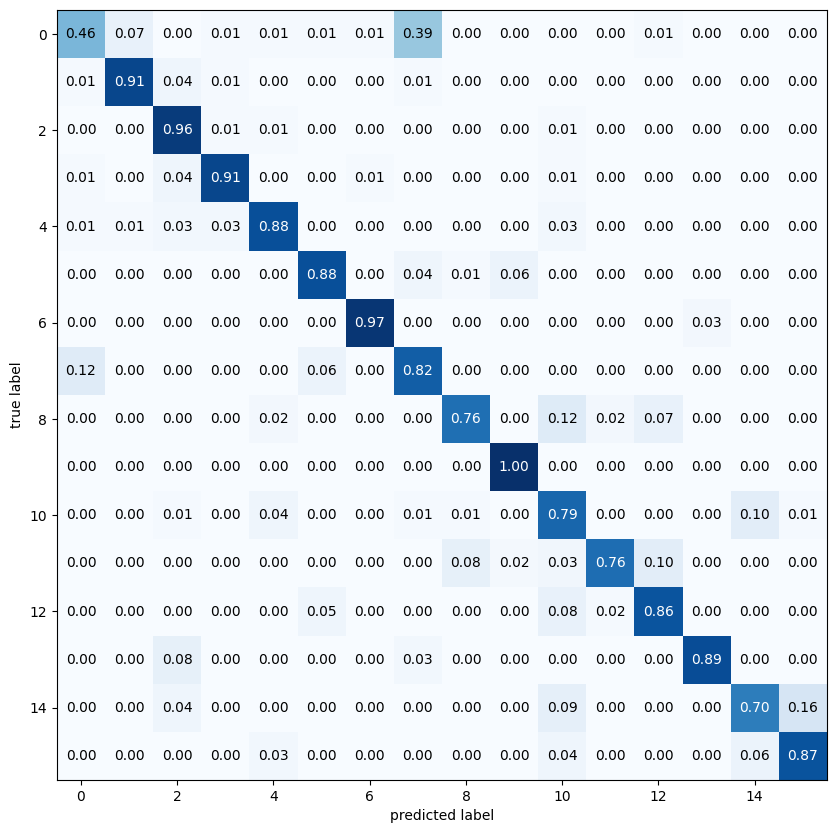

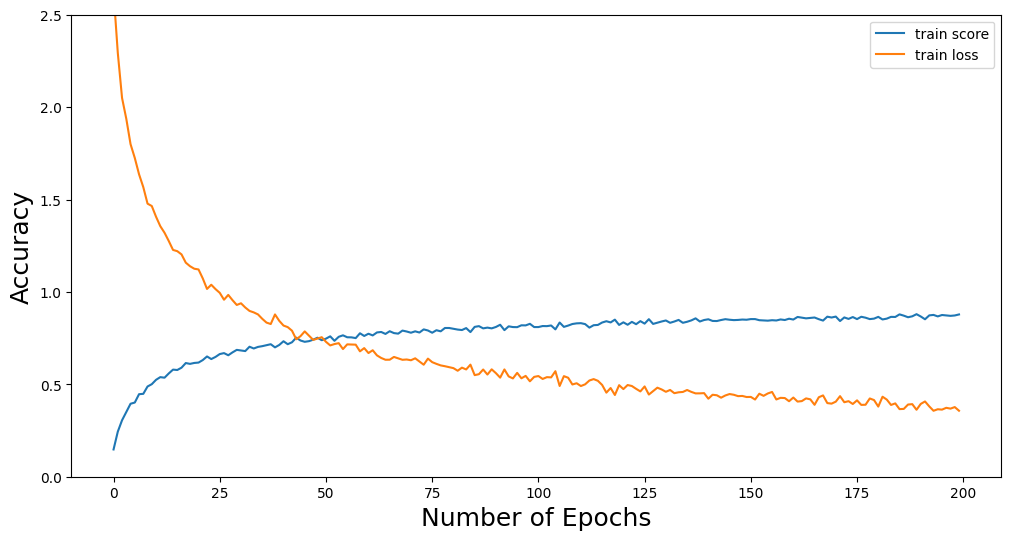

Train Data Shape: (2476, 300, 12)
Test Data Shape: (1222, 300, 12)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 293, 64)   │      6,208 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 31, 64)    │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 31, 64)    │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_5[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_1         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_1[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 31, 65)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_7[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 31, 24)    │      1,584 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 31, 24)    │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 31, 65)    │      1,625 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_5[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_3[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │      2,064 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 188ms/step - accuracy: 0.1051 - loss: 2.8541
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accuracy: 0.1527 - loss: 2.6235
Epoch 3/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.1959 - loss: 2.5230
Epoch 4/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 236ms/step - accuracy: 0.2341 - loss: 2.3186
Epoch 5/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.2663 - loss: 2.2124
Epoch 6/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - accuracy: 0.3074 - loss: 2.0926
Epoch 7/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.3682 - loss: 1.9147
Epoch 8/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - accuracy: 0.3781 - loss: 1.8723
Epoch 9/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.4126 - loss: 1.7855
Epoch 10/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.4541 - loss: 1.7001
Epoch 11/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.4735 - loss: 1.6486
Epoch 12/200
39/39 ━━━━━━━━━━━━━━━━━━━━

39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9509 - loss: 0.1542
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7919 - loss: 0.7021
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
>#2: 
  train accuracy: 0.95598
  train loss    : 0.14285
  test accuracy: 0.80687
  test loss    : 0.65566

Accuracy: 0.80687 (+/-0.00000)
Loss: 0.65566 (+/-0.00000)


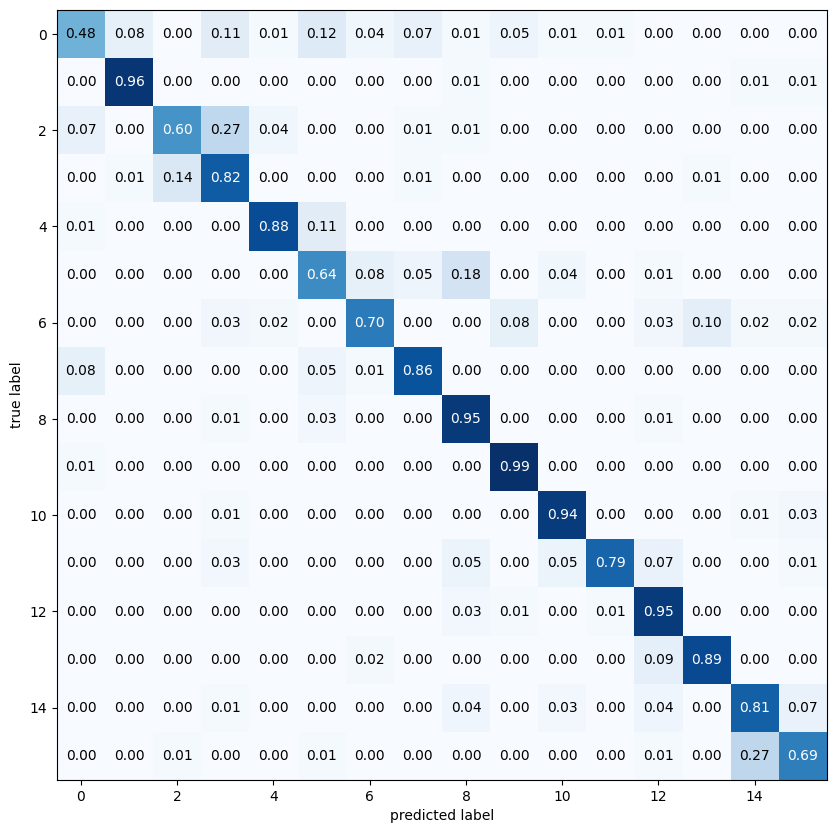

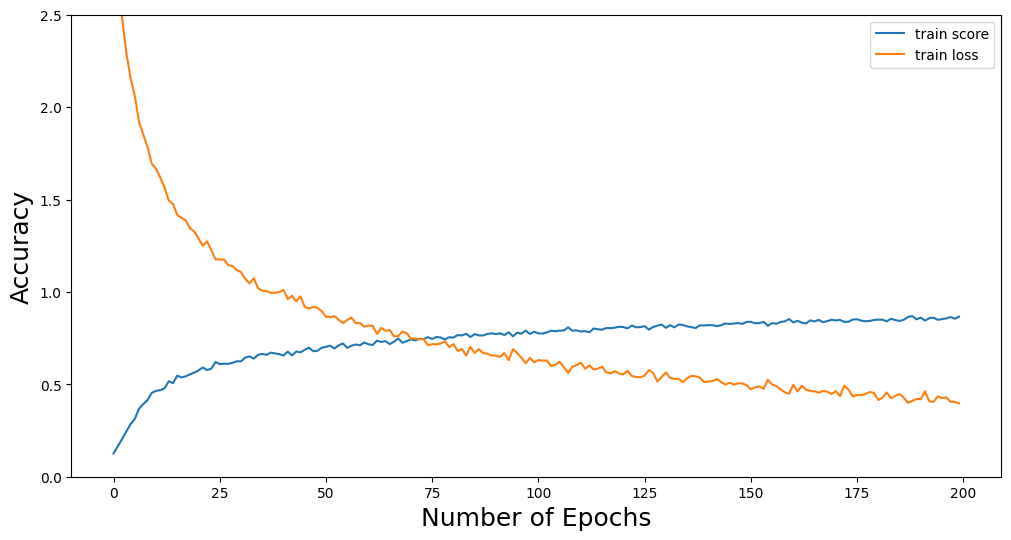

Train Data Shape: (2221, 300, 12)
Test Data Shape: (1099, 300, 12)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 293, 64)   │      6,208 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 31, 64)    │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 31, 64)    │          0 │ max_pooling1d_2[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_10[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_2         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_2[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_12[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 31, 24)    │      1,584 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 31, 24)    │          0 │ conv1d_7[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 31, 65)    │      1,625 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_8[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_5[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 128)       │          0 │ dense_4[0][0]     │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - accuracy: 0.0695 - loss: 2.9759
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - accuracy: 0.1135 - loss: 2.6089
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.1283 - loss: 2.5658
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.1373 - loss: 2.4971
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.1566 - loss: 2.4702
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.1504 - loss: 2.3899
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.1944 - loss: 2.3344
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.2363 - loss: 2.2467
Epoch 9/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - accuracy: 0.2770 - loss: 2.1044
Epoch 10/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.2946 - loss: 2.0164
Epoch 11/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.3572 - loss: 1.8500
Epoch 12/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9405 - loss: 0.1986
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.8142 - loss: 0.6025
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step
>#3: 
  train accuracy: 0.94327
  train loss    : 0.17719
  test accuracy: 0.79891
  test loss    : 0.68694

Accuracy: 0.79891 (+/-0.00000)
Loss: 0.68694 (+/-0.00000)


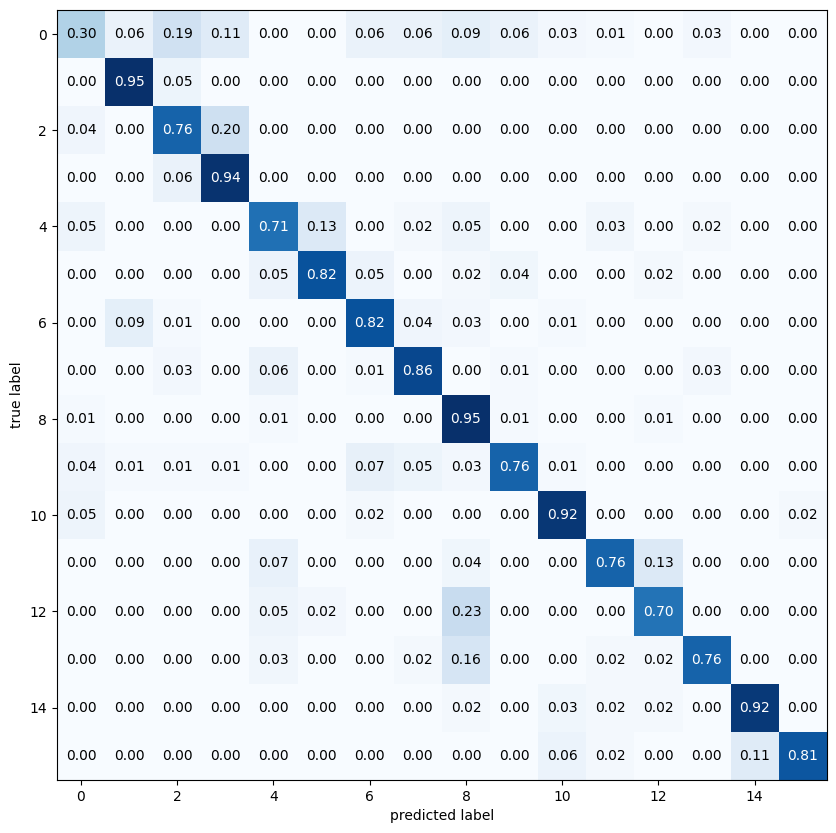

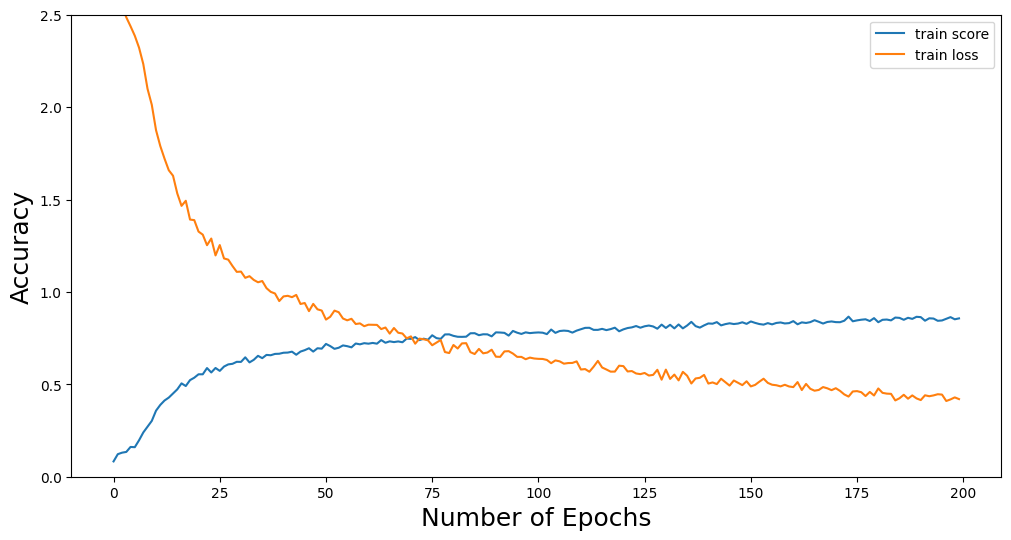

Train Data Shape: (3234, 300, 12)
Test Data Shape: (1412, 300, 12)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 293, 64)   │      6,208 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 31, 64)    │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 31, 64)    │          0 │ max_pooling1d_3[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_15[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_3         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_3[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_17[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 31, 24)    │          0 │ conv1d_10[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_11[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_7[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 128)       │          0 │ dense_6[0][0]     │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 36s 323ms/step - accuracy: 0.0866 - loss: 2.8839
Epoch 2/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 257ms/step - accuracy: 0.1135 - loss: 2.6826
Epoch 3/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 301ms/step - accuracy: 0.1496 - loss: 2.5876
Epoch 4/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 197ms/step - accuracy: 0.1964 - loss: 2.4430
Epoch 5/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.2382 - loss: 2.3190
Epoch 6/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 239ms/step - accuracy: 0.2976 - loss: 2.1567
Epoch 7/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 190ms/step - accuracy: 0.3248 - loss: 2.0394
Epoch 8/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - accuracy: 0.3348 - loss: 1.9604
Epoch 9/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 233ms/step - accuracy: 0.3753 - loss: 1.8383
Epoch 10/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - accuracy: 0.4032 - loss: 1.8040
Epoch 11/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.4118 - loss: 1.7615
Epoch 12/200
51/51 ━━━━━━━━━━━━

51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.8876 - loss: 0.3376
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.7254 - loss: 0.8876
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
>#4: 
  train accuracy: 0.88188
  train loss    : 0.34284
  test accuracy: 0.70042
  test loss    : 0.98038

Accuracy: 0.70042 (+/-0.00000)
Loss: 0.98038 (+/-0.00000)


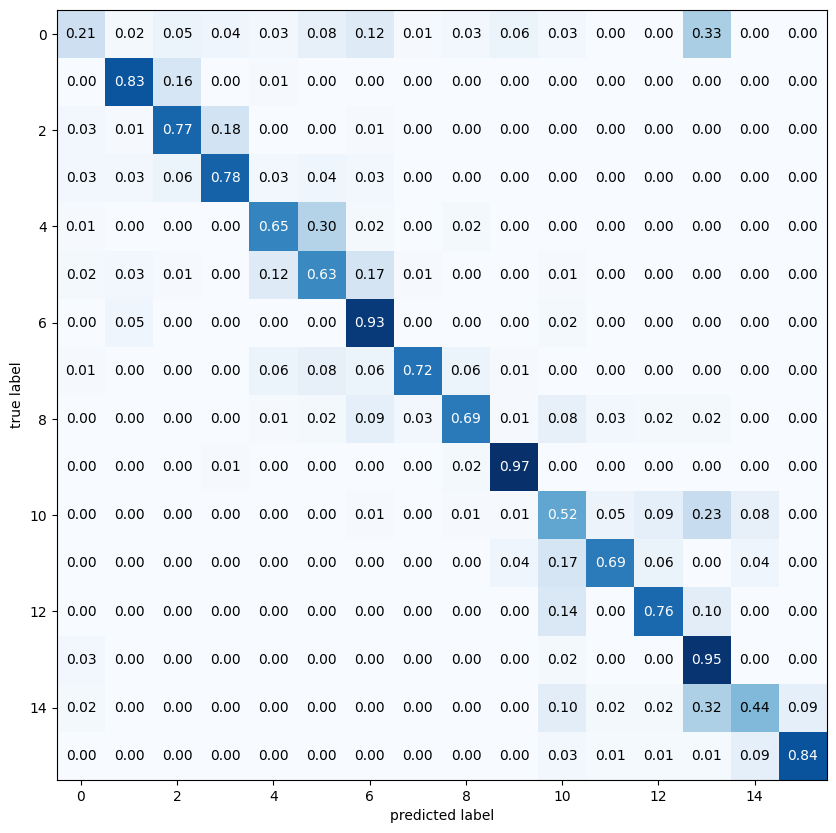

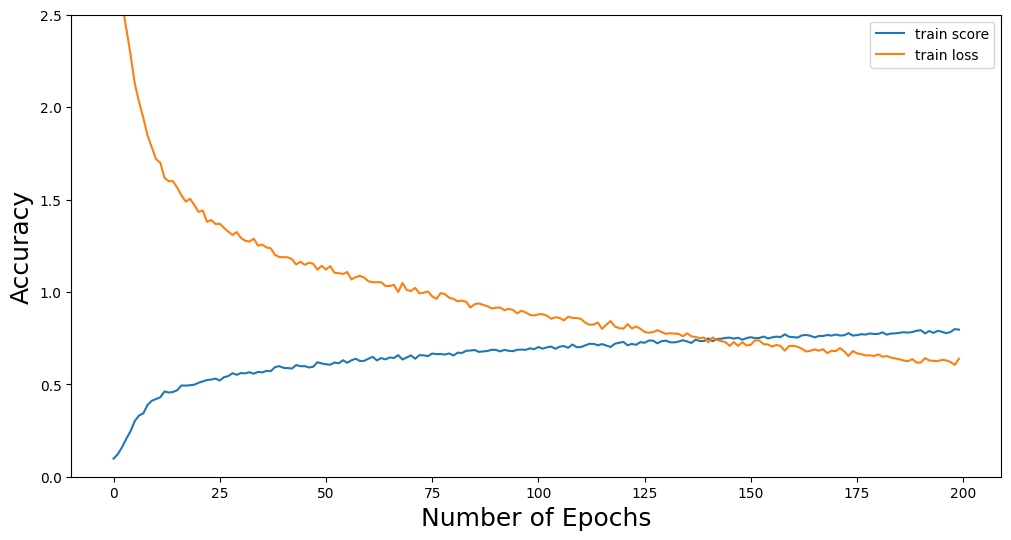

Train Data Shape: (1856, 300, 12)
Test Data Shape: (916, 300, 12)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 31, 64)    │          0 │ conv1d_12[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 31, 64)    │          0 │ max_pooling1d_4[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_20[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_4         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_4[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_22[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 31, 24)    │          0 │ conv1d_13[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_14[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_9[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 128)       │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 214ms/step - accuracy: 0.0713 - loss: 3.0600
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - accuracy: 0.1241 - loss: 2.6887
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - accuracy: 0.1727 - loss: 2.5686
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.1968 - loss: 2.4731
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.2195 - loss: 2.3831
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.2564 - loss: 2.2641
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.2825 - loss: 2.1236
Epoch 8/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.3328 - loss: 2.0036
Epoch 9/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.3497 - loss: 1.9851
Epoch 10/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 0.3779 - loss: 1.8588
Epoch 11/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 260ms/step - accuracy: 0.4054 - loss: 1.7845
Epoch 12/200
29/29 ━━━━━━━━━━━━━━━━━

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.7685 - loss: 0.6137
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.7251 - loss: 0.7543
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step
>#5: 
  train accuracy: 0.83028
  train loss    : 0.43050
  test accuracy: 0.79367
  test loss    : 0.60496

Accuracy: 0.79367 (+/-0.00000)
Loss: 0.60496 (+/-0.00000)


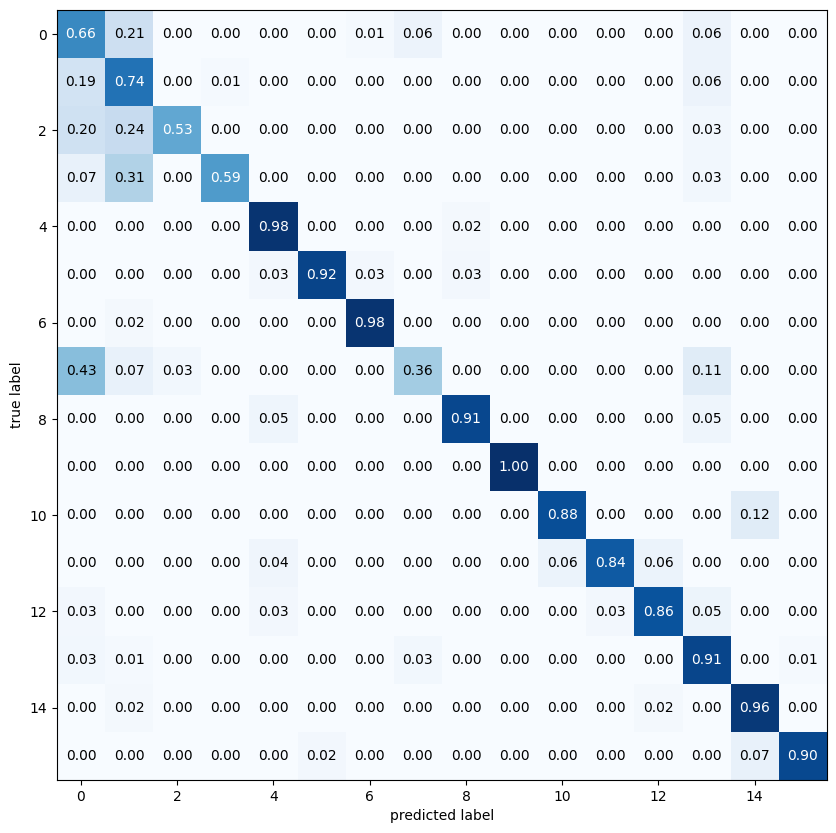

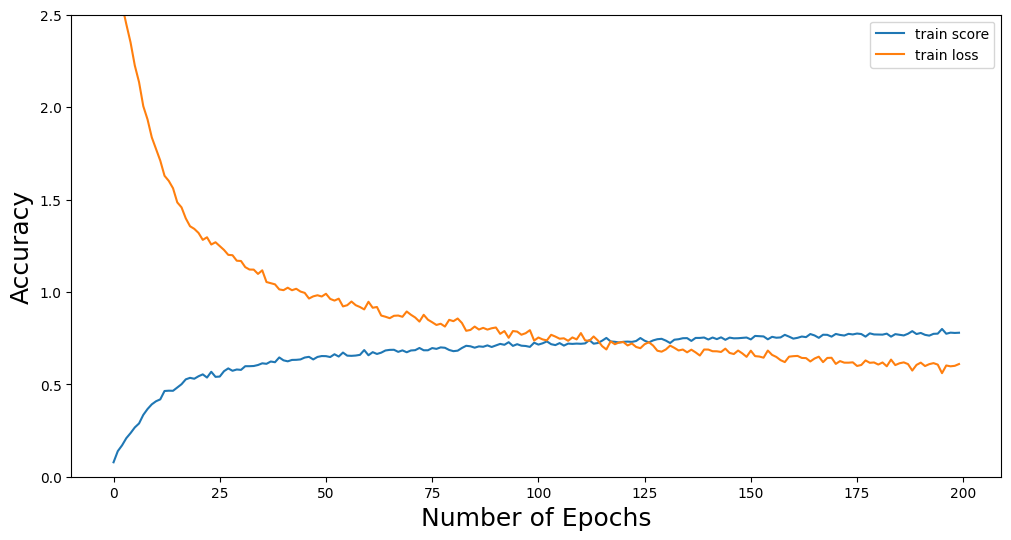

Train Data Shape: (2418, 300, 12)
Test Data Shape: (1142, 300, 12)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 31, 64)    │          0 │ conv1d_15[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 31, 64)    │          0 │ max_pooling1d_5[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_25[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_5         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_5[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_27[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 31, 24)    │          0 │ conv1d_16[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_17[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_11[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 128)       │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 227ms/step - accuracy: 0.0978 - loss: 2.8157
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.1428 - loss: 2.5290
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 270ms/step - accuracy: 0.2042 - loss: 2.4196
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.2550 - loss: 2.2422
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.2836 - loss: 2.1202
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 250ms/step - accuracy: 0.3403 - loss: 1.9838
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.3672 - loss: 1.8823
Epoch 8/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 280ms/step - accuracy: 0.3866 - loss: 1.8426
Epoch 9/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.4107 - loss: 1.7343
Epoch 10/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.4380 - loss: 1.6979
Epoch 11/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - accuracy: 0.4298 - loss: 1.7587
Epoch 12/200
38/38 ━━━━━━━━━━━━━━━━━

38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.8973 - loss: 0.2894
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 421ms/step - accuracy: 0.7549 - loss: 0.7791
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step
>#6: 
  train accuracy: 0.89702
  train loss    : 0.27636
  test accuracy: 0.75131
  test loss    : 0.81550

Accuracy: 0.75131 (+/-0.00000)
Loss: 0.81550 (+/-0.00000)


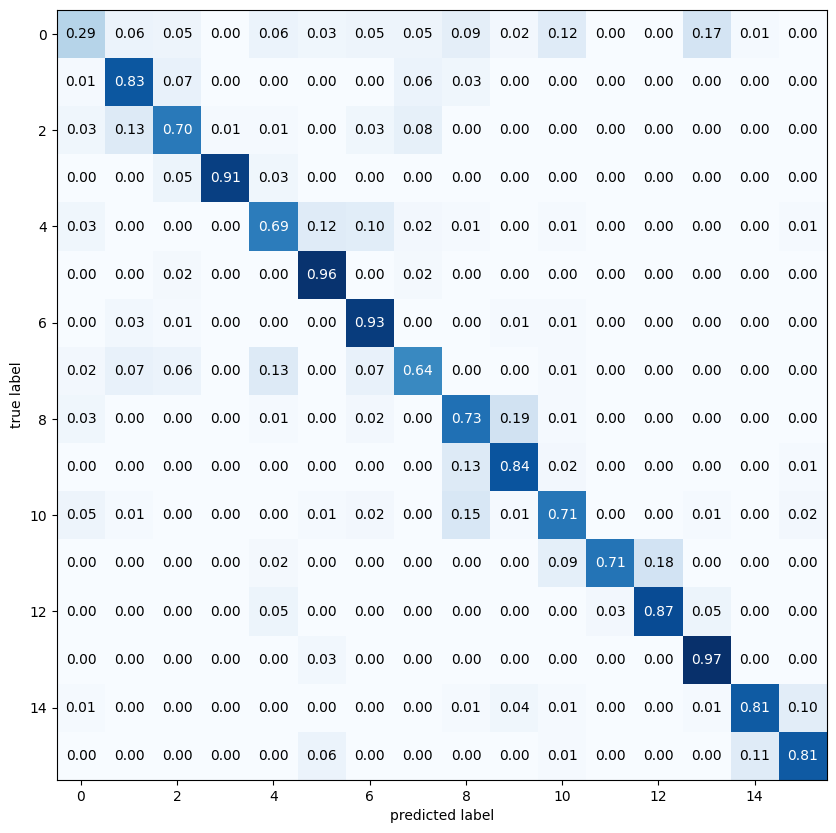

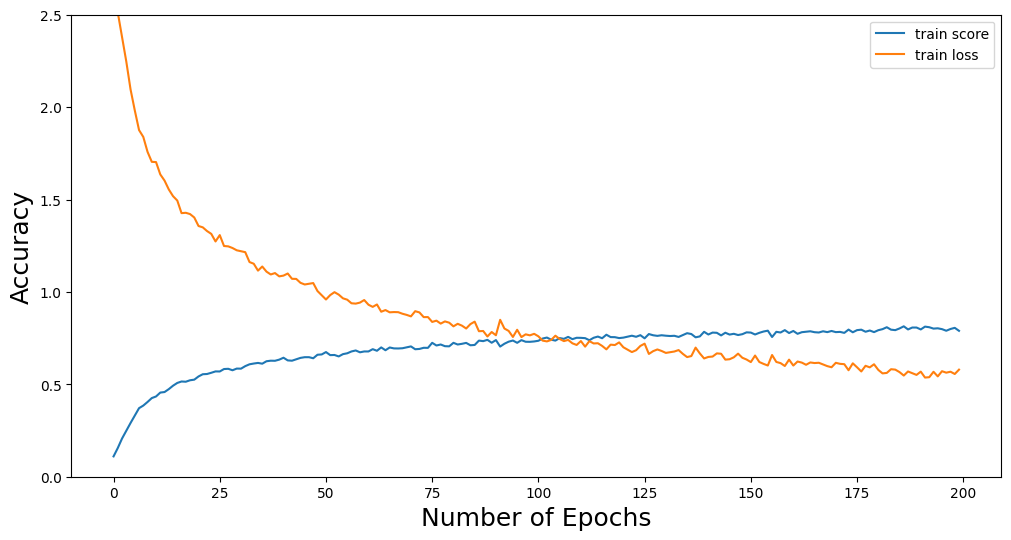

Train Data Shape: (3524, 300, 12)
Test Data Shape: (1842, 300, 12)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 31, 64)    │          0 │ conv1d_18[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 31, 64)    │          0 │ max_pooling1d_6[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_30[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_6         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_6[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_32[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 31, 24)    │          0 │ conv1d_19[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_20[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_13[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 128)       │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 37s 287ms/step - accuracy: 0.0778 - loss: 2.9266
Epoch 2/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step - accuracy: 0.1020 - loss: 2.6736
Epoch 3/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 235ms/step - accuracy: 0.1702 - loss: 2.5156
Epoch 4/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 215ms/step - accuracy: 0.2266 - loss: 2.3319
Epoch 5/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step - accuracy: 0.2473 - loss: 2.2411
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - accuracy: 0.2633 - loss: 2.1232
Epoch 7/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.3067 - loss: 2.0397
Epoch 8/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - accuracy: 0.3169 - loss: 1.9658
Epoch 9/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.3364 - loss: 1.9292
Epoch 10/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.3564 - loss: 1.8556
Epoch 11/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.3702 - loss: 1.8194
Epoch 12/200
56/56 ━━━━━━━━━━━

56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.8475 - loss: 0.4494
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.6371 - loss: 1.0545
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
>#7: 
  train accuracy: 0.88507
  train loss    : 0.35120
  test accuracy: 0.68730
  test loss    : 0.95305

Accuracy: 0.68730 (+/-0.00000)
Loss: 0.95305 (+/-0.00000)


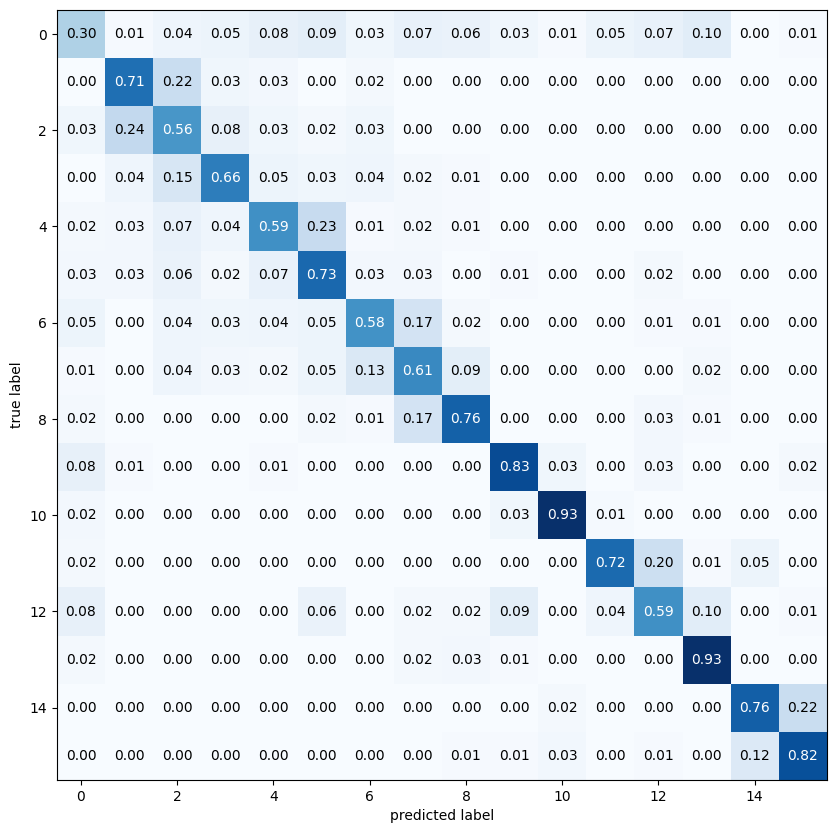

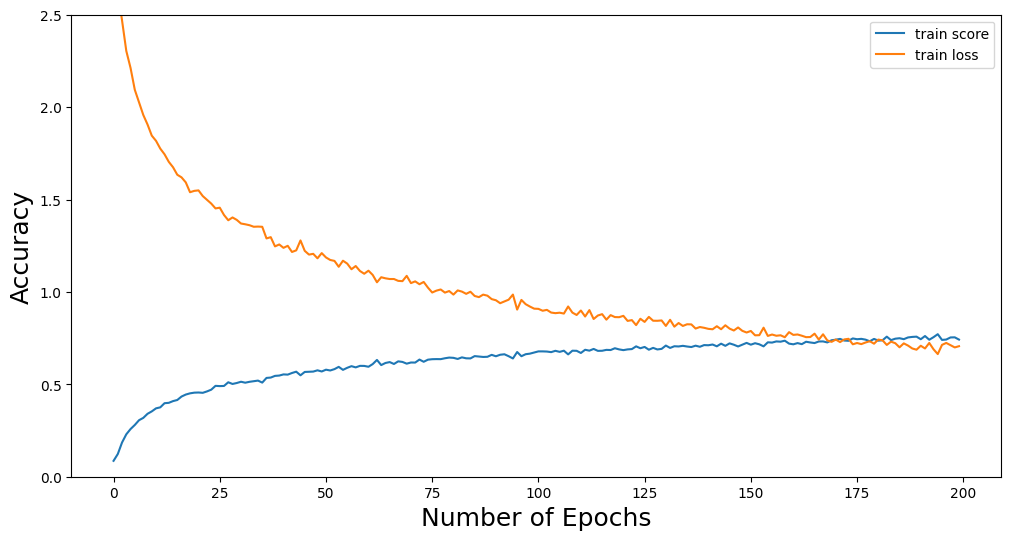

Train Data Shape: (2119, 300, 12)
Test Data Shape: (1070, 300, 12)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 31, 64)    │          0 │ conv1d_21[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 31, 64)    │          0 │ max_pooling1d_7[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_35[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_7         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_7[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_37[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 31, 24)    │          0 │ conv1d_22[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_38[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_23[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_15[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 128)       │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 50s 199ms/step - accuracy: 0.0770 - loss: 2.9495
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 0.1010 - loss: 2.6850
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.1236 - loss: 2.6170
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.1344 - loss: 2.5319
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.1748 - loss: 2.4642
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.2046 - loss: 2.3615
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.2203 - loss: 2.2896
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.2575 - loss: 2.1707
Epoch 9/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.3185 - loss: 1.9742
Epoch 10/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.3645 - loss: 1.8599
Epoch 11/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.3992 - loss: 1.7685
Epoch 12/200
34/34 ━━━━━━━━━━━━━━━━━━━━

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.9653 - loss: 0.1061
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.8824 - loss: 0.4101
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
>#8: 
  train accuracy: 0.96366
  train loss    : 0.11577
  test accuracy: 0.83364
  test loss    : 0.55821

Accuracy: 0.83364 (+/-0.00000)
Loss: 0.55821 (+/-0.00000)


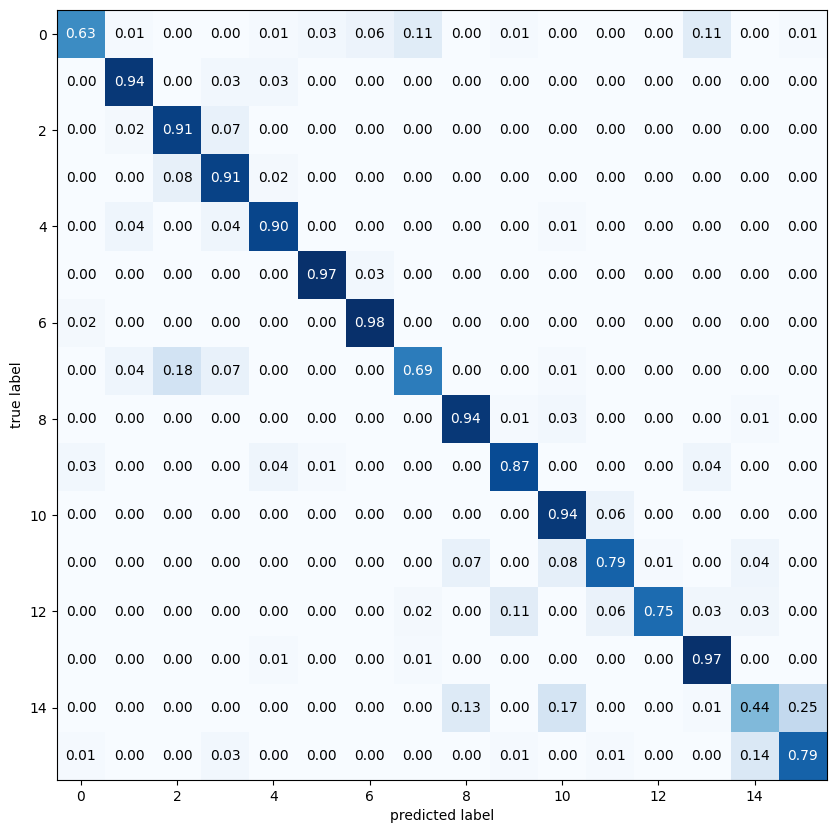

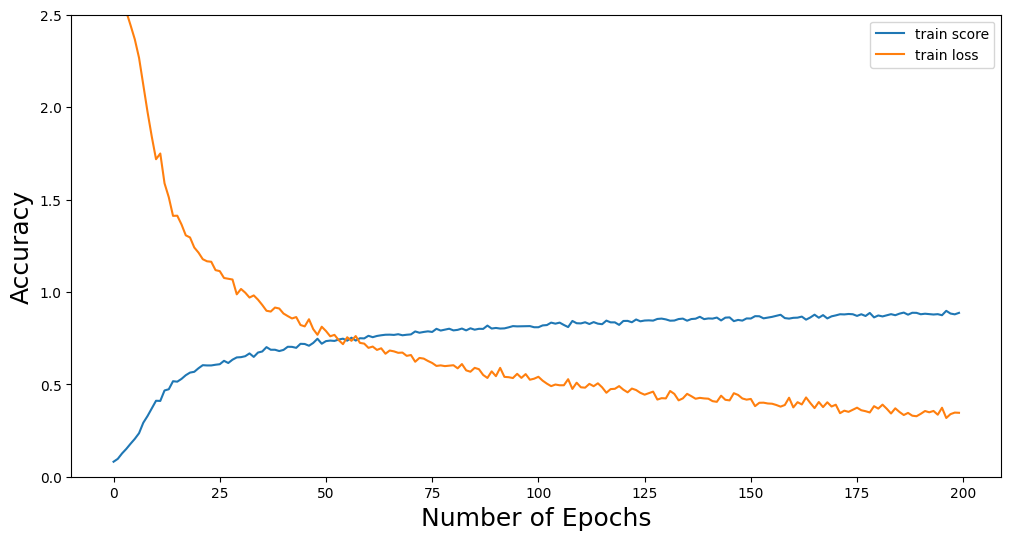

Train Data Shape: (1883, 300, 12)
Test Data Shape: (929, 300, 12)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 31, 64)    │          0 │ conv1d_24[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 31, 64)    │          0 │ max_pooling1d_8[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_40[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_8         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_8[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_42[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 31, 24)    │          0 │ conv1d_25[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_43[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_26[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_17[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 128)       │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - accuracy: 0.0809 - loss: 3.0804
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.1029 - loss: 2.6813
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.1594 - loss: 2.5660
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.1448 - loss: 2.5150
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.1977 - loss: 2.3922
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.2436 - loss: 2.2371
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.3092 - loss: 2.1015
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.3451 - loss: 1.9718
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.3796 - loss: 1.8236
Epoch 10/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.4242 - loss: 1.7176
Epoch 11/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.4359 - loss: 1.6814
Epoch 12/200
30/30 ━━━━━━━━━━━━━━━━━━━━

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9549 - loss: 0.1302
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.8905 - loss: 0.3635
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step
>#9: 
  train accuracy: 0.96495
  train loss    : 0.11393
  test accuracy: 0.84392
  test loss    : 0.51687

Accuracy: 0.84392 (+/-0.00000)
Loss: 0.51687 (+/-0.00000)


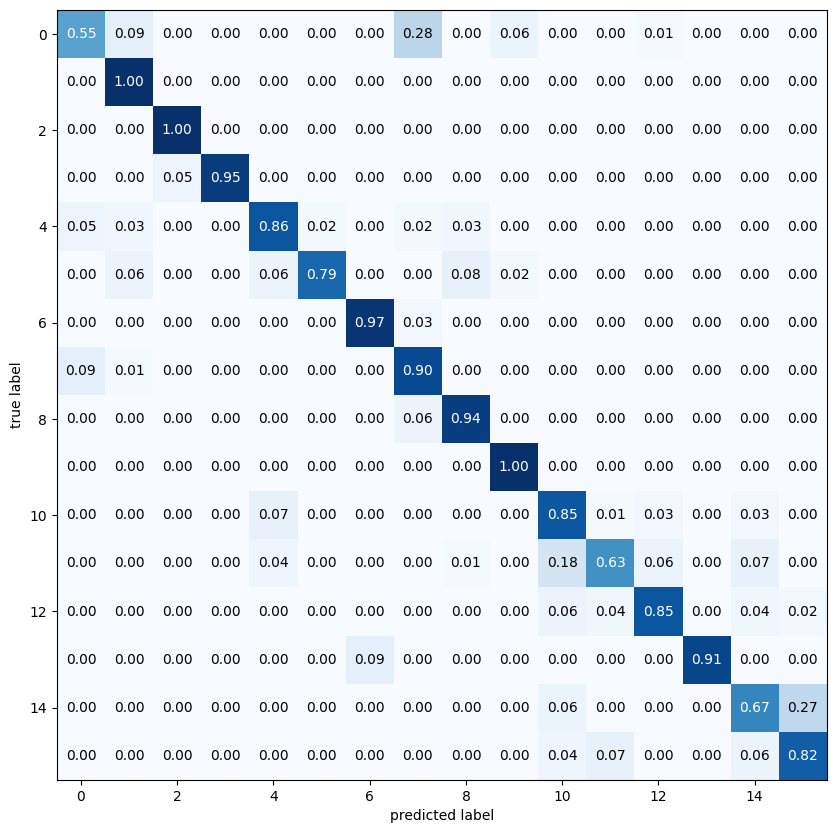

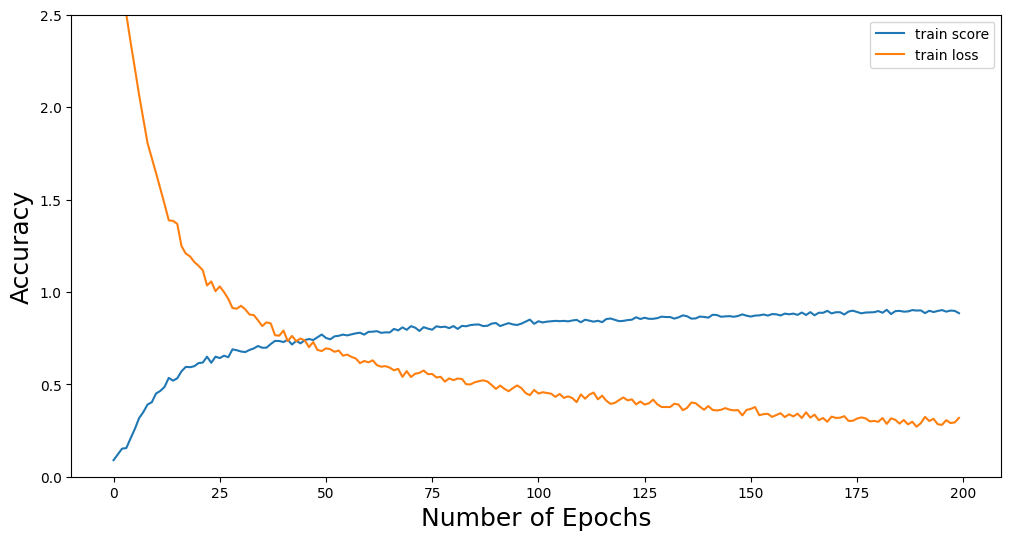

Train Data Shape: (2135, 300, 12)
Test Data Shape: (1026, 300, 12)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 31, 64)    │          0 │ conv1d_27[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 31, 64)    │          0 │ max_pooling1d_9[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_45[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_9         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_9[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_47[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 31, 24)    │          0 │ conv1d_28[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_48[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_29[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_19[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, 128)       │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 233ms/step - accuracy: 0.1228 - loss: 2.7952
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 265ms/step - accuracy: 0.2527 - loss: 2.3135
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.3646 - loss: 2.0067
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - accuracy: 0.4083 - loss: 1.8075
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.4594 - loss: 1.6621
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.4939 - loss: 1.5409
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.5396 - loss: 1.4294
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 253ms/step - accuracy: 0.5356 - loss: 1.4137
Epoch 9/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.5483 - loss: 1.3156
Epoch 10/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - accuracy: 0.5647 - loss: 1.2979
Epoch 11/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 218ms/step - accuracy: 0.5902 - loss: 1.2589
Epoch 12/200
34/34 ━━━━━━━━━━━━━━━━━━

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.9648 - loss: 0.1141
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8282 - loss: 0.5895
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step
>#10: 
  train accuracy: 0.96159
  train loss    : 0.11934
  test accuracy: 0.81969
  test loss    : 0.77101

Accuracy: 0.81969 (+/-0.00000)
Loss: 0.77101 (+/-0.00000)


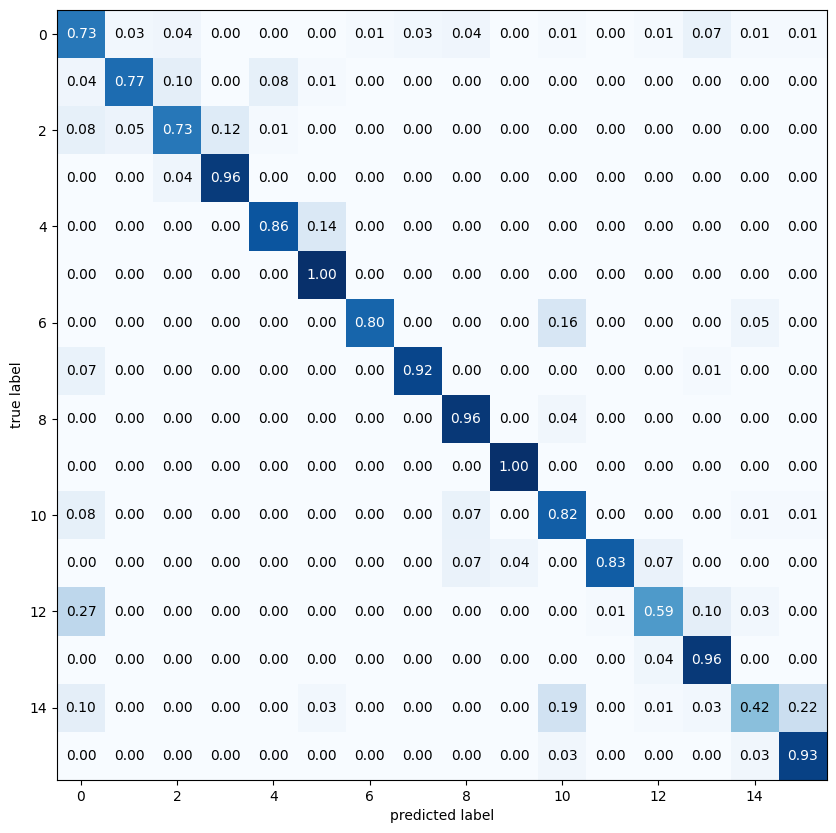

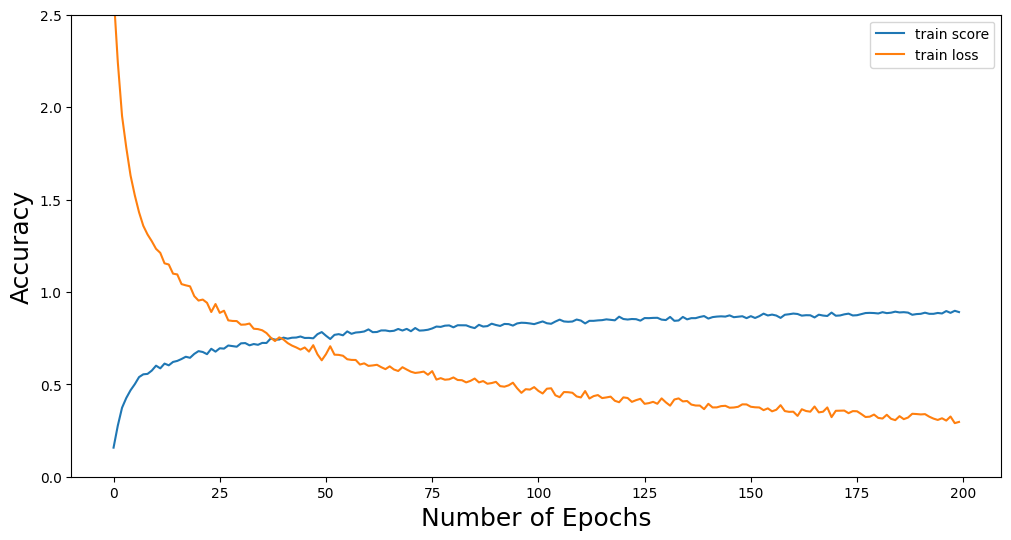

Train Data Shape: (4018, 300, 12)
Test Data Shape: (2014, 300, 12)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 31, 64)    │          0 │ conv1d_30[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 31, 64)    │          0 │ max_pooling1d_10… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_50[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_10        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_10[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_52[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 31, 24)    │          0 │ conv1d_31[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_53[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_32[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_21[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_54          │ (None, 128)       │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 239ms/step - accuracy: 0.0726 - loss: 2.8811
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - accuracy: 0.1009 - loss: 2.7214
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - accuracy: 0.1269 - loss: 2.6705
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - accuracy: 0.1811 - loss: 2.5434
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.2056 - loss: 2.4522
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step - accuracy: 0.2536 - loss: 2.3221
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 204ms/step - accuracy: 0.2846 - loss: 2.2174
Epoch 8/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.3336 - loss: 2.0602
Epoch 9/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.3506 - loss: 1.9815
Epoch 10/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.3541 - loss: 1.9454
Epoch 11/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - accuracy: 0.3744 - loss: 1.8745
Epoch 12/200
63/63 ━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.8805 - loss: 0.3890
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.6736 - loss: 1.0971
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step
>#11: 
  train accuracy: 0.88278
  train loss    : 0.38428
  test accuracy: 0.68818
  test loss    : 1.05435

Accuracy: 0.68818 (+/-0.00000)
Loss: 1.05435 (+/-0.00000)


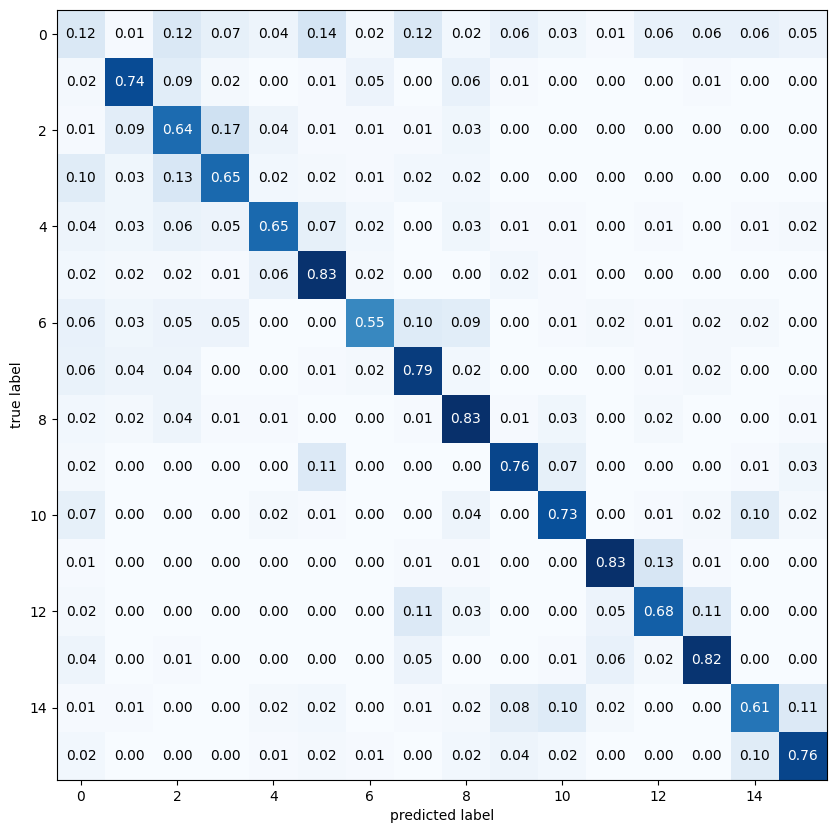

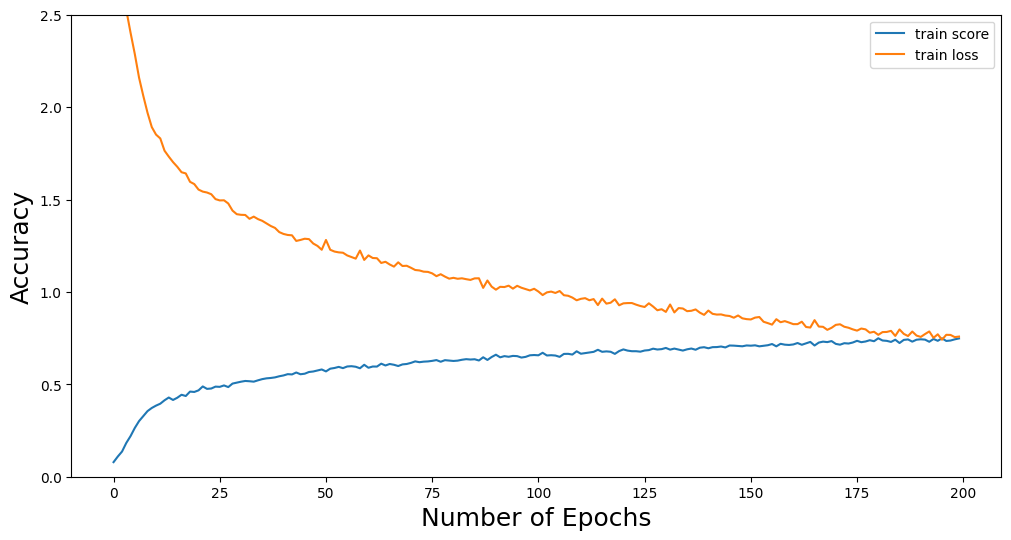

Train Data Shape: (2334, 300, 12)
Test Data Shape: (1223, 300, 12)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 31, 64)    │          0 │ conv1d_33[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_55          │ (None, 31, 64)    │          0 │ max_pooling1d_11… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_55[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_11        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_11[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_11[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_57          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_57[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_22 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_11[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_22[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_58          │ (None, 31, 24)    │          0 │ conv1d_34[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_58[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_35[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_23 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_22[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_23[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_59          │ (None, 128)       │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 205ms/step - accuracy: 0.0637 - loss: 2.8881
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - accuracy: 0.1158 - loss: 2.6509
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.1534 - loss: 2.5533
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 253ms/step - accuracy: 0.2107 - loss: 2.4131
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - accuracy: 0.2719 - loss: 2.1718
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - accuracy: 0.3108 - loss: 2.0197
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.3400 - loss: 1.8958
Epoch 8/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.3858 - loss: 1.7683
Epoch 9/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.4175 - loss: 1.6578
Epoch 10/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.4633 - loss: 1.6001
Epoch 11/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.4812 - loss: 1.5185
Epoch 12/200
37/37 ━━━━━━━━━━━━━━━━

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.9162 - loss: 0.2479
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.8002 - loss: 0.6411
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
>#12: 
  train accuracy: 0.91431
  train loss    : 0.25122
  test accuracy: 0.77105
  test loss    : 0.80691

Accuracy: 0.77105 (+/-0.00000)
Loss: 0.80691 (+/-0.00000)


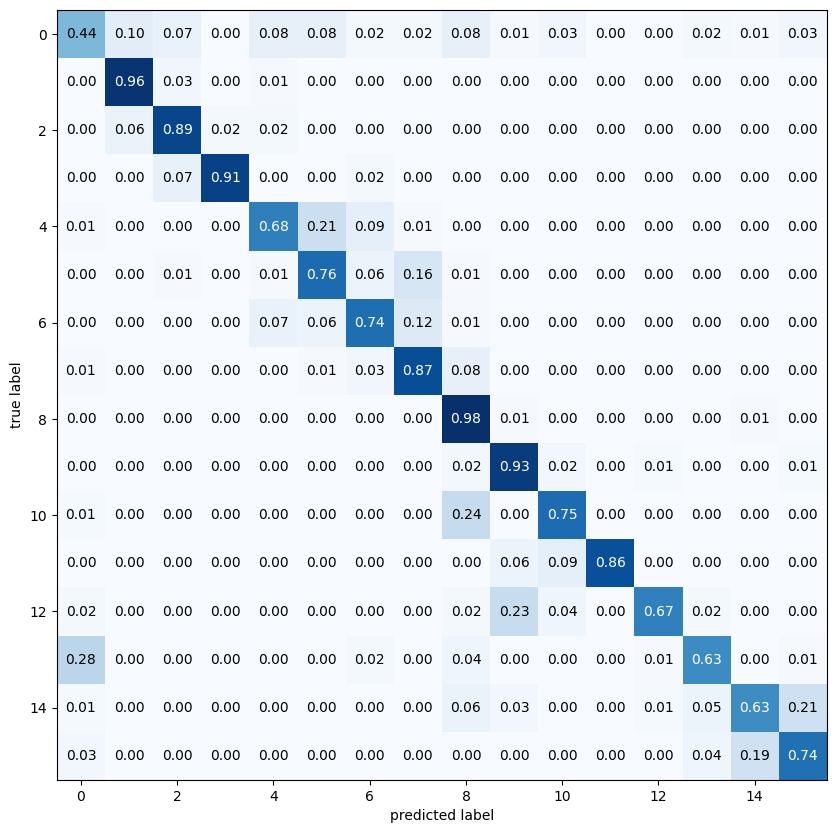

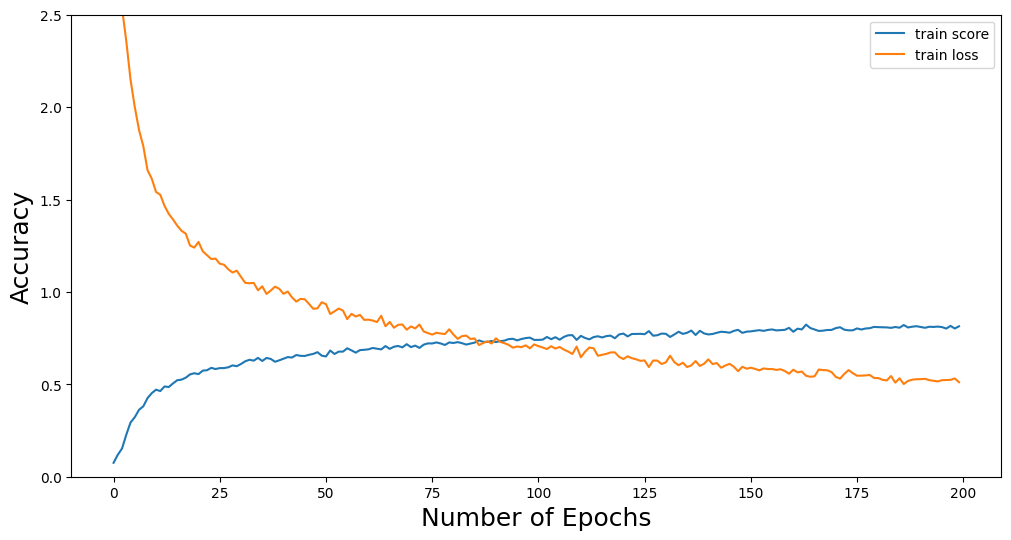

Train Data Shape: (2147, 300, 12)
Test Data Shape: (1000, 300, 12)


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 31, 64)    │          0 │ conv1d_36[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_60          │ (None, 31, 64)    │          0 │ max_pooling1d_12… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_60[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_12        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_12[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_12[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_62          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_62[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_12[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_24[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_63          │ (None, 31, 24)    │          0 │ conv1d_37[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_63[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_38[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_24[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_25[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_64          │ (None, 128)       │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 206ms/step - accuracy: 0.0811 - loss: 2.9478
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step - accuracy: 0.0973 - loss: 2.7239
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 211ms/step - accuracy: 0.1325 - loss: 2.6358
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - accuracy: 0.1524 - loss: 2.5598
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.1610 - loss: 2.5159
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.1891 - loss: 2.4448
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.1993 - loss: 2.4096
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - accuracy: 0.2190 - loss: 2.3534
Epoch 9/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.2574 - loss: 2.2713
Epoch 10/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - accuracy: 0.2829 - loss: 2.2275
Epoch 11/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - accuracy: 0.3011 - loss: 2.1132
Epoch 12/200
34/34 ━━━━━━━━━━━━━━━━━

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9383 - loss: 0.1826
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.7734 - loss: 1.0765
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step
>#13: 
  train accuracy: 0.94131
  train loss    : 0.17850
  test accuracy: 0.80300
  test loss    : 0.80271

Accuracy: 0.80300 (+/-0.00000)
Loss: 0.80271 (+/-0.00000)


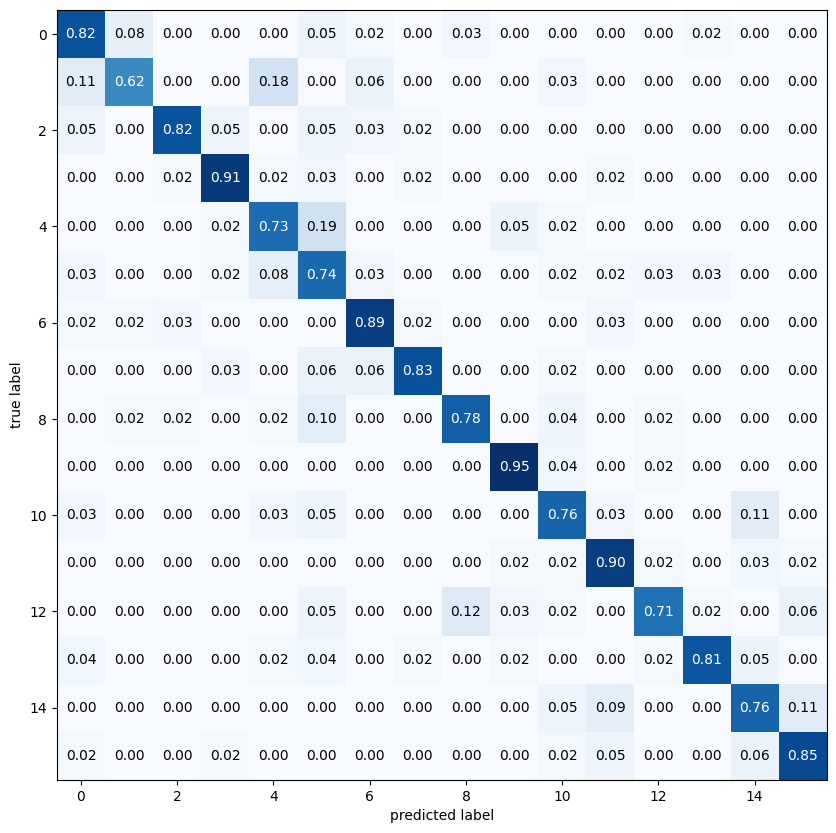

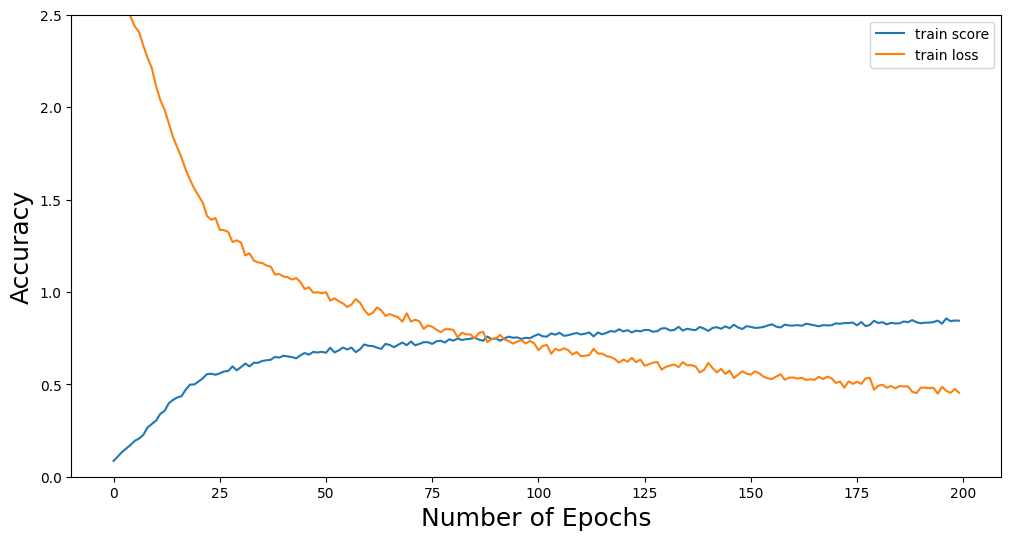

Train Data Shape: (2484, 300, 12)
Test Data Shape: (1184, 300, 12)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 31, 64)    │          0 │ conv1d_39[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_65          │ (None, 31, 64)    │          0 │ max_pooling1d_13… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_65[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_13        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_13[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_13[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_67          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_67[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_13[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_26[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_68          │ (None, 31, 24)    │          0 │ conv1d_40[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_68[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_41[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_26[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_27[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_69          │ (None, 128)       │          0 │ dense_26[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - accuracy: 0.0906 - loss: 2.8203
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.1237 - loss: 2.5729
Epoch 3/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - accuracy: 0.1457 - loss: 2.4793
Epoch 4/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - accuracy: 0.1790 - loss: 2.3693
Epoch 5/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.2555 - loss: 2.2208
Epoch 6/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.2830 - loss: 2.1109
Epoch 7/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 232ms/step - accuracy: 0.3139 - loss: 1.9987
Epoch 8/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - accuracy: 0.3173 - loss: 1.9803
Epoch 9/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.3687 - loss: 1.8821
Epoch 10/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.3827 - loss: 1.8261
Epoch 11/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step - accuracy: 0.3911 - loss: 1.7622
Epoch 12/200
39/39 ━━━━━━━━━━━━━━━

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.8137 - loss: 0.5443
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6599 - loss: 0.9853
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
>#14: 
  train accuracy: 0.83052
  train loss    : 0.47948
  test accuracy: 0.67905
  test loss    : 0.94232

Accuracy: 0.67905 (+/-0.00000)
Loss: 0.94232 (+/-0.00000)


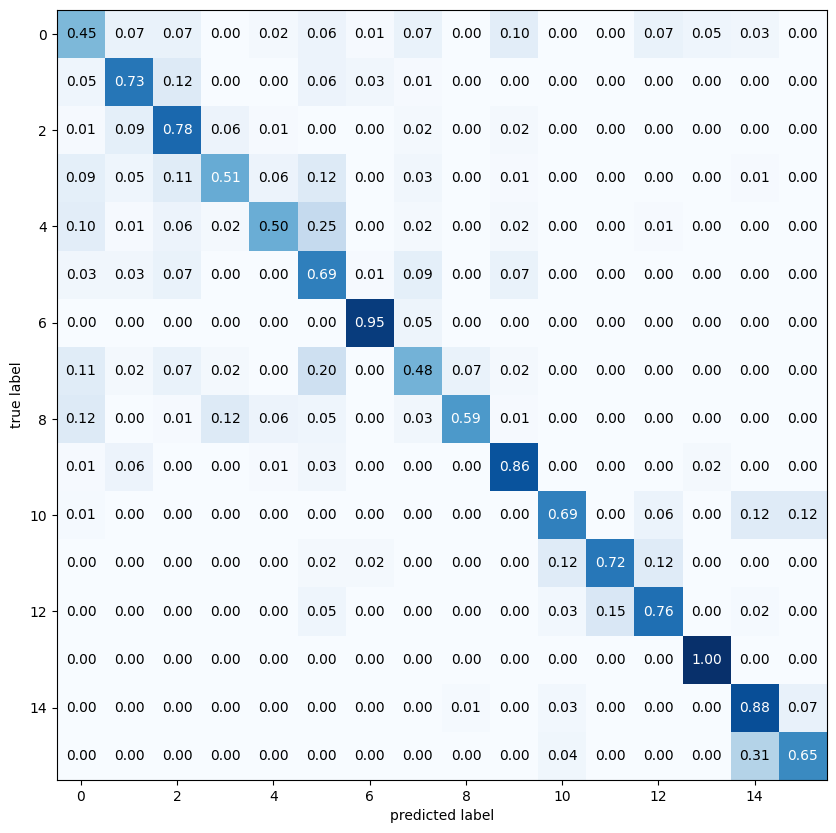

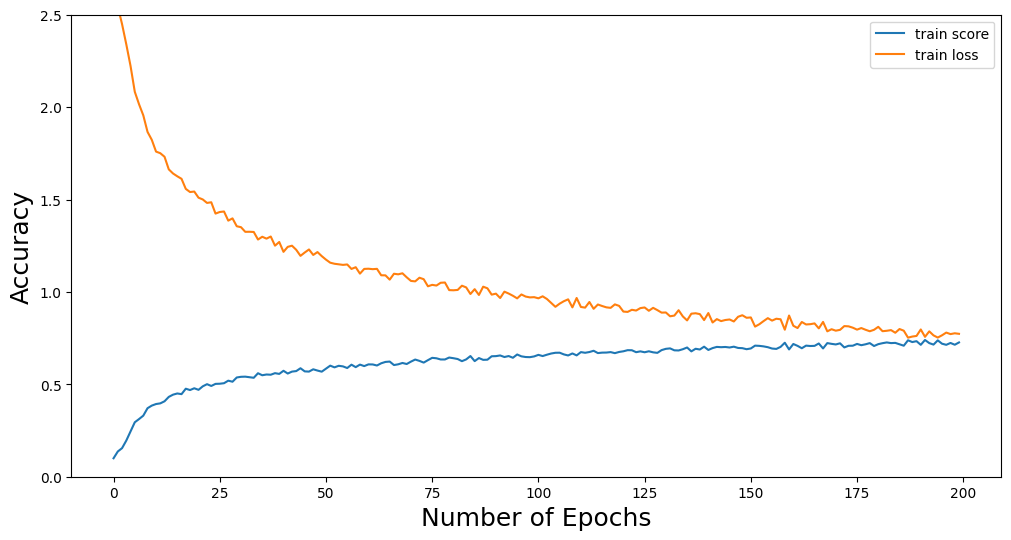

Train Data Shape: (2021, 300, 12)
Test Data Shape: (971, 300, 12)


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 31, 64)    │          0 │ conv1d_42[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_70          │ (None, 31, 64)    │          0 │ max_pooling1d_14… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_70[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_14        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_14[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_72          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_72[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_28[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_73          │ (None, 31, 24)    │          0 │ conv1d_43[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_73[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_44[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_29 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_28[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_29[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_74          │ (None, 128)       │          0 │ dense_28[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 197ms/step - accuracy: 0.0767 - loss: 2.8324
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.1725 - loss: 2.5436
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.1996 - loss: 2.4100
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.2082 - loss: 2.3444
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.2199 - loss: 2.2802
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.2406 - loss: 2.2132
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.2604 - loss: 2.1477
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.3243 - loss: 1.9862
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - accuracy: 0.3506 - loss: 1.9381
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.3653 - loss: 1.8366
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.3975 - loss: 1.7479
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.8858 - loss: 0.3030
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.7942 - loss: 0.6226
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
>#15: 
  train accuracy: 0.92133
  train loss    : 0.21926
  test accuracy: 0.81050
  test loss    : 0.61725

Accuracy: 0.81050 (+/-0.00000)
Loss: 0.61725 (+/-0.00000)


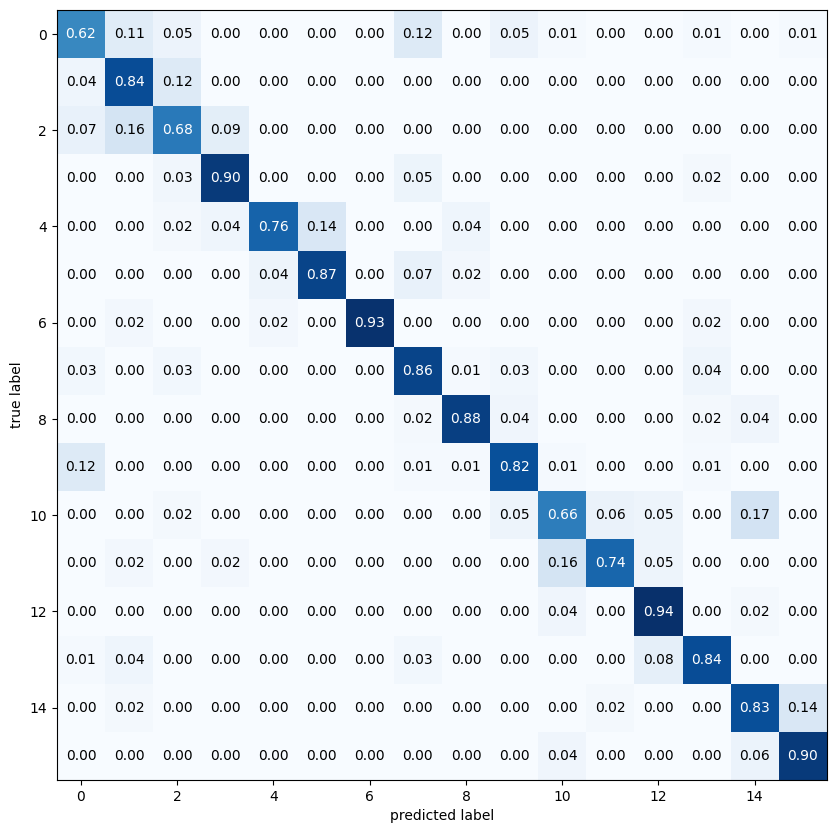

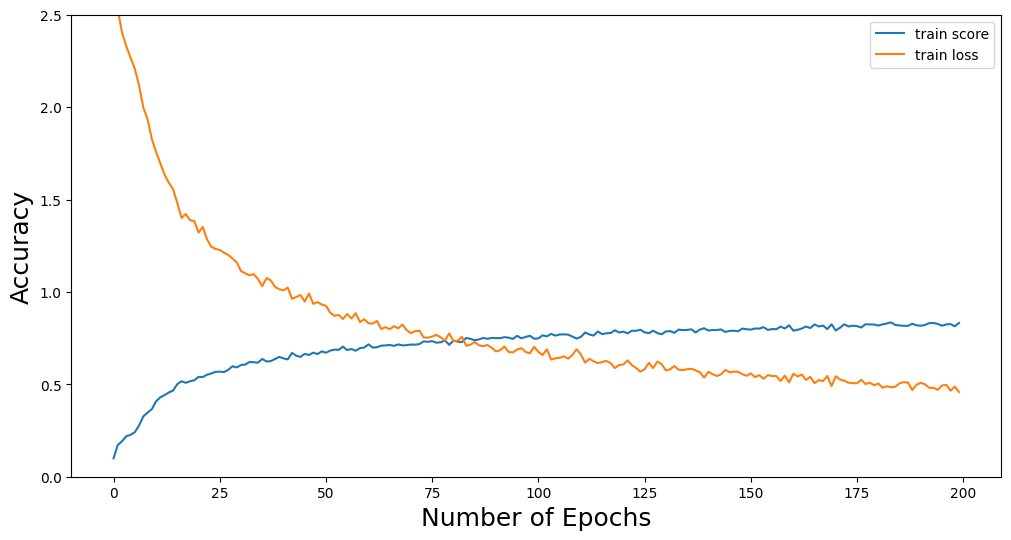

Train Data Shape: (2030, 300, 12)
Test Data Shape: (908, 300, 12)


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 31, 64)    │          0 │ conv1d_45[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_75          │ (None, 31, 64)    │          0 │ max_pooling1d_15… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_75[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_15        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_15[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_15[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_77          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_77[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_30 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_15[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_46 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_30[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_78          │ (None, 31, 24)    │          0 │ conv1d_46[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_47 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_78[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_47[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_31 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_30[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_31[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_79          │ (None, 128)       │          0 │ dense_30[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - accuracy: 0.1124 - loss: 2.8833
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - accuracy: 0.1710 - loss: 2.5429
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.2258 - loss: 2.4118
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.2864 - loss: 2.2483
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.3546 - loss: 2.0728
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.3911 - loss: 1.9505
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.4149 - loss: 1.8623
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.4434 - loss: 1.7266
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.4779 - loss: 1.6852
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step - accuracy: 0.4724 - loss: 1.6100
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.4875 - loss: 1.5624
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9513 - loss: 0.1499
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7805 - loss: 0.7879
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
>#16: 
  train accuracy: 0.95714
  train loss    : 0.14510
  test accuracy: 0.73458
  test loss    : 0.86687

Accuracy: 0.73458 (+/-0.00000)
Loss: 0.86687 (+/-0.00000)


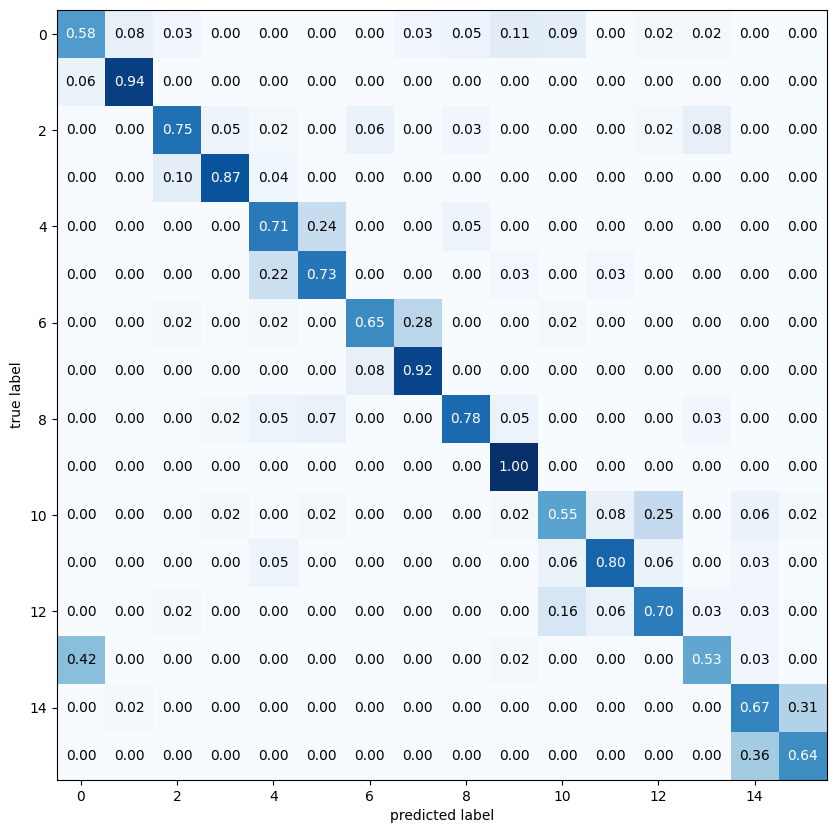

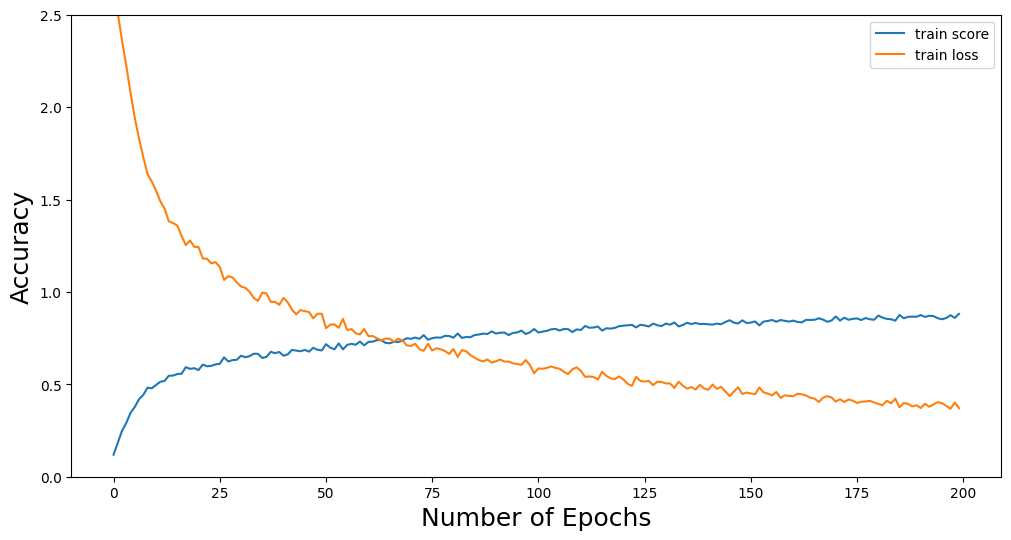

Train Data Shape: (3156, 300, 12)
Test Data Shape: (1559, 300, 12)


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_48 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 31, 64)    │          0 │ conv1d_48[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_80          │ (None, 31, 64)    │          0 │ max_pooling1d_16… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_80[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_16        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_16[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_16[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_82          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_82[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_16[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_49 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_32[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_83          │ (None, 31, 24)    │          0 │ conv1d_49[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_50 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_83[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_50[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_33 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_32[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_33[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_84          │ (None, 128)       │          0 │ dense_32[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 190ms/step - accuracy: 0.0720 - loss: 2.9225
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.1325 - loss: 2.6383
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.2078 - loss: 2.4957
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.2177 - loss: 2.3920
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.2706 - loss: 2.2603
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.3144 - loss: 2.1402
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.3596 - loss: 1.9859
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.4002 - loss: 1.8655
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 0.4491 - loss: 1.7006
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 0.4564 - loss: 1.6652
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 0.4856 - loss: 1.5603
Epoch 12/200
50/50 ━━━━━━━━━━━━━━━━

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.9180 - loss: 0.2272
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8259 - loss: 0.5787
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
>#17: 
  train accuracy: 0.92142
  train loss    : 0.22617
  test accuracy: 0.80180
  test loss    : 0.61163

Accuracy: 0.80180 (+/-0.00000)
Loss: 0.61163 (+/-0.00000)


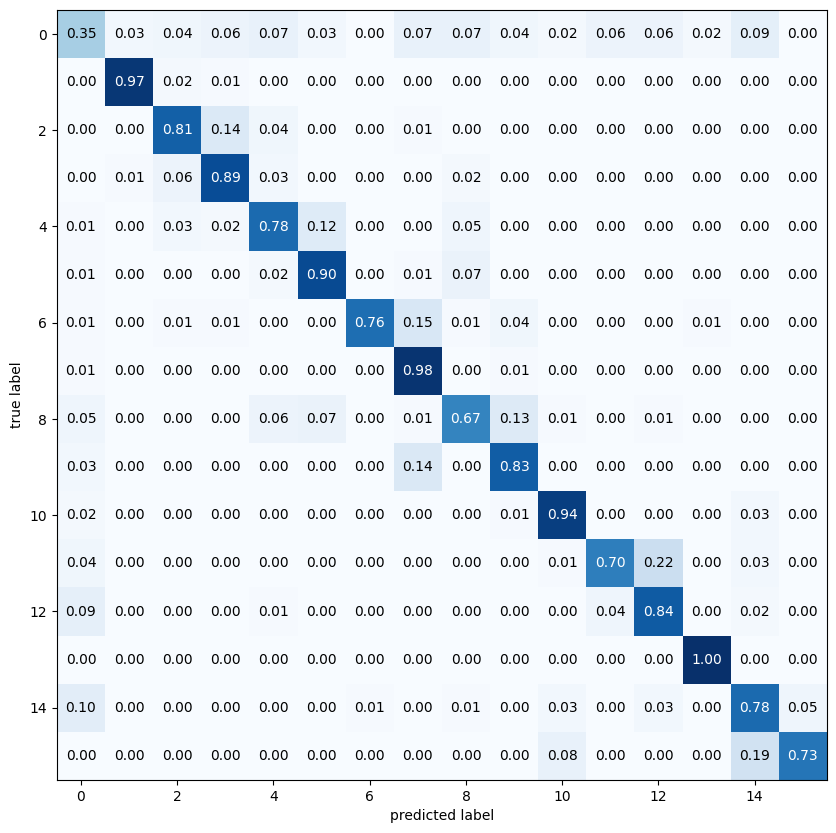

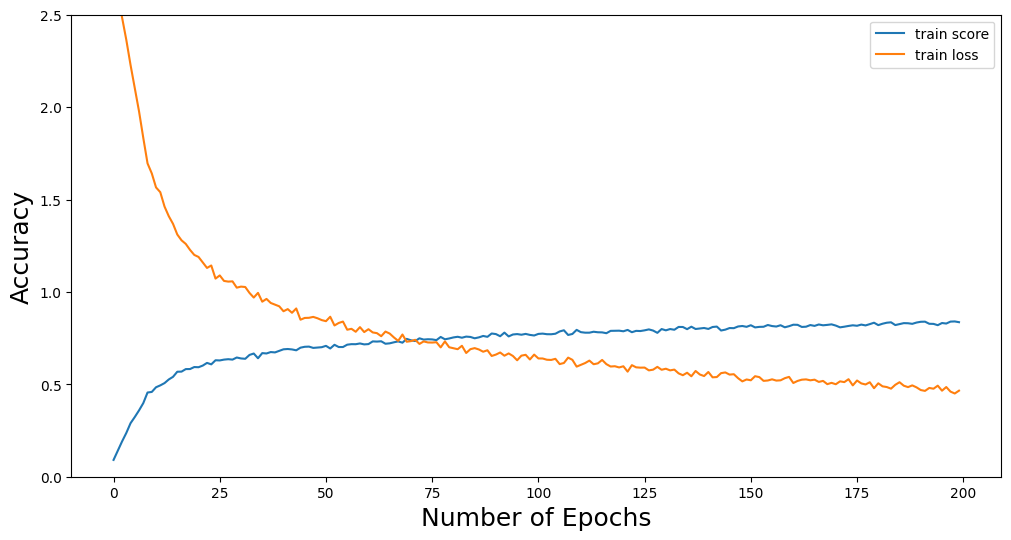

Train Data Shape: (2679, 300, 12)
Test Data Shape: (1244, 300, 12)


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_51 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 31, 64)    │          0 │ conv1d_51[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_85          │ (None, 31, 64)    │          0 │ max_pooling1d_17… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_85[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_17        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_17[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_17[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_87          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_87[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_34 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_17[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_52 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_34[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_88          │ (None, 31, 24)    │          0 │ conv1d_52[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_53 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_88[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_53[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_35 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_34[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_35[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_89          │ (None, 128)       │          0 │ dense_34[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 232ms/step - accuracy: 0.0835 - loss: 2.9321
Epoch 2/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.1328 - loss: 2.6415
Epoch 3/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.1759 - loss: 2.5271
Epoch 4/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - accuracy: 0.1996 - loss: 2.4128
Epoch 5/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.2495 - loss: 2.2572
Epoch 6/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.3046 - loss: 2.0798
Epoch 7/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 227ms/step - accuracy: 0.3226 - loss: 2.0046
Epoch 8/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.3567 - loss: 1.9189
Epoch 9/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 249ms/step - accuracy: 0.3564 - loss: 1.9092
Epoch 10/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step - accuracy: 0.3768 - loss: 1.7671
Epoch 11/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.4120 - loss: 1.7248
Epoch 12/200
42/42 ━━━━━━━━━━━━━━

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.8960 - loss: 0.3086
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7522 - loss: 0.7948
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
>#18: 
  train accuracy: 0.90071
  train loss    : 0.29527
  test accuracy: 0.72990
  test loss    : 0.90677

Accuracy: 0.72990 (+/-0.00000)
Loss: 0.90677 (+/-0.00000)


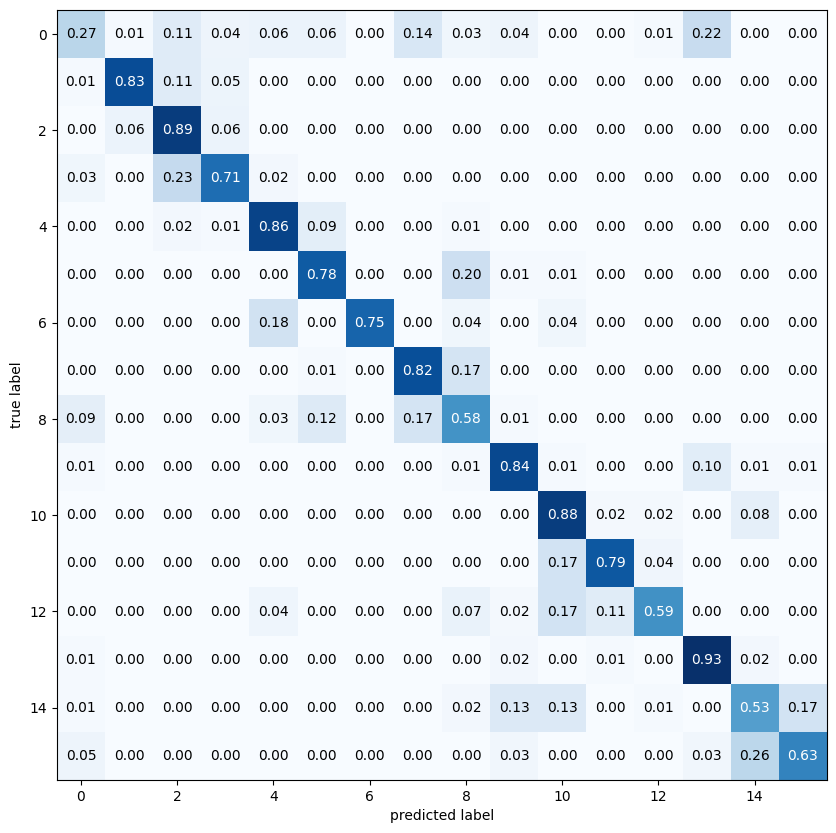

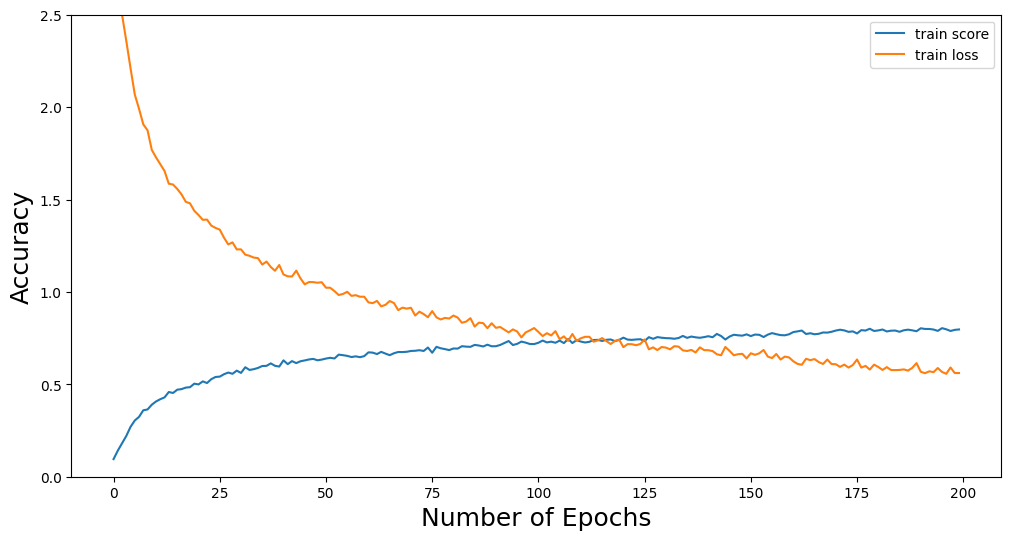

Train Data Shape: (2744, 300, 12)
Test Data Shape: (1421, 300, 12)


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_54 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 31, 64)    │          0 │ conv1d_54[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_90          │ (None, 31, 64)    │          0 │ max_pooling1d_18… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_90[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_18        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_18[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_18[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_92          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_92[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_18[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_55 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_36[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_93          │ (None, 31, 24)    │          0 │ conv1d_55[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_56 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_93[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_56[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_37 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_36[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_37[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_94          │ (None, 128)       │          0 │ dense_36[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 193ms/step - accuracy: 0.0830 - loss: 2.9299
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.1585 - loss: 2.5742
Epoch 3/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.1975 - loss: 2.4174
Epoch 4/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.2511 - loss: 2.2592
Epoch 5/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.2867 - loss: 2.2280
Epoch 6/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.3465 - loss: 2.0235
Epoch 7/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.3601 - loss: 1.9454
Epoch 8/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.3806 - loss: 1.8976
Epoch 9/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.3912 - loss: 1.8247
Epoch 10/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.4213 - loss: 1.7359
Epoch 11/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.4404 - loss: 1.7062
Epoch 12/200
43/43 ━━━━━━━━━━━━━━━━━━

43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.9067 - loss: 0.2888
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.7280 - loss: 0.8801
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
>#19: 
  train accuracy: 0.88557
  train loss    : 0.32380
  test accuracy: 0.71780
  test loss    : 0.90481

Accuracy: 0.71780 (+/-0.00000)
Loss: 0.90481 (+/-0.00000)


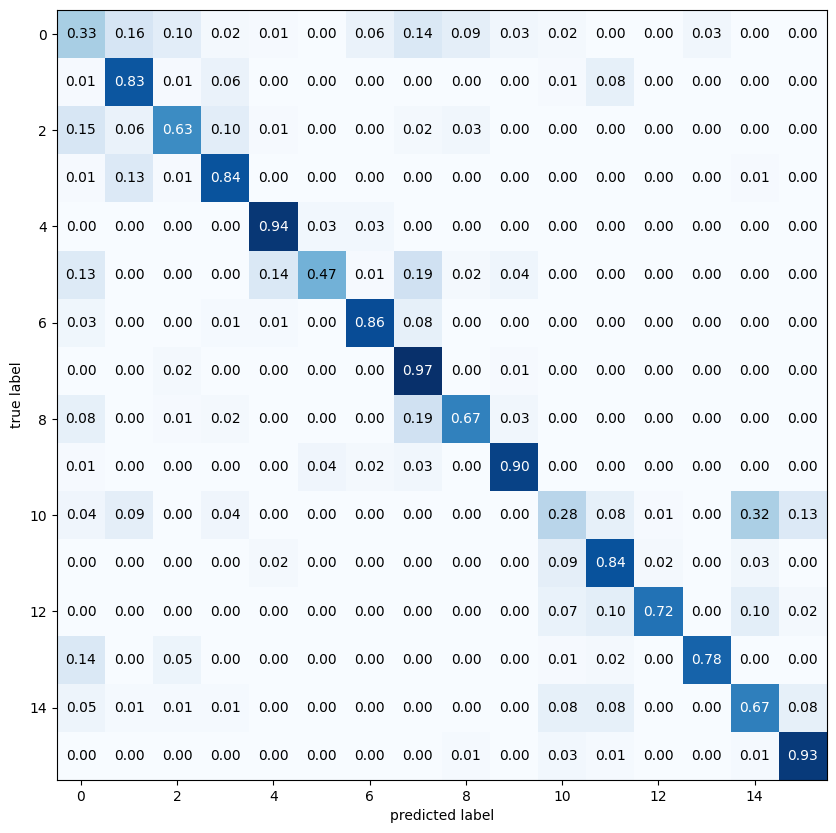

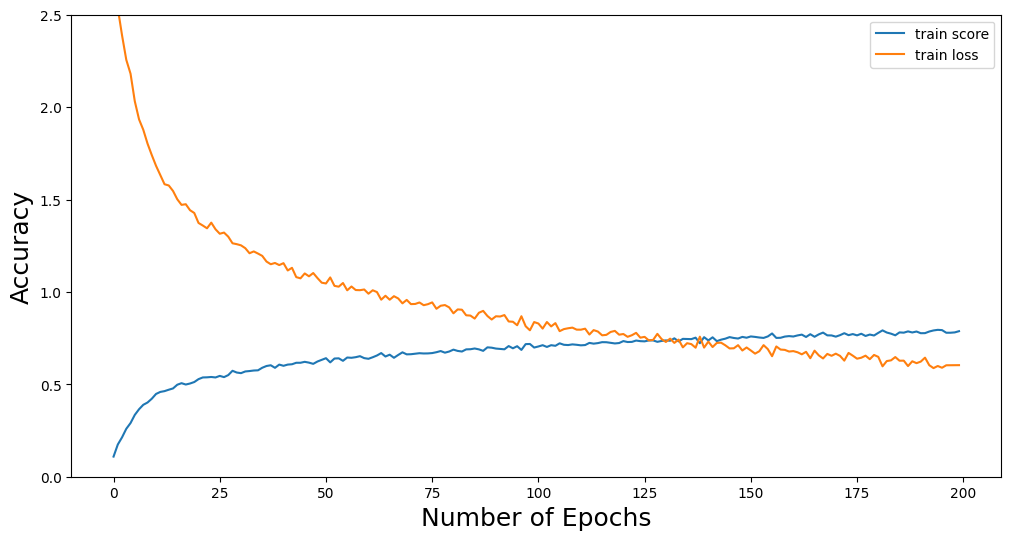

Train Data Shape: (2308, 300, 12)
Test Data Shape: (1127, 300, 12)


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_57 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 31, 64)    │          0 │ conv1d_57[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_95          │ (None, 31, 64)    │          0 │ max_pooling1d_19… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_95[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_19        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_19[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_19[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_97          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_97[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_38 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_19[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_58 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_38[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_98          │ (None, 31, 24)    │          0 │ conv1d_58[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_59 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_98[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_59[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_39 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_38[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_39[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_99          │ (None, 128)       │          0 │ dense_38[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 219ms/step - accuracy: 0.0867 - loss: 2.8511
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.1606 - loss: 2.5948
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.1882 - loss: 2.5329
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.2213 - loss: 2.3931
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.2557 - loss: 2.2874
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.2737 - loss: 2.1945
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.2857 - loss: 2.1443
Epoch 8/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.3285 - loss: 2.0331
Epoch 9/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.3567 - loss: 1.9211
Epoch 10/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.3717 - loss: 1.8905
Epoch 11/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.3776 - loss: 1.8150
Epoch 12/200
37/37 ━━━━━━━━━━━━━━━━━━━━

37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.8982 - loss: 0.3136
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7520 - loss: 0.7218
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
>#20: 
  train accuracy: 0.90381
  train loss    : 0.29396
  test accuracy: 0.75954
  test loss    : 0.76424

Accuracy: 0.75954 (+/-0.00000)
Loss: 0.76424 (+/-0.00000)


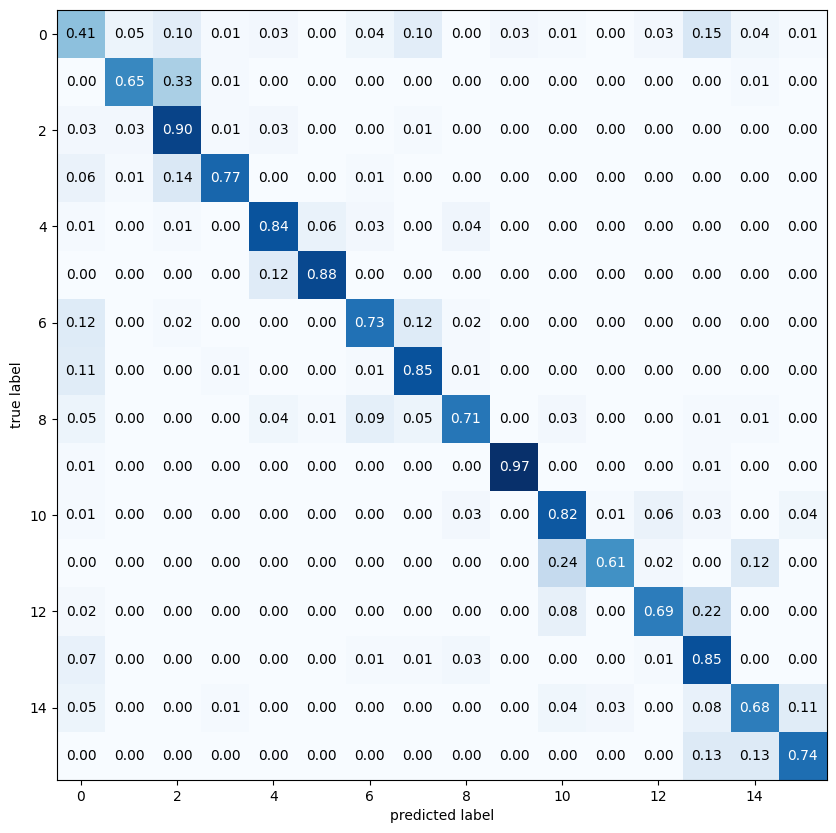

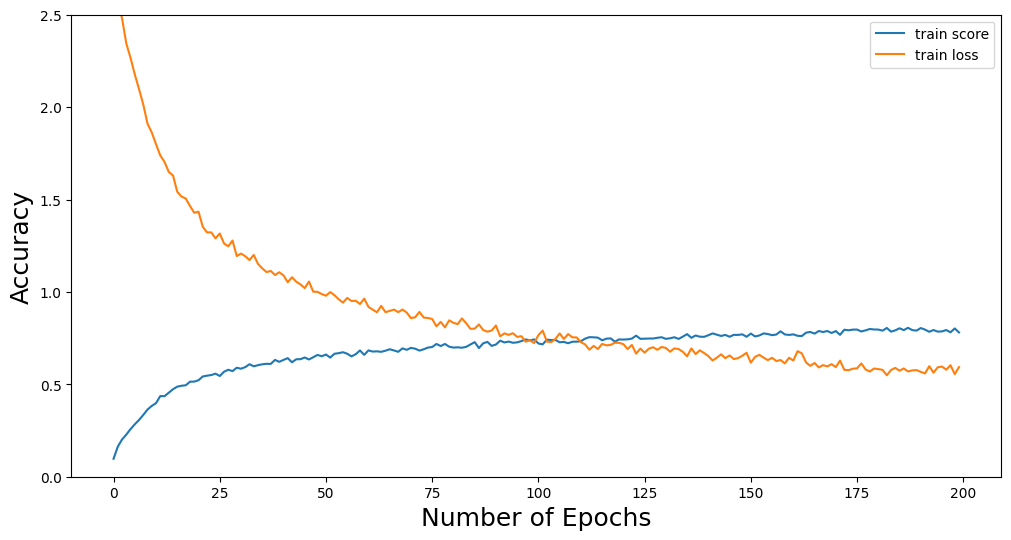

Train Data Shape: (2028, 300, 12)
Test Data Shape: (980, 300, 12)


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_60 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_20    │ (None, 31, 64)    │          0 │ conv1d_60[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_100         │ (None, 31, 64)    │          0 │ max_pooling1d_20… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_100[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_20        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_20[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_20[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_102         │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_102[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_40 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_20[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_61 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_40[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_103         │ (None, 31, 24)    │          0 │ conv1d_61[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_62 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_103[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_62[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_41 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_40[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_41[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_104         │ (None, 128)       │          0 │ dense_40[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 236ms/step - accuracy: 0.0881 - loss: 2.9128
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.1305 - loss: 2.6562
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.1572 - loss: 2.5588
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.1952 - loss: 2.4592
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.2073 - loss: 2.3806
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.2428 - loss: 2.2637
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.2671 - loss: 2.1846
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.3167 - loss: 2.0816
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.2917 - loss: 2.0860
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step - accuracy: 0.3120 - loss: 2.0475
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.3408 - loss: 1.9412
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9125 - loss: 0.2701
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.6913 - loss: 0.9486
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
>#21: 
  train accuracy: 0.89990
  train loss    : 0.32017
  test accuracy: 0.66939
  test loss    : 1.04185

Accuracy: 0.66939 (+/-0.00000)
Loss: 1.04185 (+/-0.00000)


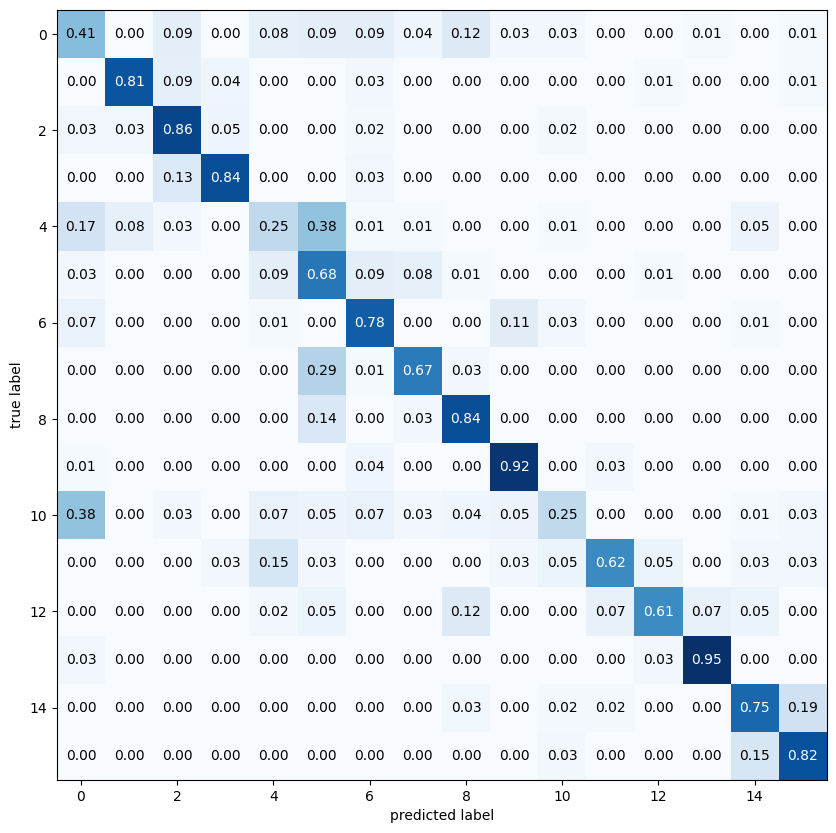

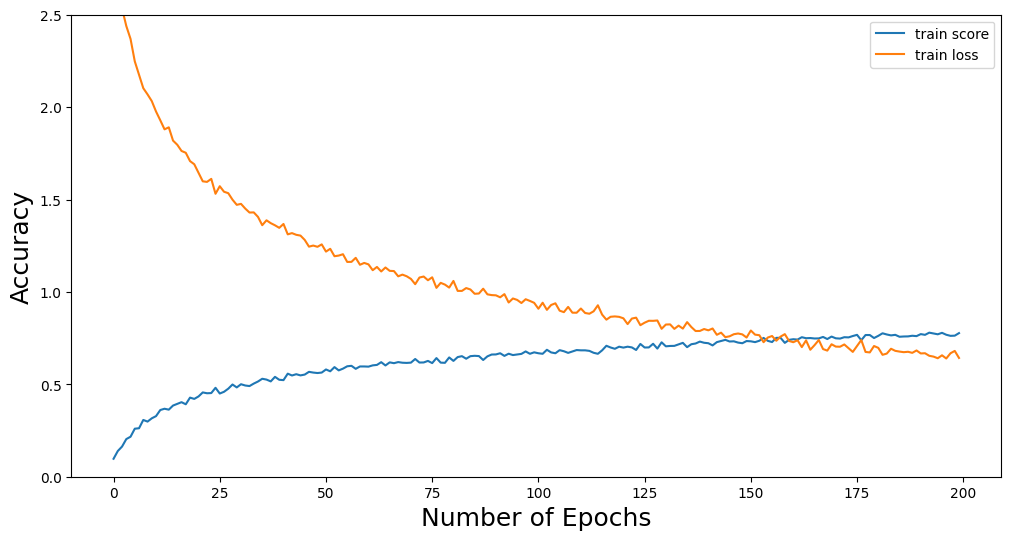

Train Data Shape: (2113, 300, 12)
Test Data Shape: (1094, 300, 12)


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_63 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_21    │ (None, 31, 64)    │          0 │ conv1d_63[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_105         │ (None, 31, 64)    │          0 │ max_pooling1d_21… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_105[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_21        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_21[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_21[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_107         │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_107[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_42 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_21[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_64 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_42[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_108         │ (None, 31, 24)    │          0 │ conv1d_64[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_65 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_108[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_65[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_43 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_42[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_43[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_109         │ (None, 128)       │          0 │ dense_42[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 233ms/step - accuracy: 0.0809 - loss: 2.8737
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - accuracy: 0.1254 - loss: 2.6897
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.1674 - loss: 2.6033
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - accuracy: 0.1740 - loss: 2.5560
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.2183 - loss: 2.3965
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step - accuracy: 0.2518 - loss: 2.3091
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.3030 - loss: 2.1623
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - accuracy: 0.3442 - loss: 2.1059
Epoch 9/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.3501 - loss: 1.9900
Epoch 10/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.4313 - loss: 1.7739
Epoch 11/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.4314 - loss: 1.7608
Epoch 12/200
34/34 ━━━━━━━━━━━━━━━━━

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9307 - loss: 0.1770
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.8348 - loss: 0.5745
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step
>#22: 
  train accuracy: 0.94510
  train loss    : 0.16202
  test accuracy: 0.79799
  test loss    : 0.71204

Accuracy: 0.79799 (+/-0.00000)
Loss: 0.71204 (+/-0.00000)


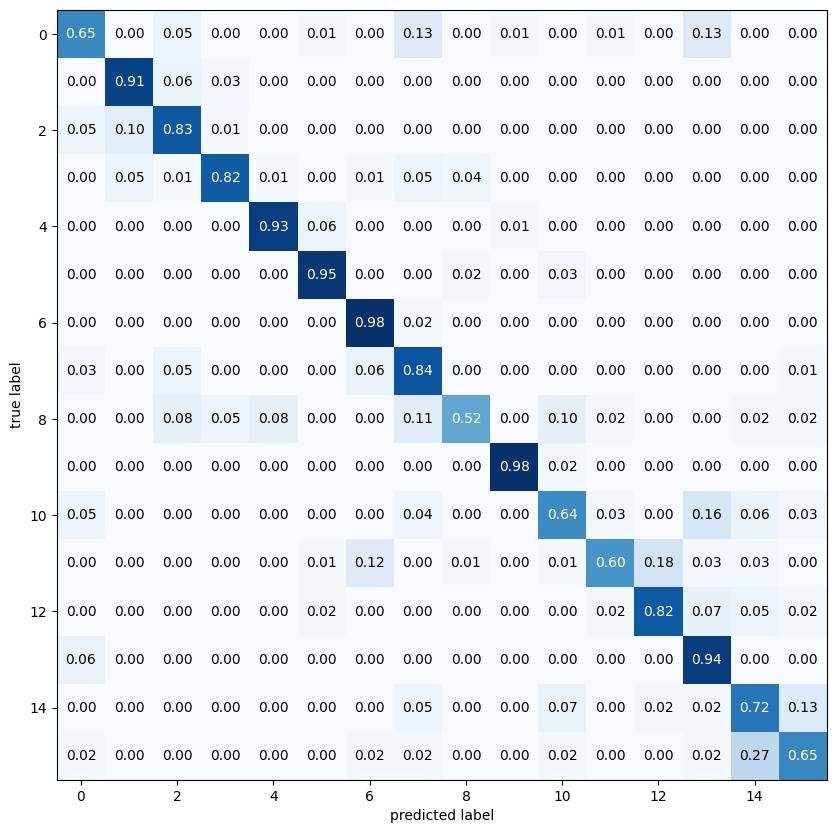

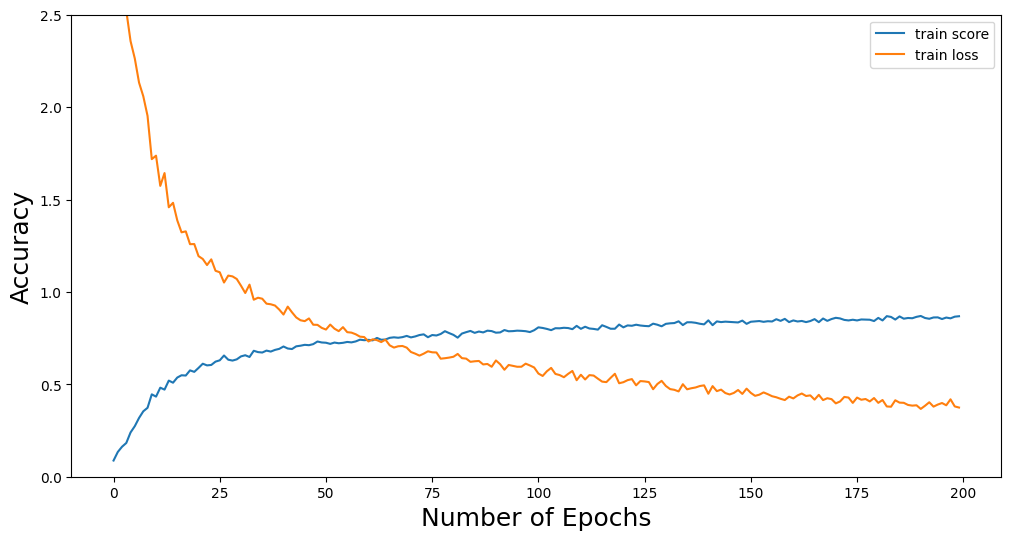

Train Data Shape: (2722, 300, 12)
Test Data Shape: (1355, 300, 12)


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_22    │ (None, 31, 64)    │          0 │ conv1d_66[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_110         │ (None, 31, 64)    │          0 │ max_pooling1d_22… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_110[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_22        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_22[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_22[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_112         │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_112[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_44 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_22[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_67 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_44[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_113         │ (None, 31, 24)    │          0 │ conv1d_67[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_113[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_68[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_45 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_44[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_45[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_114         │ (None, 128)       │          0 │ dense_44[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 290ms/step - accuracy: 0.0812 - loss: 3.0105
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.1325 - loss: 2.6360
Epoch 3/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 217ms/step - accuracy: 0.1414 - loss: 2.5257
Epoch 4/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.1812 - loss: 2.4225
Epoch 5/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.2045 - loss: 2.3241
Epoch 6/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.2666 - loss: 2.2279
Epoch 7/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - accuracy: 0.2991 - loss: 2.0647
Epoch 8/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.3439 - loss: 1.9440
Epoch 9/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 247ms/step - accuracy: 0.3559 - loss: 1.8625
Epoch 10/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step - accuracy: 0.4141 - loss: 1.7855
Epoch 11/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - accuracy: 0.4109 - loss: 1.6940
Epoch 12/200
43/43 ━━━━━━━━━━━━━━━

43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.9330 - loss: 0.1838
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.8120 - loss: 0.7362
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step
>#23: 
  train accuracy: 0.92322
  train loss    : 0.21753
  test accuracy: 0.75055
  test loss    : 0.87303

Accuracy: 0.75055 (+/-0.00000)
Loss: 0.87303 (+/-0.00000)


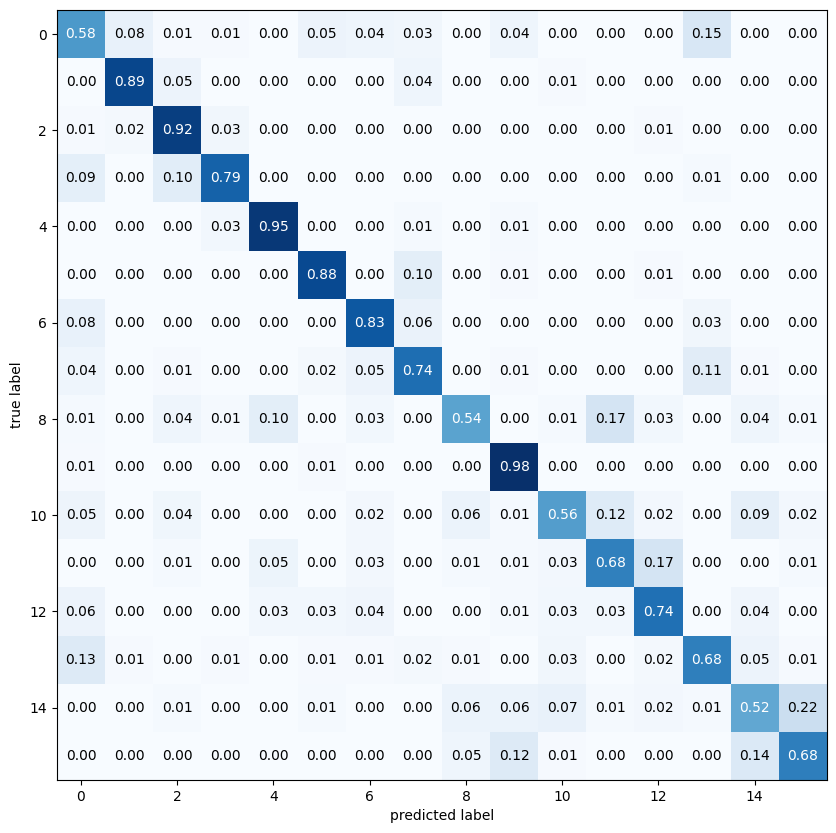

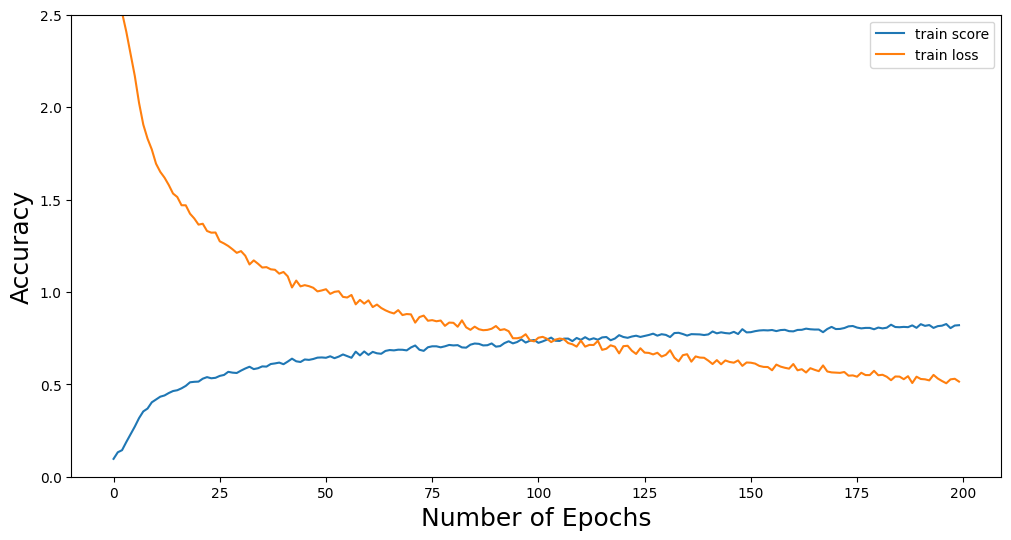

Train Data Shape: (2580, 300, 12)
Test Data Shape: (1255, 300, 12)


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_69 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_23    │ (None, 31, 64)    │          0 │ conv1d_69[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_115         │ (None, 31, 64)    │          0 │ max_pooling1d_23… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_115[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_23        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_23[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_23[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_117         │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_117[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_46 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_23[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_70 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_46[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_118         │ (None, 31, 24)    │          0 │ conv1d_70[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_71 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_118[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_71[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_47 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_46[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_47[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_119         │ (None, 128)       │          0 │ dense_46[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - accuracy: 0.1000 - loss: 2.8476
Epoch 2/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - accuracy: 0.1270 - loss: 2.6202
Epoch 3/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.1720 - loss: 2.4825
Epoch 4/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - accuracy: 0.2232 - loss: 2.3226
Epoch 5/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.2693 - loss: 2.1939
Epoch 6/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.3170 - loss: 2.0608
Epoch 7/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - accuracy: 0.3539 - loss: 1.9348
Epoch 8/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accuracy: 0.3910 - loss: 1.8684
Epoch 9/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.3861 - loss: 1.8264
Epoch 10/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.4001 - loss: 1.7936
Epoch 11/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step - accuracy: 0.4379 - loss: 1.6621
Epoch 12/200
41/41 ━━━━━━━━━━━━━━━━

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8742 - loss: 0.3684
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.7063 - loss: 1.0128
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step
>#24: 
  train accuracy: 0.84961
  train loss    : 0.41690
  test accuracy: 0.63506
  test loss    : 1.31550

Accuracy: 0.63506 (+/-0.00000)
Loss: 1.31550 (+/-0.00000)


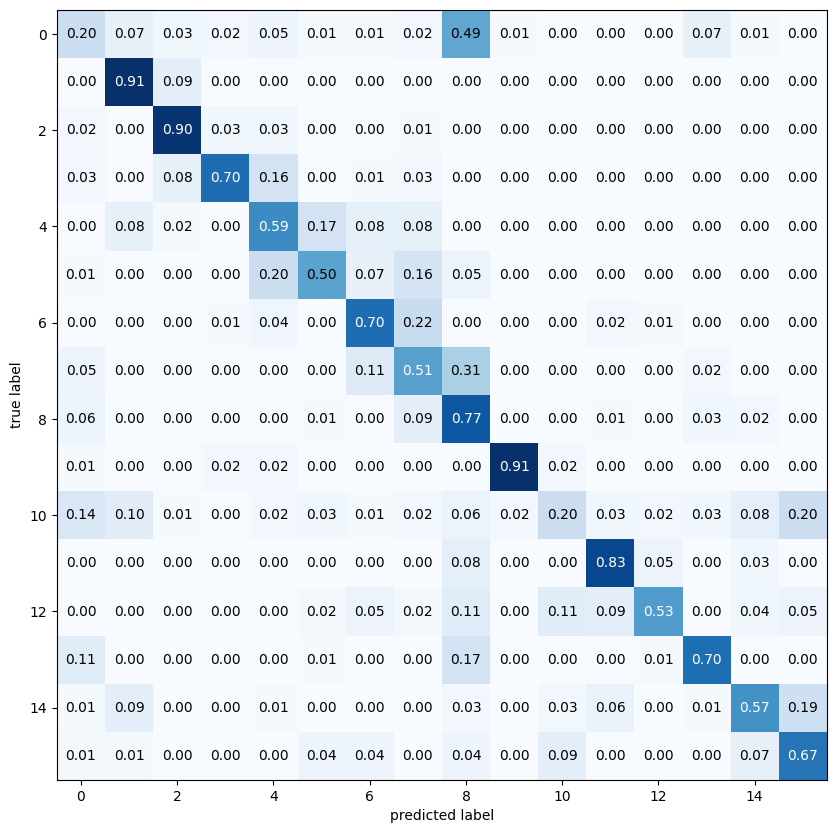

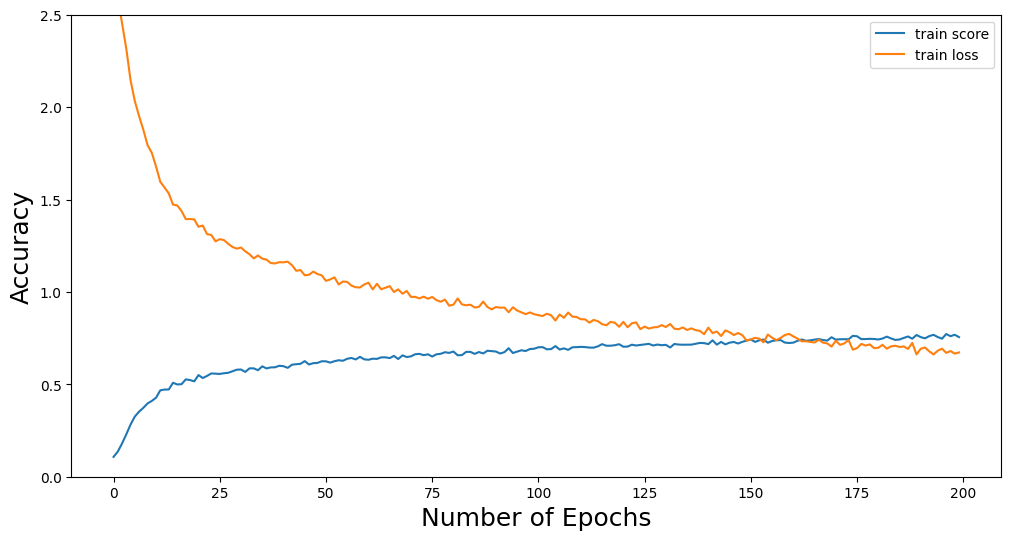

Train Data Shape: (1873, 300, 12)
Test Data Shape: (877, 300, 12)


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_72 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_24    │ (None, 31, 64)    │          0 │ conv1d_72[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_120         │ (None, 31, 64)    │          0 │ max_pooling1d_24… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_120[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_24        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_24[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_24[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_122         │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_122[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_48 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_24[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_73 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_48[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_123         │ (None, 31, 24)    │          0 │ conv1d_73[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_74 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_123[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_74[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_49 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_48[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_49[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_124         │ (None, 128)       │          0 │ dense_48[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 263ms/step - accuracy: 0.0772 - loss: 2.8856
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.1632 - loss: 2.5866
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 0.2323 - loss: 2.4022
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 255ms/step - accuracy: 0.2799 - loss: 2.2920
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.2834 - loss: 2.1835
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.3475 - loss: 2.0270
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 0.3770 - loss: 1.9363
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - accuracy: 0.4004 - loss: 1.8725
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - accuracy: 0.4119 - loss: 1.7840
Epoch 10/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - accuracy: 0.4345 - loss: 1.7205
Epoch 11/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 0.4450 - loss: 1.7004
Epoch 12/200
30/30 ━━━━━━━━━━━━━━━━

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.9314 - loss: 0.1891
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.8500 - loss: 0.4716
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step
>#25: 
  train accuracy: 0.92205
  train loss    : 0.21932
  test accuracy: 0.80844
  test loss    : 0.59994

Accuracy: 0.80844 (+/-0.00000)
Loss: 0.59994 (+/-0.00000)


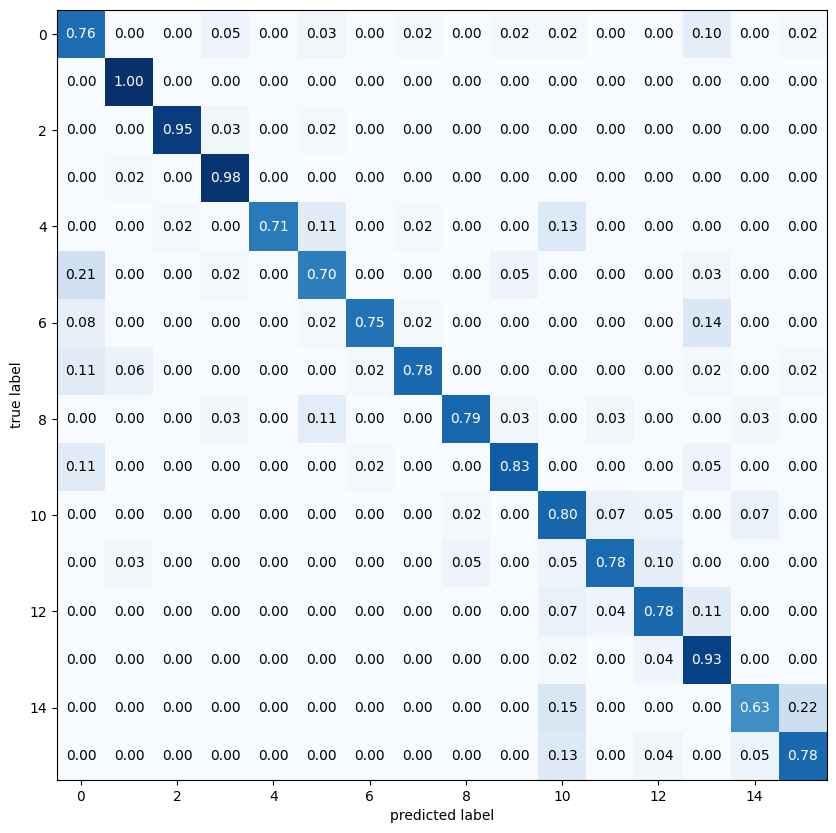

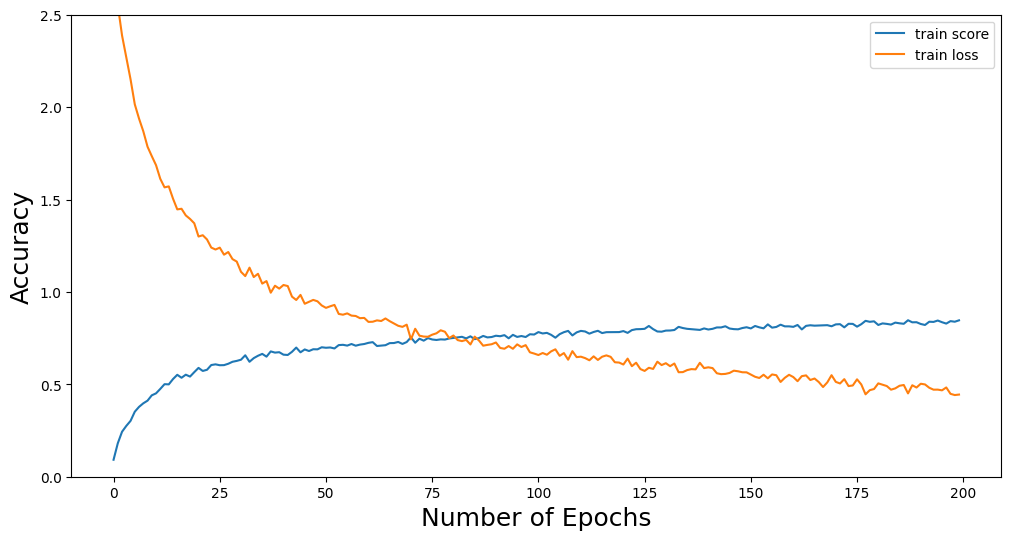

Train Data Shape: (3219, 300, 12)
Test Data Shape: (1635, 300, 12)


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_75 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_25[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_25    │ (None, 31, 64)    │          0 │ conv1d_75[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_125         │ (None, 31, 64)    │          0 │ max_pooling1d_25… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_125[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_25        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_25[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_25[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_127         │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_127[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_50 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_25[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_76 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_50[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_128         │ (None, 31, 24)    │          0 │ conv1d_76[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_77 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_128[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_77[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_51 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_50[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_51[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_129         │ (None, 128)       │          0 │ dense_50[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 222ms/step - accuracy: 0.0822 - loss: 2.8471
Epoch 2/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 0.1082 - loss: 2.6759
Epoch 3/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 222ms/step - accuracy: 0.1177 - loss: 2.6489
Epoch 4/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 215ms/step - accuracy: 0.1321 - loss: 2.6196
Epoch 5/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - accuracy: 0.1323 - loss: 2.5699
Epoch 6/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 0.1802 - loss: 2.4576
Epoch 7/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - accuracy: 0.2241 - loss: 2.3316
Epoch 8/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - accuracy: 0.2566 - loss: 2.1847
Epoch 9/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - accuracy: 0.3148 - loss: 2.0585
Epoch 10/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - accuracy: 0.3372 - loss: 1.9226
Epoch 11/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - accuracy: 0.3666 - loss: 1.8747
Epoch 12/200
51/51 ━━━━━━━━━━━

51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.9118 - loss: 0.2958
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.7972 - loss: 0.6884
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step
>#26: 
  train accuracy: 0.90525
  train loss    : 0.30874
  test accuracy: 0.75474
  test loss    : 0.90870

Accuracy: 0.75474 (+/-0.00000)
Loss: 0.90870 (+/-0.00000)


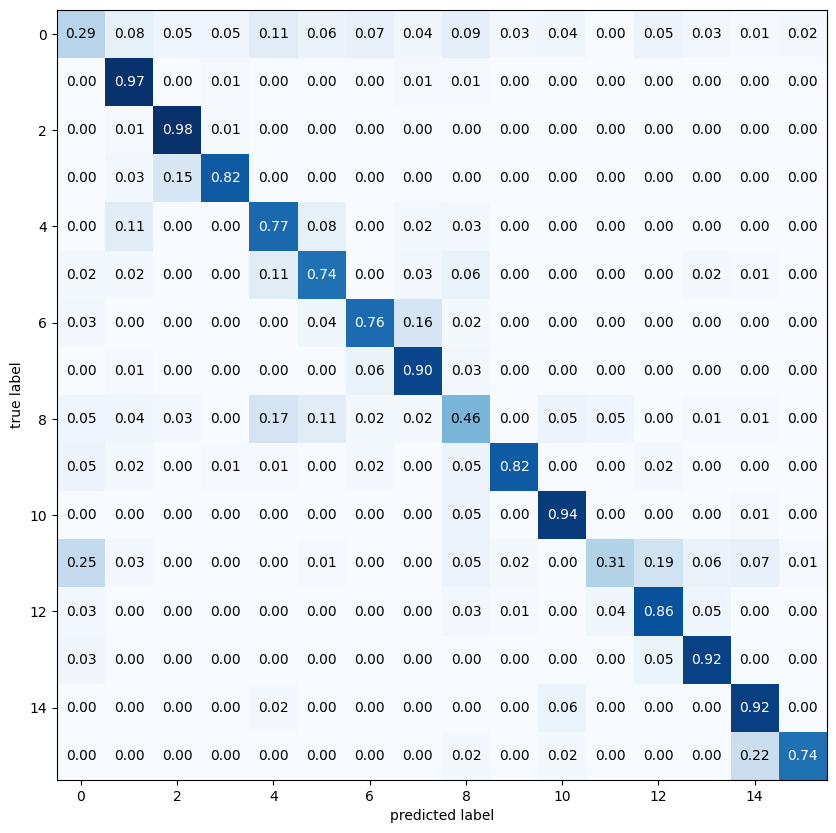

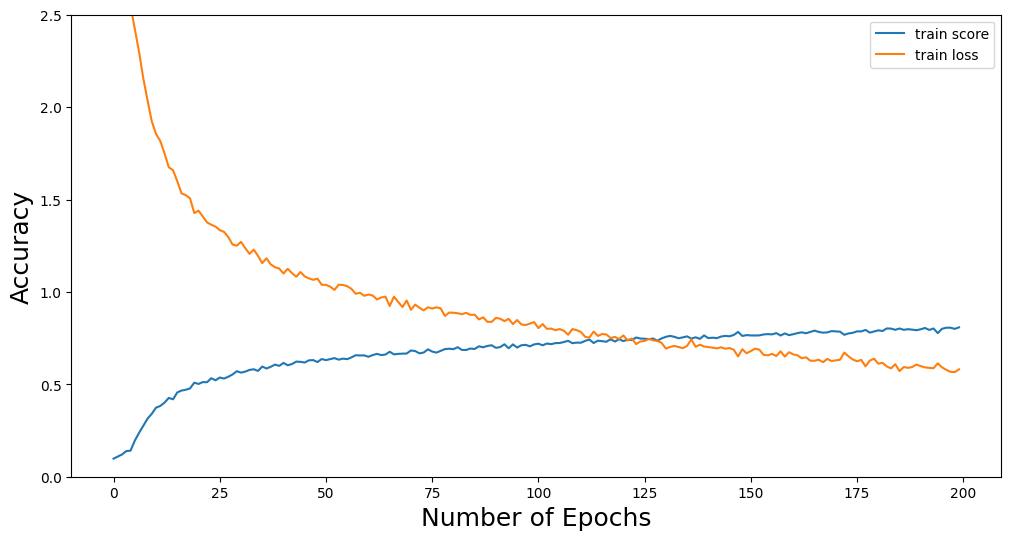

Train Data Shape: (1966, 300, 12)
Test Data Shape: (982, 300, 12)


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_78 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_26[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_26    │ (None, 31, 64)    │          0 │ conv1d_78[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_130         │ (None, 31, 64)    │          0 │ max_pooling1d_26… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_130[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_26        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_26[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_26[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_132         │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_132[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_52 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_26[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_79 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_52[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_133         │ (None, 31, 24)    │          0 │ conv1d_79[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_80 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_133[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_80[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_53 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_52[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_53[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_134         │ (None, 128)       │          0 │ dense_52[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 220ms/step - accuracy: 0.0654 - loss: 2.9292
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.1503 - loss: 2.6048
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 0.1846 - loss: 2.5182
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.2265 - loss: 2.3986
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.2802 - loss: 2.2049
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.3463 - loss: 2.0419
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.3560 - loss: 1.9675
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.3947 - loss: 1.8429
Epoch 9/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.4261 - loss: 1.7519
Epoch 10/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - accuracy: 0.4428 - loss: 1.6886
Epoch 11/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.4613 - loss: 1.6354
Epoch 12/200
31/31 ━━━━━━━━━━━━━━

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9392 - loss: 0.1830
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.7960 - loss: 0.7436
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
>#27: 
  train accuracy: 0.95066
  train loss    : 0.15150
  test accuracy: 0.80346
  test loss    : 0.75286

Accuracy: 0.80346 (+/-0.00000)
Loss: 0.75286 (+/-0.00000)


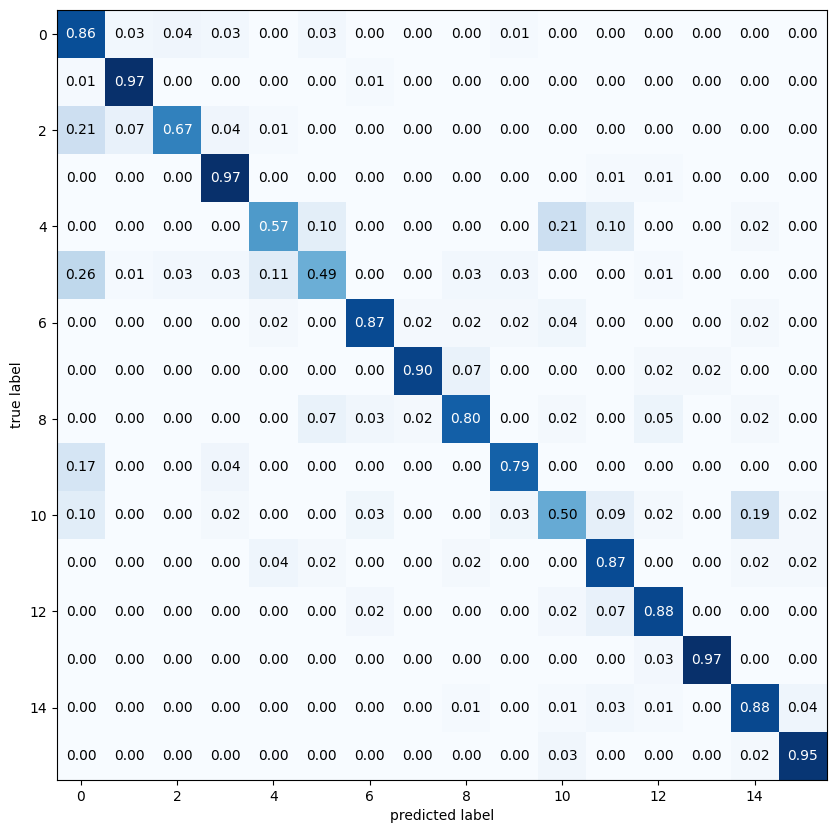

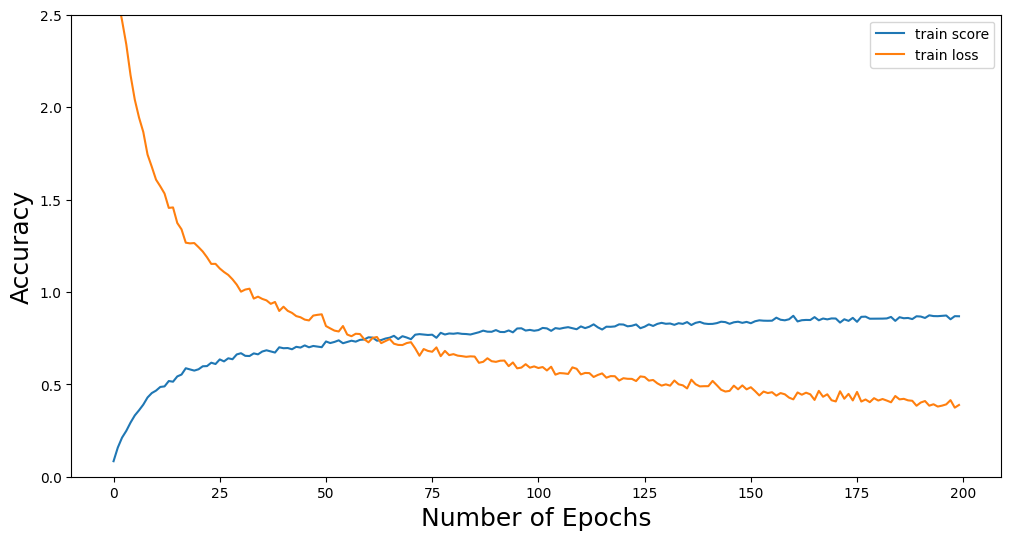

Train Data Shape: (3371, 300, 12)
Test Data Shape: (1535, 300, 12)


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_81 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_27    │ (None, 31, 64)    │          0 │ conv1d_81[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_135         │ (None, 31, 64)    │          0 │ max_pooling1d_27… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_135[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_27        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_27[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_27[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_137         │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_137[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_54 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_27[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_82 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_54[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_138         │ (None, 31, 24)    │          0 │ conv1d_82[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_83 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_138[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_83[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_55 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_54[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_55[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_139         │ (None, 128)       │          0 │ dense_54[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 200ms/step - accuracy: 0.0883 - loss: 2.9049
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy: 0.1821 - loss: 2.5155
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.2385 - loss: 2.3299
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 196ms/step - accuracy: 0.2912 - loss: 2.1641
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.3274 - loss: 2.0702
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.3543 - loss: 1.9794
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.3610 - loss: 1.9383
Epoch 8/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.3721 - loss: 1.9142
Epoch 9/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - accuracy: 0.3725 - loss: 1.8917
Epoch 10/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.4044 - loss: 1.8417
Epoch 11/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.4101 - loss: 1.8308
Epoch 12/200
53/53 ━━━━━━━━━━━

53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.8627 - loss: 0.4116
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.6281 - loss: 1.1453
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step
>#28: 
  train accuracy: 0.84515
  train loss    : 0.45847
  test accuracy: 0.60326
  test loss    : 1.26919

Accuracy: 0.60326 (+/-0.00000)
Loss: 1.26919 (+/-0.00000)


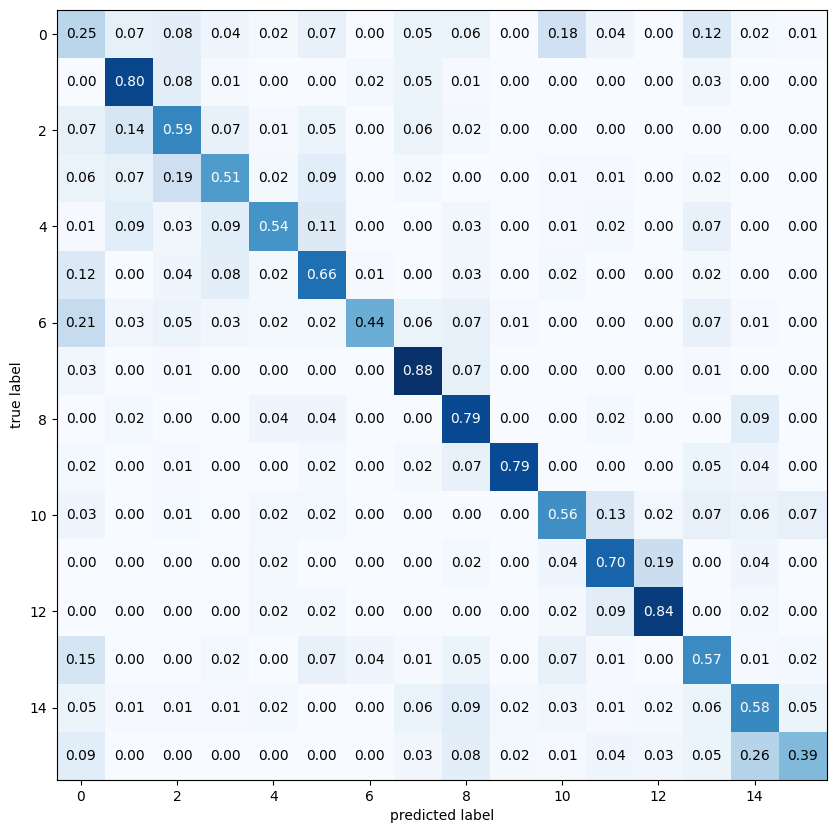

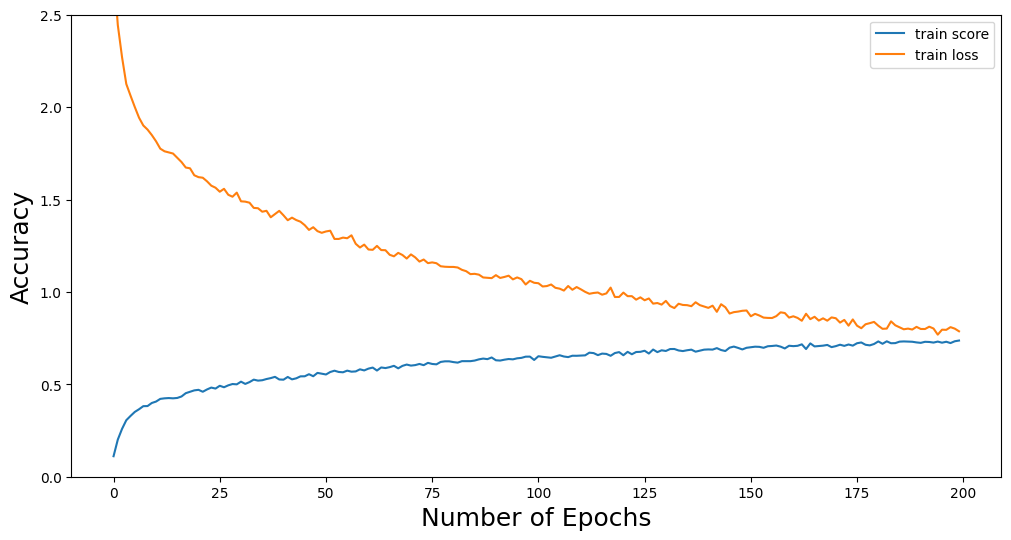

Train Data Shape: (1909, 300, 12)
Test Data Shape: (984, 300, 12)


Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_84 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_28[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_28    │ (None, 31, 64)    │          0 │ conv1d_84[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_140         │ (None, 31, 64)    │          0 │ max_pooling1d_28… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_140[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_28        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_28[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_28[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_142         │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_142[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_56 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_28[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_85 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_56[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_143         │ (None, 31, 24)    │          0 │ conv1d_85[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_86 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_143[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_86[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_57 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_56[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_57[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_144         │ (None, 128)       │          0 │ dense_56[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 222ms/step - accuracy: 0.0722 - loss: 2.9749
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.1234 - loss: 2.6086
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.1462 - loss: 2.5054
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.1764 - loss: 2.4070
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.2209 - loss: 2.3557
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.2576 - loss: 2.2423
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.3065 - loss: 2.1188
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.3131 - loss: 2.0730
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.3387 - loss: 2.0011
Epoch 10/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.3776 - loss: 1.8428
Epoch 11/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.4043 - loss: 1.7912
Epoch 12/200
30/30 ━━━━━━━━━━━━━━━━━━

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9366 - loss: 0.1664
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7025 - loss: 1.0424
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
>#29: 
  train accuracy: 0.93400
  train loss    : 0.17790
  test accuracy: 0.71037
  test loss    : 1.18761

Accuracy: 0.71037 (+/-0.00000)
Loss: 1.18761 (+/-0.00000)


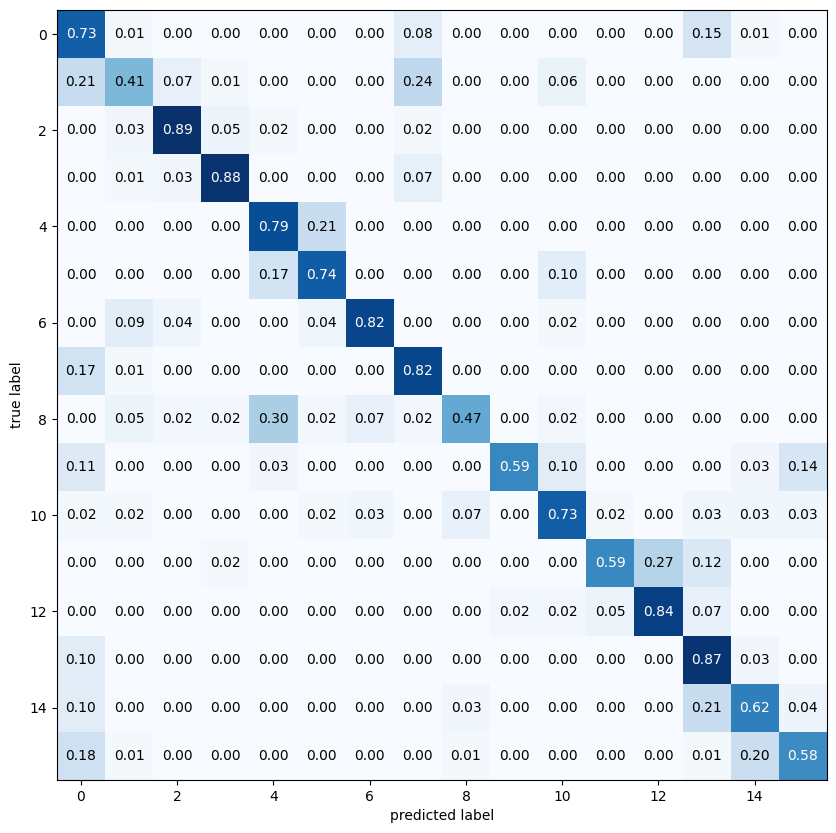

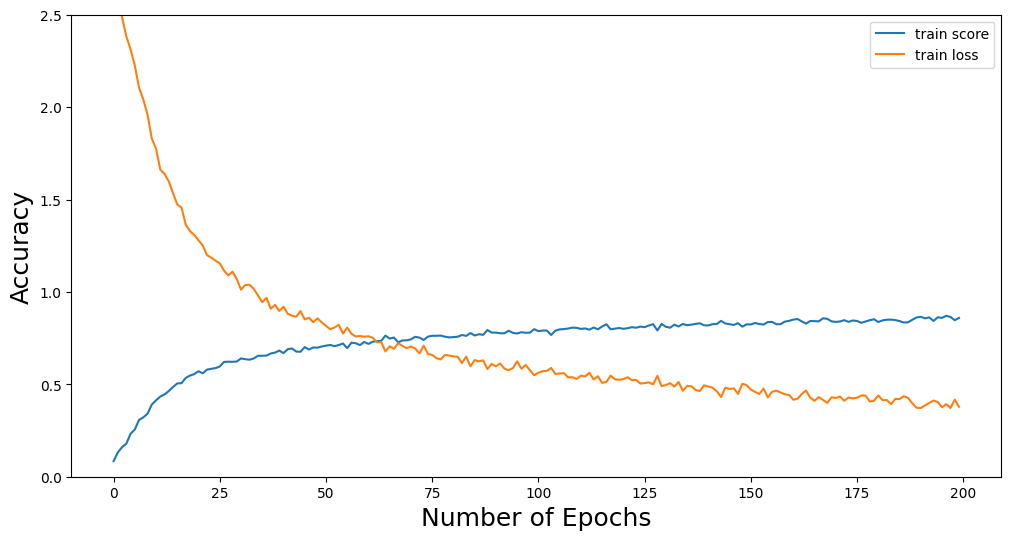

Train Data Shape: (2902, 300, 12)
Test Data Shape: (1488, 300, 12)


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_87 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_29    │ (None, 31, 64)    │          0 │ conv1d_87[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_145         │ (None, 31, 64)    │          0 │ max_pooling1d_29… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_145[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_29        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_29[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_29[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_147         │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_147[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_58 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_29[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_88 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_58[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_148         │ (None, 31, 24)    │          0 │ conv1d_88[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_89 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_148[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_89[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_59 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_58[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_59[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_58 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_149         │ (None, 128)       │          0 │ dense_58[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 207ms/step - accuracy: 0.0701 - loss: 2.9122
Epoch 2/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 0.0756 - loss: 2.7061
Epoch 3/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.1100 - loss: 2.5944
Epoch 4/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.1505 - loss: 2.4860
Epoch 5/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.1822 - loss: 2.3652
Epoch 6/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.2369 - loss: 2.1601
Epoch 7/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 0.2646 - loss: 2.0694
Epoch 8/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 194ms/step - accuracy: 0.2985 - loss: 1.9635
Epoch 9/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.3263 - loss: 1.8454
Epoch 10/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.3774 - loss: 1.7808
Epoch 11/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.4080 - loss: 1.6671
Epoch 12/200
46/46 ━━━━━━━━━━━━━━━━━━━

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.8783 - loss: 0.3621
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.7008 - loss: 0.7903
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
>#30: 
  train accuracy: 0.89938
  train loss    : 0.30360
  test accuracy: 0.69825
  test loss    : 0.82061

Accuracy: 0.69825 (+/-0.00000)
Loss: 0.82061 (+/-0.00000)


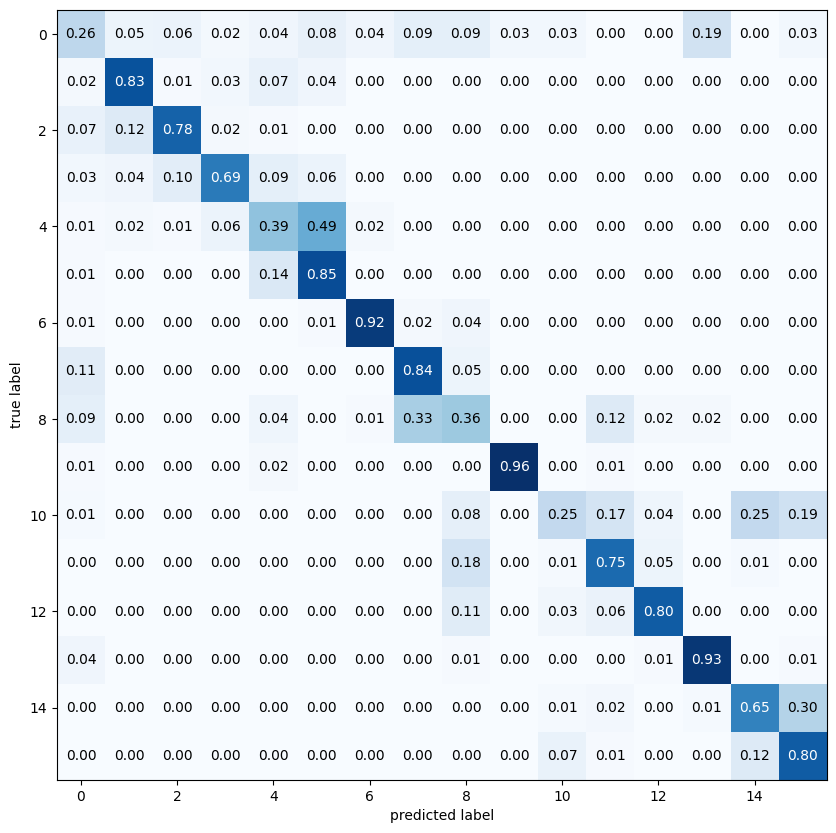

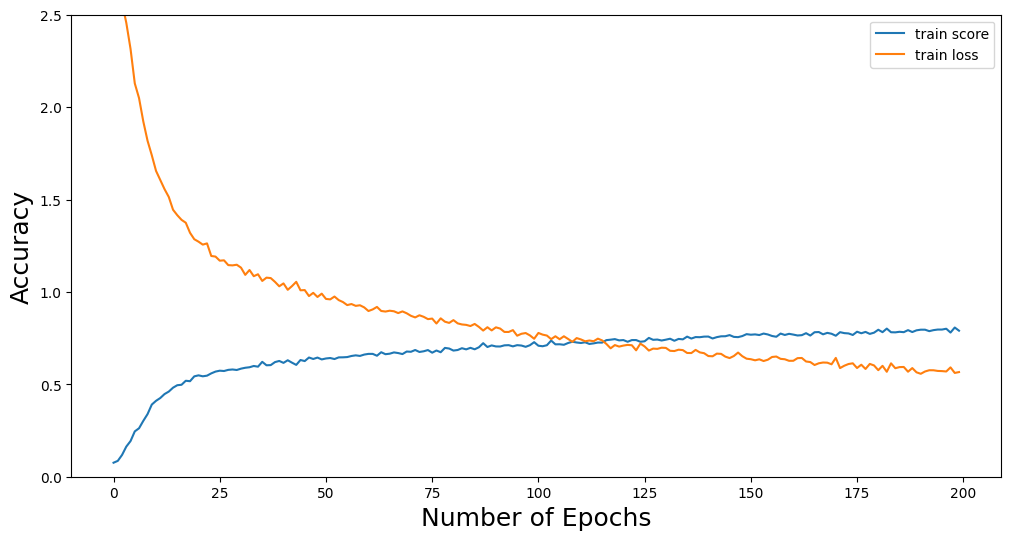

Train Data Shape: (3096, 300, 12)
Test Data Shape: (1537, 300, 12)


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_90 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_30    │ (None, 31, 64)    │          0 │ conv1d_90[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_150         │ (None, 31, 64)    │          0 │ max_pooling1d_30… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_150[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_30        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_30[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_30[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_152         │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_152[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_60 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_30[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_91 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_60[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_153         │ (None, 31, 24)    │          0 │ conv1d_91[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_92 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_153[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_92[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_61 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_60[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_61[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_154         │ (None, 128)       │          0 │ dense_60[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 197ms/step - accuracy: 0.0705 - loss: 2.9432
Epoch 2/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.1071 - loss: 2.6921
Epoch 3/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.1248 - loss: 2.6114
Epoch 4/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.1709 - loss: 2.5142
Epoch 5/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.2159 - loss: 2.4101
Epoch 6/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.2438 - loss: 2.2818
Epoch 7/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.2744 - loss: 2.2120
Epoch 8/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - accuracy: 0.2988 - loss: 2.1275
Epoch 9/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.3038 - loss: 2.0830
Epoch 10/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - accuracy: 0.3356 - loss: 1.9807
Epoch 11/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.3461 - loss: 1.9412
Epoch 12/200
49/49 ━━━━━━━━━━━━━━

49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.8744 - loss: 0.3749
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.7250 - loss: 0.9726
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
>#31: 
  train accuracy: 0.85691
  train loss    : 0.43882
  test accuracy: 0.66493
  test loss    : 1.13134

Accuracy: 0.66493 (+/-0.00000)
Loss: 1.13134 (+/-0.00000)


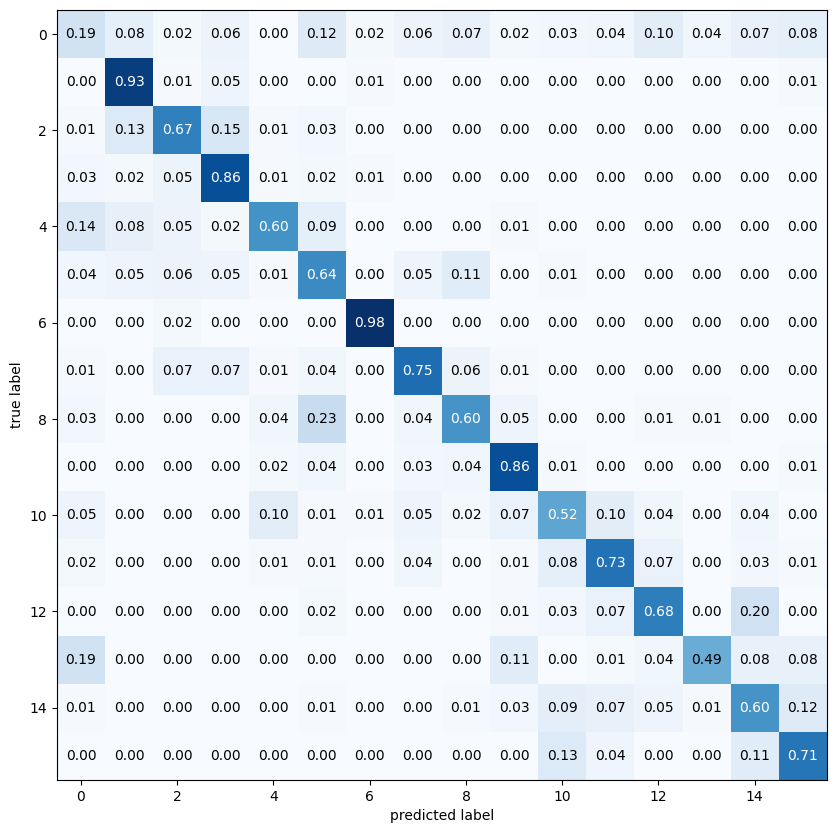

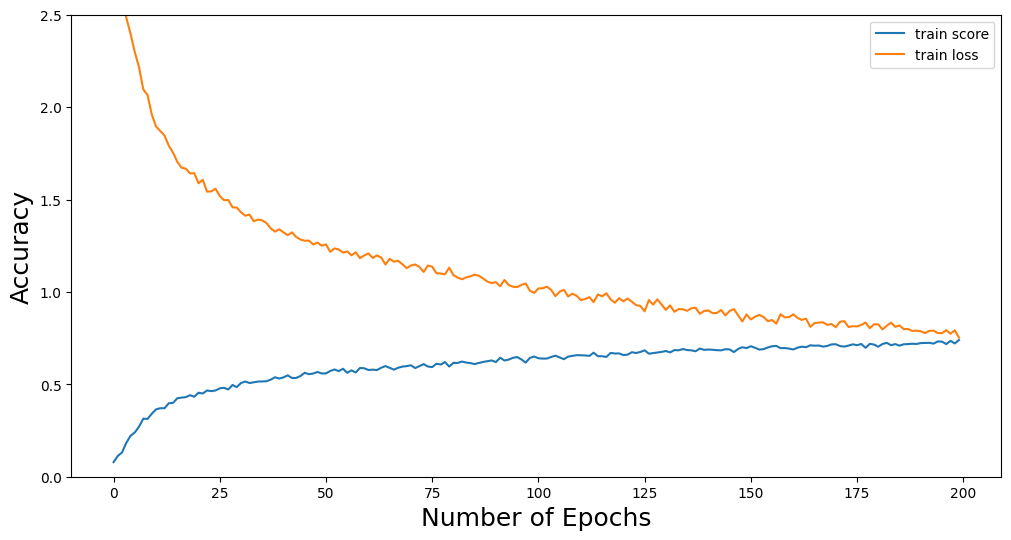

Train Data Shape: (2334, 300, 12)
Test Data Shape: (1039, 300, 12)


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_93 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_31[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_31    │ (None, 31, 64)    │          0 │ conv1d_93[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_155         │ (None, 31, 64)    │          0 │ max_pooling1d_31… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_155[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_31        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_31[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_31[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_157         │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_157[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_62 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_31[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_94 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_62[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_158         │ (None, 31, 24)    │          0 │ conv1d_94[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_95 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_158[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_95[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_63 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_62[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_63[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_159         │ (None, 128)       │          0 │ dense_62[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 254ms/step - accuracy: 0.0790 - loss: 2.9571
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.1058 - loss: 2.6999
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.1304 - loss: 2.5927
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.1868 - loss: 2.4759
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.2023 - loss: 2.3852
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.2238 - loss: 2.3203
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 0.2738 - loss: 2.2314
Epoch 8/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - accuracy: 0.2935 - loss: 2.1260
Epoch 9/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - accuracy: 0.3690 - loss: 1.9308
Epoch 10/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.4108 - loss: 1.8420
Epoch 11/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.4012 - loss: 1.8150
Epoch 12/200
37/37 ━━━━━━━━━━━━━━━━

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.8948 - loss: 0.3188
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7350 - loss: 0.8675
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
>#32: 
  train accuracy: 0.87532
  train loss    : 0.37673
  test accuracy: 0.75168
  test loss    : 0.77793

Accuracy: 0.75168 (+/-0.00000)
Loss: 0.77793 (+/-0.00000)


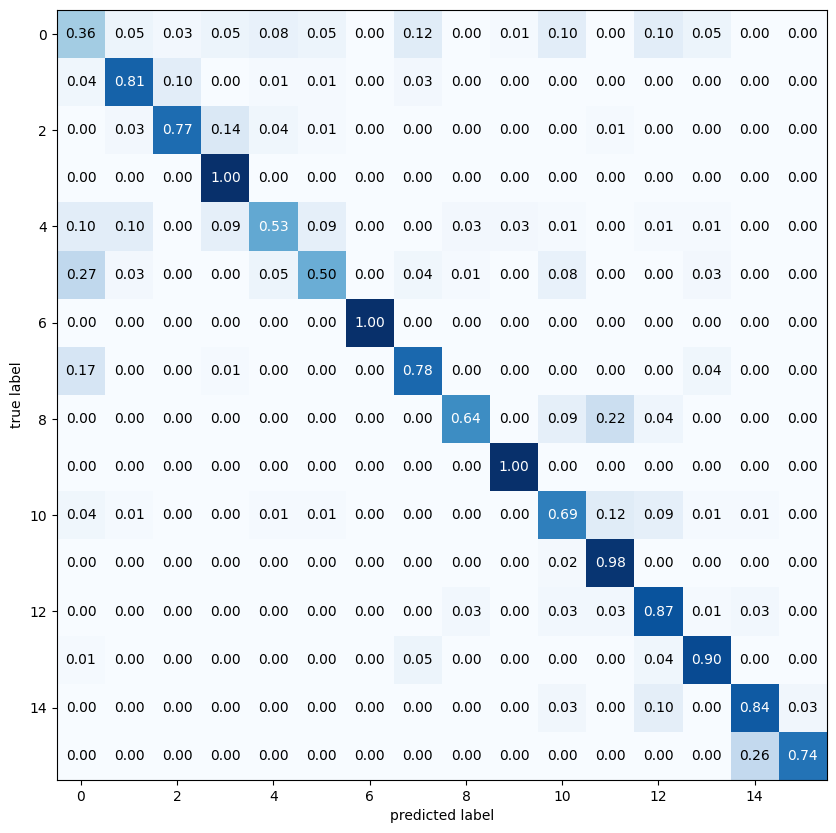

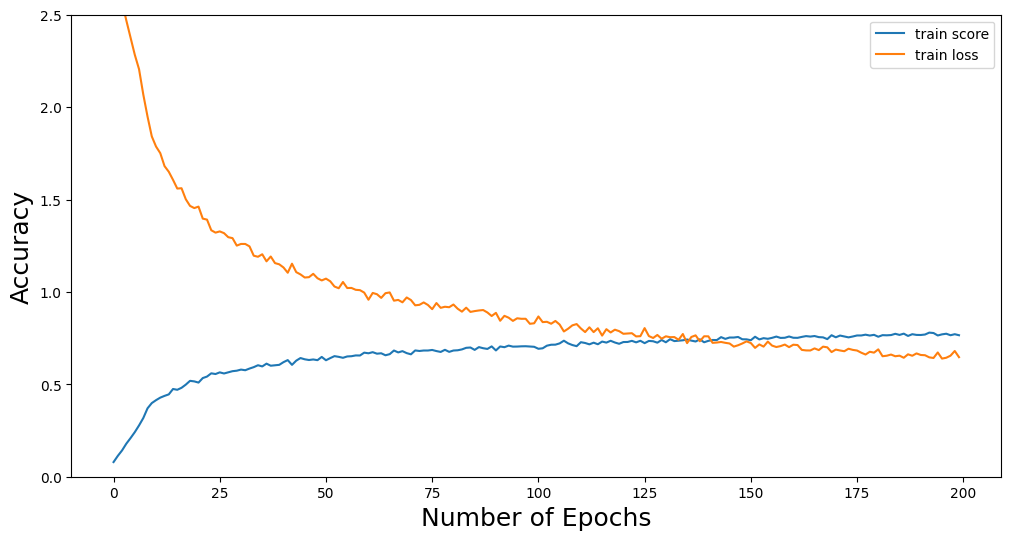

Train Data Shape: (2579, 300, 12)
Test Data Shape: (1192, 300, 12)


Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_96 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_32[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_32    │ (None, 31, 64)    │          0 │ conv1d_96[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_160         │ (None, 31, 64)    │          0 │ max_pooling1d_32… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_160[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_32        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_32[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_32[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_162         │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_162[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_64 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_32[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_97 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_64[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_163         │ (None, 31, 24)    │          0 │ conv1d_97[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_98 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_163[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_98[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_65 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_64[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_65[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_164         │ (None, 128)       │          0 │ dense_64[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 193ms/step - accuracy: 0.1119 - loss: 2.8137
Epoch 2/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.1844 - loss: 2.4689
Epoch 3/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.2768 - loss: 2.2240
Epoch 4/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.3505 - loss: 1.9577
Epoch 5/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.4027 - loss: 1.7842
Epoch 6/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.4369 - loss: 1.6889
Epoch 7/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.4525 - loss: 1.5825
Epoch 8/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.4750 - loss: 1.4837
Epoch 9/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.5211 - loss: 1.4350
Epoch 10/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.5288 - loss: 1.3460
Epoch 11/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.5323 - loss: 1.3331
Epoch 12/200
41/41 ━━━━━━━━━━━━━━━━━━

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9525 - loss: 0.1255
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.8827 - loss: 0.4193
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
>#33: 
  train accuracy: 0.95037
  train loss    : 0.13844
  test accuracy: 0.85822
  test loss    : 0.47419

Accuracy: 0.85822 (+/-0.00000)
Loss: 0.47419 (+/-0.00000)


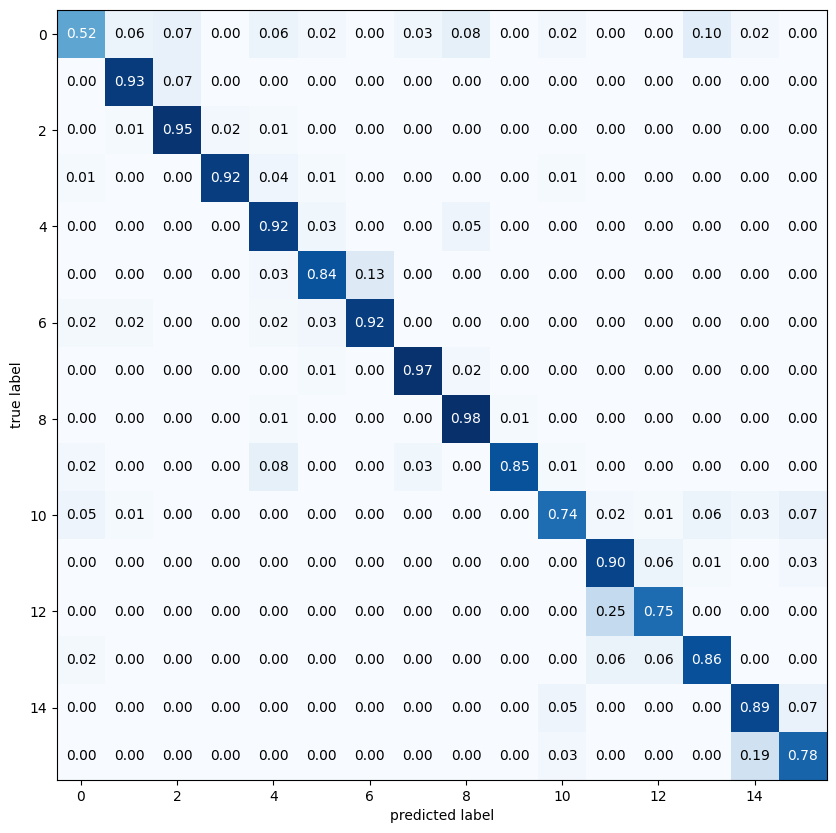

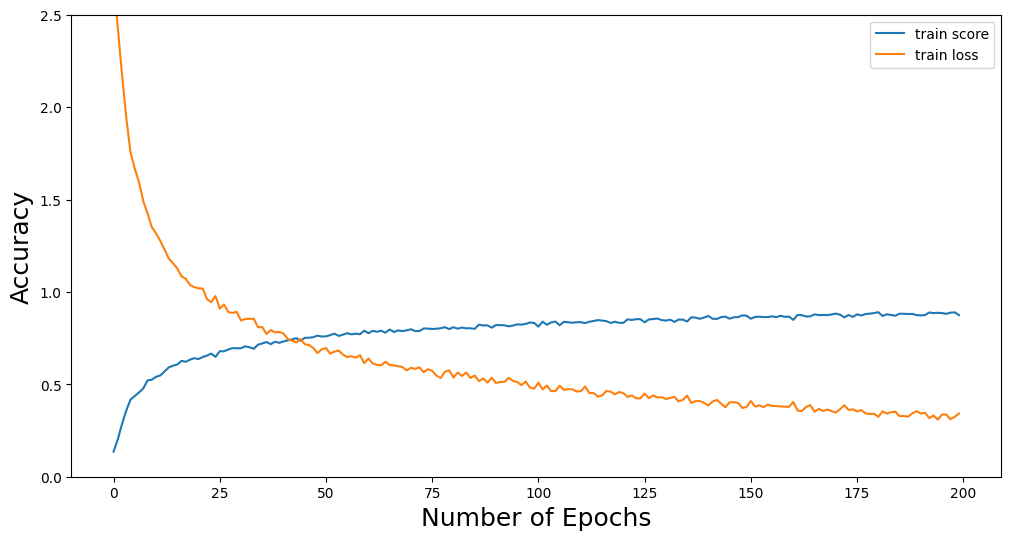

Train Data Shape: (2550, 300, 12)
Test Data Shape: (1270, 300, 12)


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_99 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_33[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_33    │ (None, 31, 64)    │          0 │ conv1d_99[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_165         │ (None, 31, 64)    │          0 │ max_pooling1d_33… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_165[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_33        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_33[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_33[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_167         │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_167[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_66 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_33[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_100 (Conv1D) │ (None, 31, 24)    │      1,584 │ add_66[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_168         │ (None, 31, 24)    │          0 │ conv1d_100[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_101 (Conv1D) │ (None, 31, 65)    │      1,625 │ dropout_168[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_101[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_67 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_66[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_67[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_169         │ (None, 128)       │          0 │ dense_66[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 213ms/step - accuracy: 0.0865 - loss: 2.9046
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.1388 - loss: 2.5936
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.1470 - loss: 2.5350
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.1634 - loss: 2.4860
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - accuracy: 0.1684 - loss: 2.4380
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.1716 - loss: 2.4098
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - accuracy: 0.2034 - loss: 2.3141
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - accuracy: 0.2718 - loss: 2.1374
Epoch 9/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.3402 - loss: 1.9156
Epoch 10/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.4194 - loss: 1.7239
Epoch 11/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.4417 - loss: 1.5866
Epoch 12/200
40/40 ━━━━━━━━━━━━━━━

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.9417 - loss: 0.1585
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.7908 - loss: 0.6072
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
>#34: 
  train accuracy: 0.95529
  train loss    : 0.13587
  test accuracy: 0.76929
  test loss    : 0.74602

Accuracy: 0.76929 (+/-0.00000)
Loss: 0.74602 (+/-0.00000)


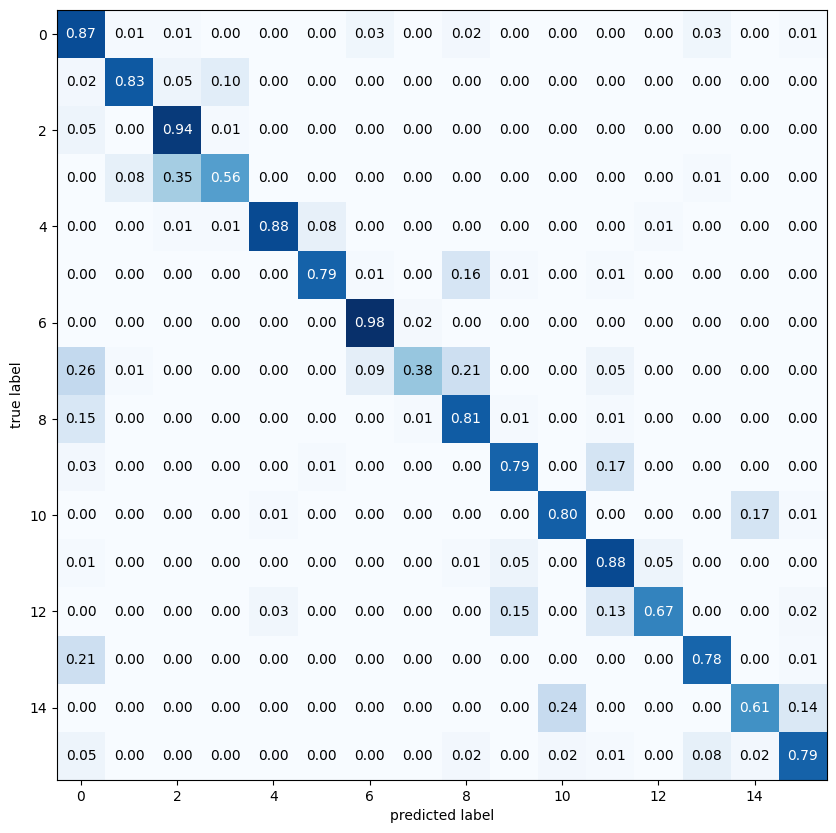

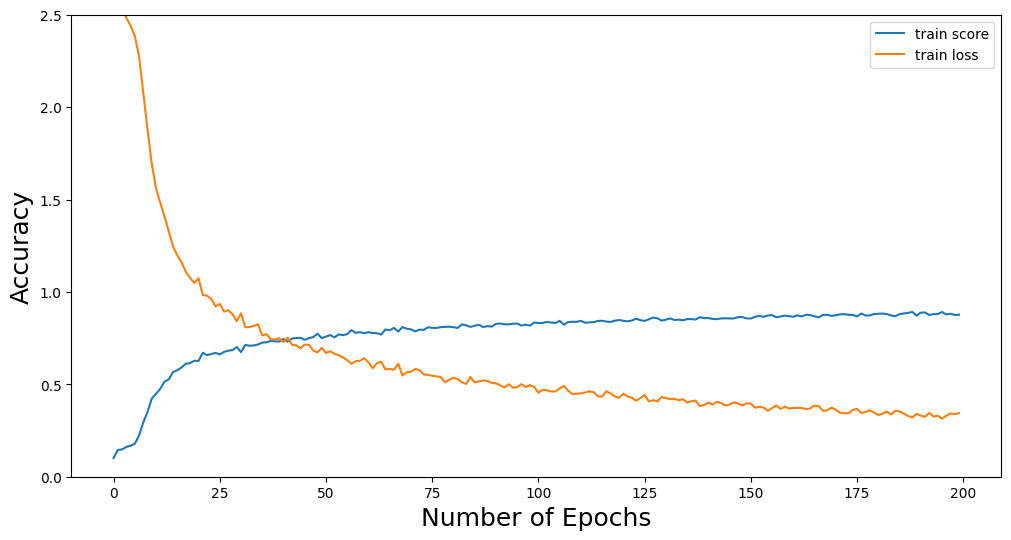

Train Data Shape: (3491, 300, 12)
Test Data Shape: (1772, 300, 12)


Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_102 (Conv1D) │ (None, 293, 64)   │      6,208 │ input_layer_34[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_34    │ (None, 31, 64)    │          0 │ conv1d_102[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_170         │ (None, 31, 64)    │          0 │ max_pooling1d_34… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_170[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_34        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_34[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_34[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_172         │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_172[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_68 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_34[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_103 (Conv1D) │ (None, 31, 24)    │      1,584 │ add_68[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_173         │ (None, 31, 24)    │          0 │ conv1d_103[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_104 (Conv1D) │ (None, 31, 65)    │      1,625 │ dropout_173[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_104[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_69 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_68[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_69[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_68 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_174         │ (None, 128)       │          0 │ dense_68[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - accuracy: 0.0879 - loss: 2.8939
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.1375 - loss: 2.6145
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.1838 - loss: 2.4969
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.2406 - loss: 2.3554
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - accuracy: 0.2744 - loss: 2.2346
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.2950 - loss: 2.1352
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.3505 - loss: 2.0282
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.3452 - loss: 1.9588
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.3886 - loss: 1.9030
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.3742 - loss: 1.8935
Epoch 11/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.4223 - loss: 1.7992
Epoch 12/200
55/55 ━━━━━━━━━━━

55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.8915 - loss: 0.3253
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7490 - loss: 0.8093
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step
>#35: 
  train accuracy: 0.89029
  train loss    : 0.33400
  test accuracy: 0.70485
  test loss    : 0.99922

Accuracy: 0.70485 (+/-0.00000)
Loss: 0.99922 (+/-0.00000)


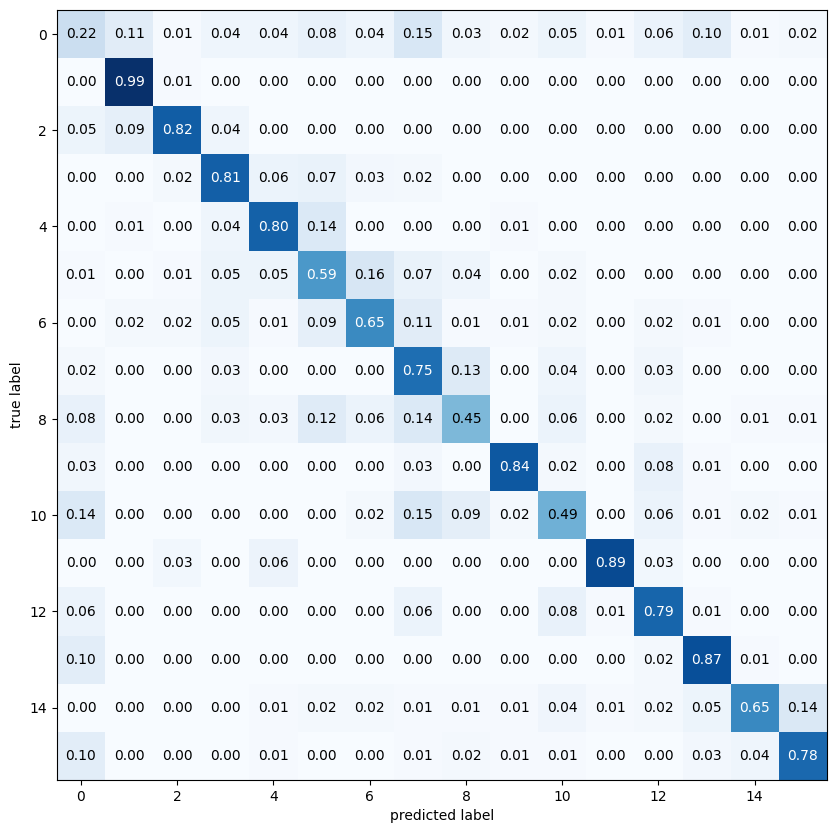

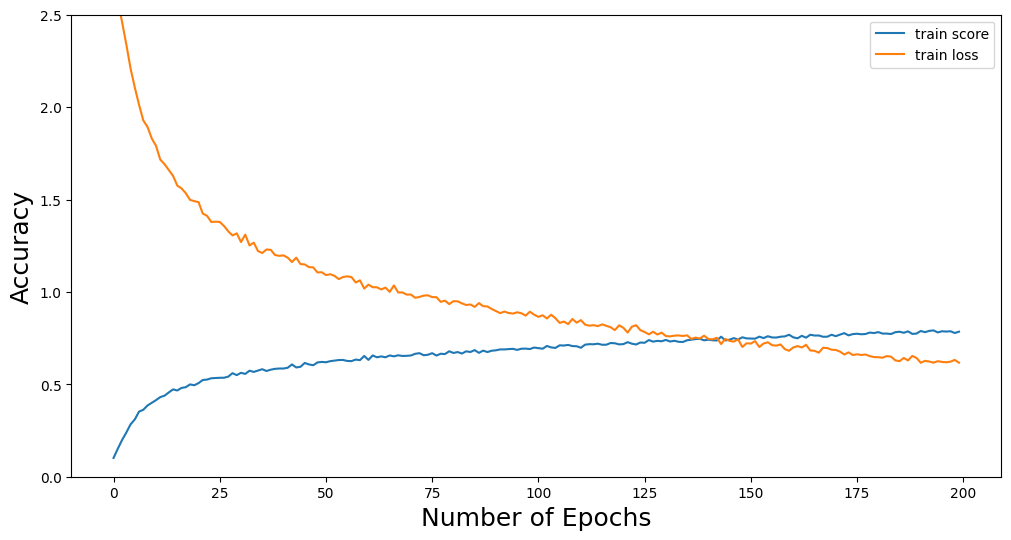

Train Data Shape: (2216, 300, 12)
Test Data Shape: (1086, 300, 12)


Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_35      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_105 (Conv1D) │ (None, 293, 64)   │      6,208 │ input_layer_35[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_35    │ (None, 31, 64)    │          0 │ conv1d_105[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_175         │ (None, 31, 64)    │          0 │ max_pooling1d_35… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_175[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_35        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_35[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_35[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_177         │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_177[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_70 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_35[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_106 (Conv1D) │ (None, 31, 24)    │      1,584 │ add_70[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_178         │ (None, 31, 24)    │          0 │ conv1d_106[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_107 (Conv1D) │ (None, 31, 65)    │      1,625 │ dropout_178[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_107[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_71 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_70[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_71[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_70 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_179         │ (None, 128)       │          0 │ dense_70[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 228ms/step - accuracy: 0.0688 - loss: 2.9587
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.1482 - loss: 2.6008
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.2005 - loss: 2.4344
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.2742 - loss: 2.2599
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.2893 - loss: 2.1341
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.3324 - loss: 1.9777
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.3555 - loss: 1.9074
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.3894 - loss: 1.8231
Epoch 9/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.3770 - loss: 1.8020
Epoch 10/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.4135 - loss: 1.7281
Epoch 11/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.4482 - loss: 1.6515
Epoch 12/200
35/35 ━━━━━━━━━━━━━━━━━━

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9365 - loss: 0.1891
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.8084 - loss: 0.7770
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
>#36: 
  train accuracy: 0.93818
  train loss    : 0.19409
  test accuracy: 0.76704
  test loss    : 0.88886

Accuracy: 0.76704 (+/-0.00000)
Loss: 0.88886 (+/-0.00000)


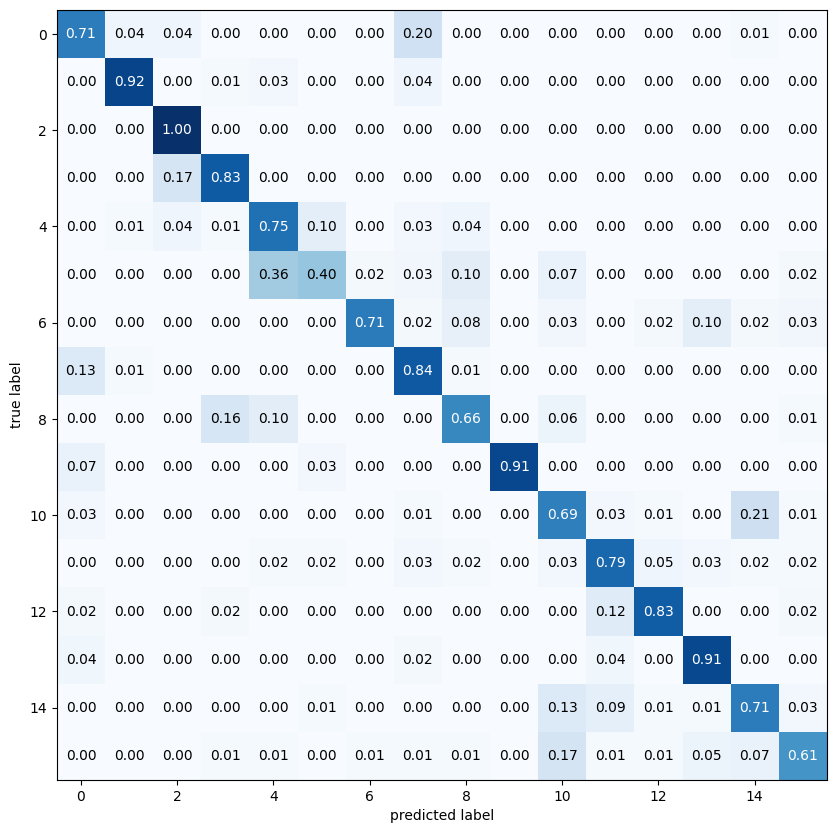

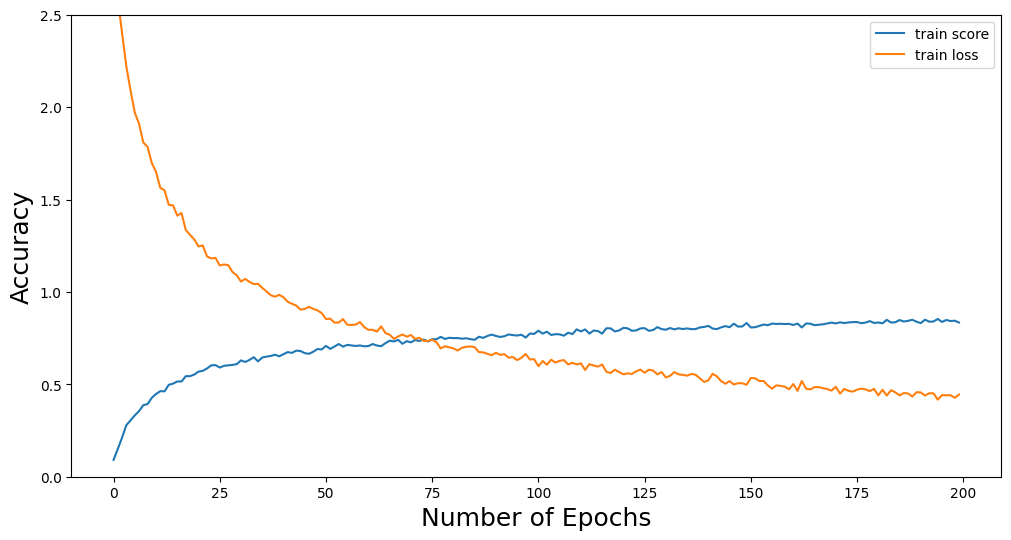

Train Data Shape: (2222, 300, 12)
Test Data Shape: (1089, 300, 12)


Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_108 (Conv1D) │ (None, 293, 64)   │      6,208 │ input_layer_36[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_36    │ (None, 31, 64)    │          0 │ conv1d_108[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_180         │ (None, 31, 64)    │          0 │ max_pooling1d_36… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_180[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_36        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_36[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_36[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_182         │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_182[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_72 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_36[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_109 (Conv1D) │ (None, 31, 24)    │      1,584 │ add_72[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_183         │ (None, 31, 24)    │          0 │ conv1d_109[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_110 (Conv1D) │ (None, 31, 65)    │      1,625 │ dropout_183[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_110[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_73 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_72[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_73[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_72 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_184         │ (None, 128)       │          0 │ dense_72[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 200ms/step - accuracy: 0.0813 - loss: 3.0761
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.1273 - loss: 2.6512
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.1352 - loss: 2.5891
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.1619 - loss: 2.5430
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.1800 - loss: 2.4759
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.2490 - loss: 2.3349
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.3084 - loss: 2.1088
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.3442 - loss: 1.9356
Epoch 9/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.3903 - loss: 1.7915
Epoch 10/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.4536 - loss: 1.6614
Epoch 11/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.4816 - loss: 1.5592
Epoch 12/200
35/35 ━━━━━━━━━━━━━━━━━

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9461 - loss: 0.1617
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.8257 - loss: 0.4864
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
>#37: 
  train accuracy: 0.93834
  train loss    : 0.17673
  test accuracy: 0.78237
  test loss    : 0.63833

Accuracy: 0.78237 (+/-0.00000)
Loss: 0.63833 (+/-0.00000)


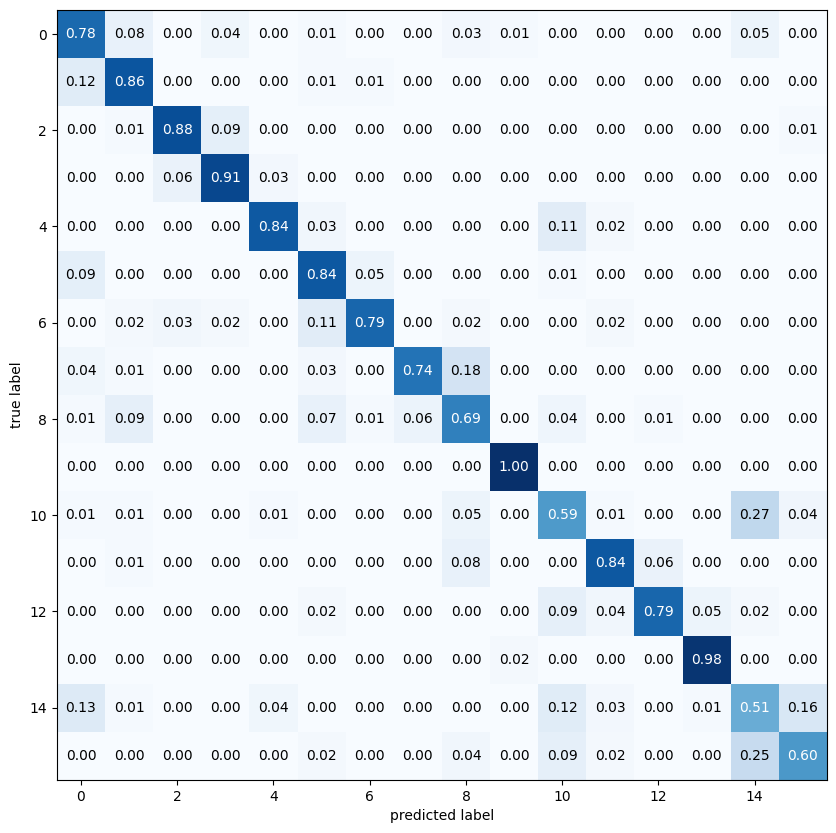

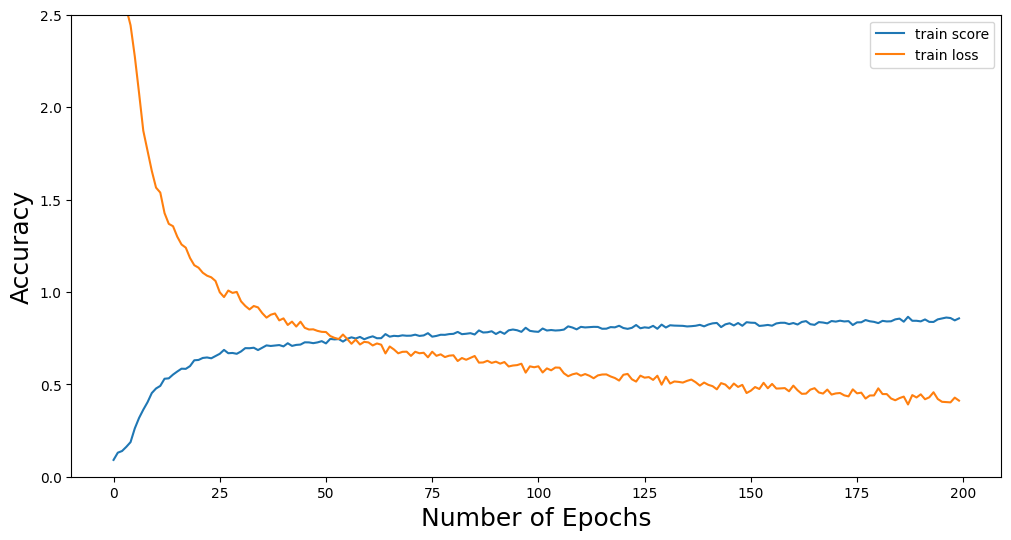

Train Data Shape: (2674, 300, 12)
Test Data Shape: (1298, 300, 12)


Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_37      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_111 (Conv1D) │ (None, 293, 64)   │      6,208 │ input_layer_37[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_37    │ (None, 31, 64)    │          0 │ conv1d_111[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_185         │ (None, 31, 64)    │          0 │ max_pooling1d_37… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_185[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_37        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_37[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_37[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_187         │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_187[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_74 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_37[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_112 (Conv1D) │ (None, 31, 24)    │      1,584 │ add_74[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_188         │ (None, 31, 24)    │          0 │ conv1d_112[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_113 (Conv1D) │ (None, 31, 65)    │      1,625 │ dropout_188[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_113[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_75 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_74[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_75[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_74 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_189         │ (None, 128)       │          0 │ dense_74[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 233ms/step - accuracy: 0.0915 - loss: 2.8919
Epoch 2/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.1592 - loss: 2.5562
Epoch 3/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - accuracy: 0.1850 - loss: 2.4245
Epoch 4/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.2144 - loss: 2.3334
Epoch 5/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.2935 - loss: 2.1404
Epoch 6/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.3222 - loss: 2.0442
Epoch 7/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.3433 - loss: 1.9170
Epoch 8/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.3580 - loss: 1.8666
Epoch 9/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.3962 - loss: 1.7834
Epoch 10/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - accuracy: 0.4307 - loss: 1.6789
Epoch 11/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.4311 - loss: 1.6708
Epoch 12/200
42/42 ━━━━━━━━━━━━━━━━━

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.8114 - loss: 0.4894
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.7164 - loss: 0.7832
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step
>#38: 
  train accuracy: 0.85378
  train loss    : 0.40101
  test accuracy: 0.74499
  test loss    : 0.73086

Accuracy: 0.74499 (+/-0.00000)
Loss: 0.73086 (+/-0.00000)


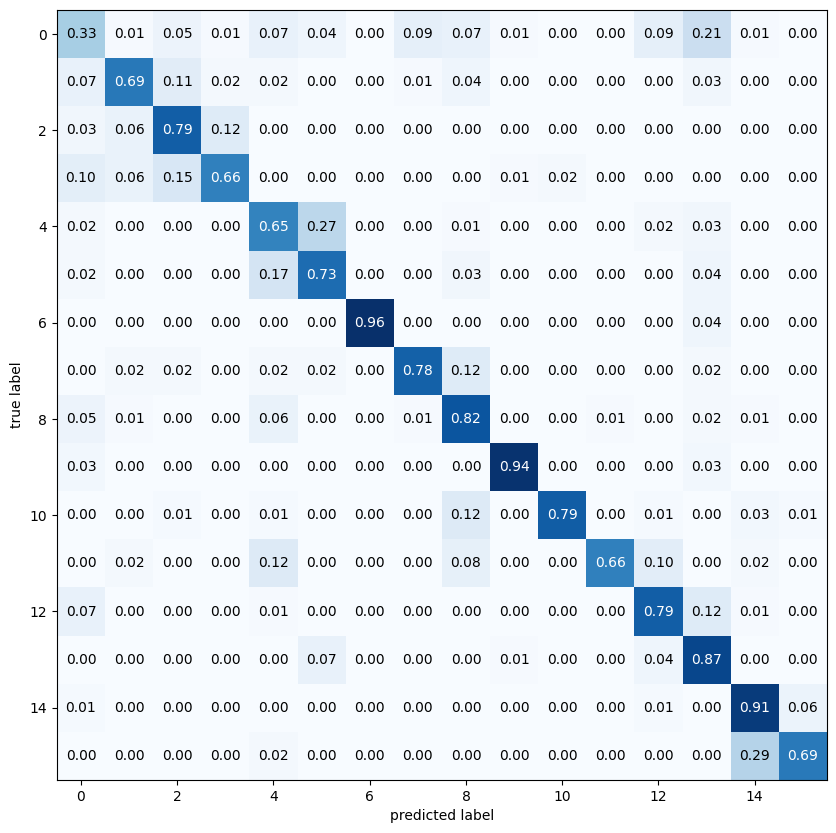

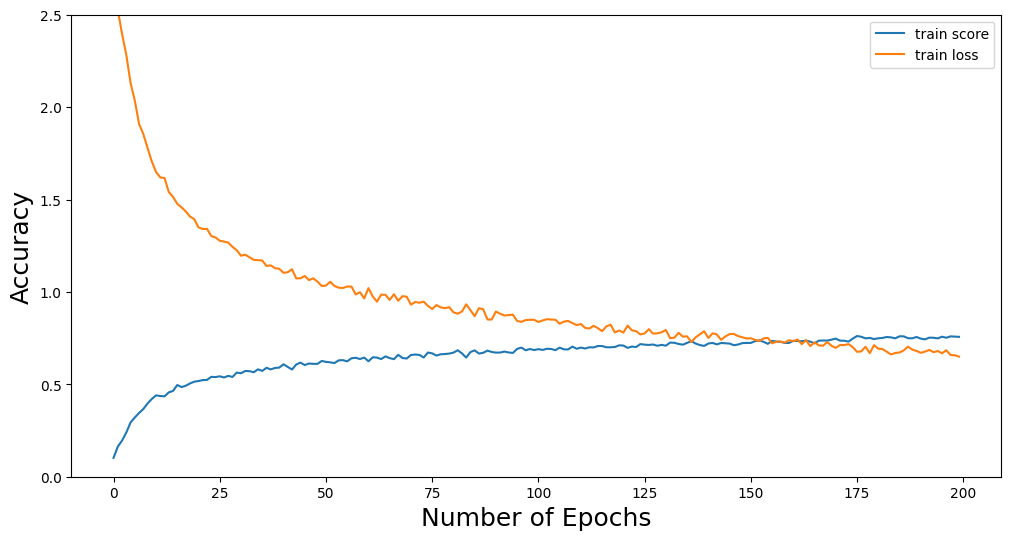

Train Data Shape: (3595, 300, 12)
Test Data Shape: (1771, 300, 12)


Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_114 (Conv1D) │ (None, 293, 64)   │      6,208 │ input_layer_38[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_38    │ (None, 31, 64)    │          0 │ conv1d_114[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_190         │ (None, 31, 64)    │          0 │ max_pooling1d_38… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_190[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_38        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_38[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_38[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_192         │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_192[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_76 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_38[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_115 (Conv1D) │ (None, 31, 24)    │      1,584 │ add_76[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_193         │ (None, 31, 24)    │          0 │ conv1d_115[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_116 (Conv1D) │ (None, 31, 65)    │      1,625 │ dropout_193[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_116[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_77 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_76[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_77[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_76 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_194         │ (None, 128)       │          0 │ dense_76[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 233ms/step - accuracy: 0.0602 - loss: 2.9504
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.1073 - loss: 2.6963
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.1455 - loss: 2.5680
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - accuracy: 0.2074 - loss: 2.4141
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.2311 - loss: 2.2919
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - accuracy: 0.2705 - loss: 2.1764
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy: 0.3007 - loss: 2.0691
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.3234 - loss: 1.9815
Epoch 9/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.3650 - loss: 1.8769
Epoch 10/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.3743 - loss: 1.8182
Epoch 11/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.3878 - loss: 1.7684
Epoch 12/200
57/57 ━━━━━━━━━━━

57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 102ms/step - accuracy: 0.8958 - loss: 0.2797
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.7713 - loss: 0.8504
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 200ms/step
>#39: 
  train accuracy: 0.89986
  train loss    : 0.27753
  test accuracy: 0.74816
  test loss    : 0.93305

Accuracy: 0.74816 (+/-0.00000)
Loss: 0.93305 (+/-0.00000)


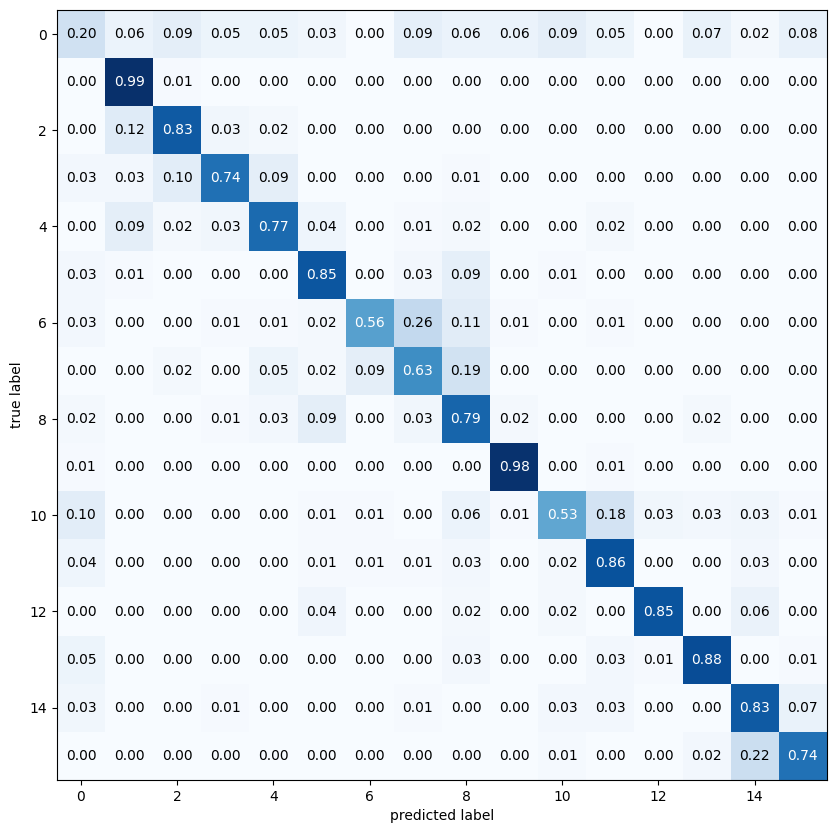

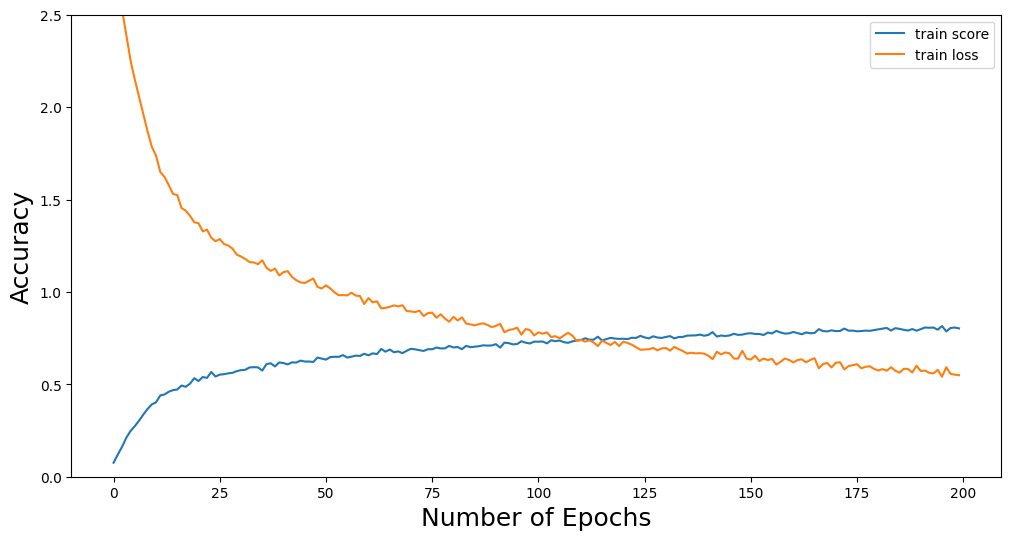

Train Data Shape: (1677, 300, 12)
Test Data Shape: (858, 300, 12)


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_117 (Conv1D) │ (None, 293, 64)   │      6,208 │ input_layer_39[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_39    │ (None, 31, 64)    │          0 │ conv1d_117[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_195         │ (None, 31, 64)    │          0 │ max_pooling1d_39… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_195[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_39        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_39[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_39[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_197         │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_197[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_78 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_39[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_118 (Conv1D) │ (None, 31, 24)    │      1,584 │ add_78[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_198         │ (None, 31, 24)    │          0 │ conv1d_118[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_119 (Conv1D) │ (None, 31, 65)    │      1,625 │ dropout_198[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_119[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_79 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_78[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_79[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_78 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_199         │ (None, 128)       │          0 │ dense_78[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 109s 858ms/step - accuracy: 0.0612 - loss: 2.9643
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - accuracy: 0.1029 - loss: 2.6845
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 322ms/step - accuracy: 0.1282 - loss: 2.6297
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.1863 - loss: 2.5386
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.1841 - loss: 2.4840
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.2377 - loss: 2.3409
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 287ms/step - accuracy: 0.2808 - loss: 2.2290
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.3615 - loss: 1.9958
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 0.3959 - loss: 1.8420
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.4101 - loss: 1.7569
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.4415 - loss: 1.6839
Epoch 12/200
27/27 ━━━━━━━━━━━━━━━━━━━

27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.9636 - loss: 0.1086
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 420ms/step - accuracy: 0.8700 - loss: 0.5238
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step
>#40: 
  train accuracy: 0.96422
  train loss    : 0.11606
  test accuracy: 0.83217
  test loss    : 0.67426

Accuracy: 0.83217 (+/-0.00000)
Loss: 0.67426 (+/-0.00000)


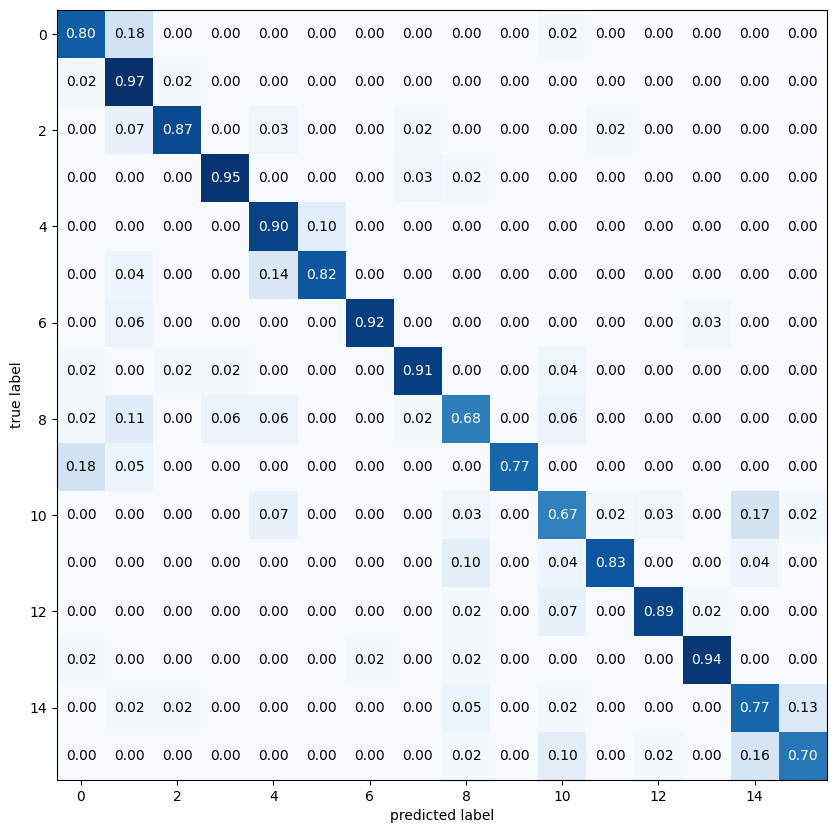

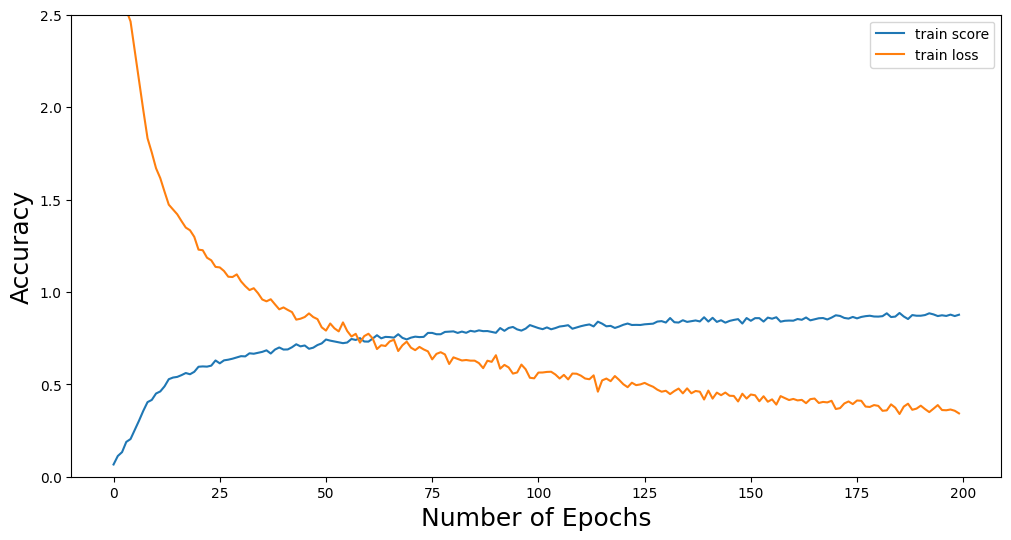

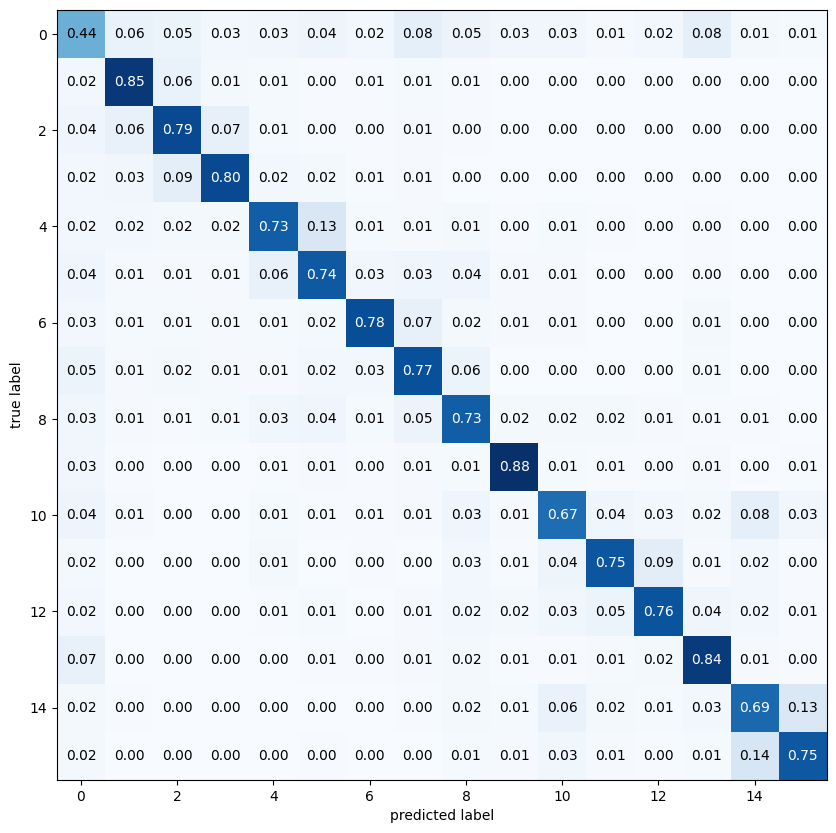

In [6]:

# Main
# ==============================================================================

globel_perd = []
globel_class = []

globel_perd1 = []
globel_class1 = []

# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB2\results\v1\xlsx\Trans_rslt.xlsx')
worksheet1 = workbook.add_worksheet('Subjects informations')

# Start from the first cell. Rows and columns are zero indexed.
row = 0

worksheet1.write(row, 0, 'Subject')
worksheet1.write(row, 1, 'Train_time')
worksheet1.write(row, 2, 'Test_time')
worksheet1.write(row, 3, 'Train_acc')
worksheet1.write(row, 4, 'Train_loss')
worksheet1.write(row, 5, 'Test_acc')
worksheet1.write(row, 6, 'Test_loss')
worksheet1.write(row, 7, 'MCC')

history = History()
for i in range(1, 41):
    loss_train, score_train, loss_test, score_test, y_pred, testy, train_time, test_time = run_my_experiment(i)

    globel_perd.append(y_pred)
    globel_class.append(testy)

    globel_perd1.extend(y_pred)
    globel_class1.extend(testy)

    mcc = matthews_corrcoef(testy, y_pred)
    mat = confusion_matrix(testy, y_pred)

    cfm_plot, ax = plot_confusion_matrix(mat, figsize=(10, 10), show_normed=True, show_absolute=False)
    cfm_plot.savefig(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB2\results\v1\confusion_matrix\S' + str(i) + 'trans_confusion_matrix.png')

    fig, axarr = plt.subplots(figsize=(12, 6), ncols=1)
    plot_renge = int(len(history.history['accuracy']) / i)
    global_renge = len(history.history['accuracy'])
    start_renge = global_renge - plot_renge
    axarr.plot(range(plot_renge), history.history['accuracy'][start_renge: global_renge], label='train score')
    axarr.plot(range(plot_renge), history.history['loss'][start_renge: global_renge], label='train loss')
    axarr.set_xlabel('Number of Epochs', fontsize=18)
    axarr.set_ylabel('Accuracy', fontsize=18)
    axarr.set_ylim([0, 2.5])
    plt.legend()
    plt.show()
    fig.savefig(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB2\results\v1\graphs\S' + str(i) + 'trans_graphe.png')

    # Sheet informations
    worksheet1.write(i, 0, 'Sujet ' + str(i))
    worksheet1.write(i, 1, train_time)
    worksheet1.write(i, 2, test_time)
    worksheet1.write(i, 3, score_train)
    worksheet1.write(i, 4, loss_train)
    worksheet1.write(i, 5, score_test)
    worksheet1.write(i, 6, loss_test)
    worksheet1.write(i, 7, mcc)

workbook.close()

# Save prediction
new_data = {'pred_labels': globel_perd, 'class_labels': globel_class}
savemat(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB2\results\v1\trans_global_predection.mat', new_data)

mat = confusion_matrix(globel_class1, globel_perd1)
cfm_plot, ax = plot_confusion_matrix(mat, figsize=(10, 10), show_normed=True, show_absolute=False)
cfm_plot.savefig(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB2\results\v1\trans_global_confusion_matrix.png')


